In [1]:
import heist
import helpers
import torch.distributions
import torch

import gym
import random
import numpy as np
from helpers import generate_action, load_model
from procgen import ProcgenGym3Env
import imageio
import matplotlib.pyplot as plt
import typing
import math

from procgen import ProcgenGym3Env
import struct
import typing
from typing import Tuple, Dict, Callable, List, Optional
from dataclasses import dataclass
from src.policies_modified import ImpalaCNN
from procgen_tools.procgen_wrappers import VecExtractDictObs, TransposeFrame, ScaledFloatFrame

from gym3 import ToBaselinesVecEnv
import seaborn as sns


%load_ext autoreload
%autoreload 2

In [2]:

env_name = "procgen:procgen-heist-v0"  

env = gym.make(env_name, start_level=100, num_levels=200, render_mode="rgb_array", distribution_mode="easy") #remove render mode argument to go faster but not produce images 

model = helpers.load_model()

In [3]:
class ModelActivations:
    def __init__(self, model):
        self.activations = {}
        self.model = model
        self.hooks = []  # To keep track of hooks

    def clear_hooks(self):
        # Remove all previously registered hooks
        for hook in self.hooks:
            hook.remove()
        self.hooks = []
        self.activations = {}

    def get_activation(self, name):
        def hook(model, input, output):
            processed_output = []
            for item in output:
                if isinstance(item, torch.Tensor):
                    processed_output.append(item.detach())
                elif isinstance(item, torch.distributions.Categorical):
                    processed_output.append(item.logits.detach())
                else:
                    processed_output.append(item)
            self.activations[name] = tuple(processed_output)
        return hook

    def register_hook_by_path(self, path, name):
        elements = path.split('.')
        model = self.model
        for i, element in enumerate(elements):
            if '[' in element:
                base, index = element.replace(']', '').split('[')
                index = int(index)
                model = getattr(model, base)[index]
            else:
                model = getattr(model, element)
            if i == len(elements) - 1:
                hook = model.register_forward_hook(self.get_activation(name))
                self.hooks.append(hook)  # Keep track of the hook

    def run_with_cache(self, input, layer_paths):
        self.clear_hooks()  # Clear any existing hooks
        self.activations = {}  # Reset activations

        # Handle edge case: input is not a tensor
        if not isinstance(input, torch.Tensor):
            input = torch.tensor(input, dtype=torch.float32)


        # Check the shape of the input and reshape if necessary
        if input.shape == torch.Size([1, 3, 64, 64]):
            input = input.squeeze(0)  # Remove the batch dimension
        if input.shape == torch.Size([3, 64, 64]):
            input = input.permute(1, 2, 0)  # Switch dimensions to (64, 64, 3)


        # Handle edge case: empty layer_paths
        if not layer_paths:
            output = self.model(input)
            return output, self.activations

        # Register hooks for each layer path
        for path in layer_paths:
            try:
                self.register_hook_by_path(path, path.replace('.', '_'))
            except AttributeError:
                print(f"Warning: Layer '{path}' not found in the model. Skipping hook registration.")

        # Add batch dimension if missing
        if input.dim() == 3:
            input = input.unsqueeze(0)

        # Run the model with the registered hooks
        output = self.model(input)

        return output, self.activations

model_activations = ModelActivations(model)
model_activations.clear_hooks()


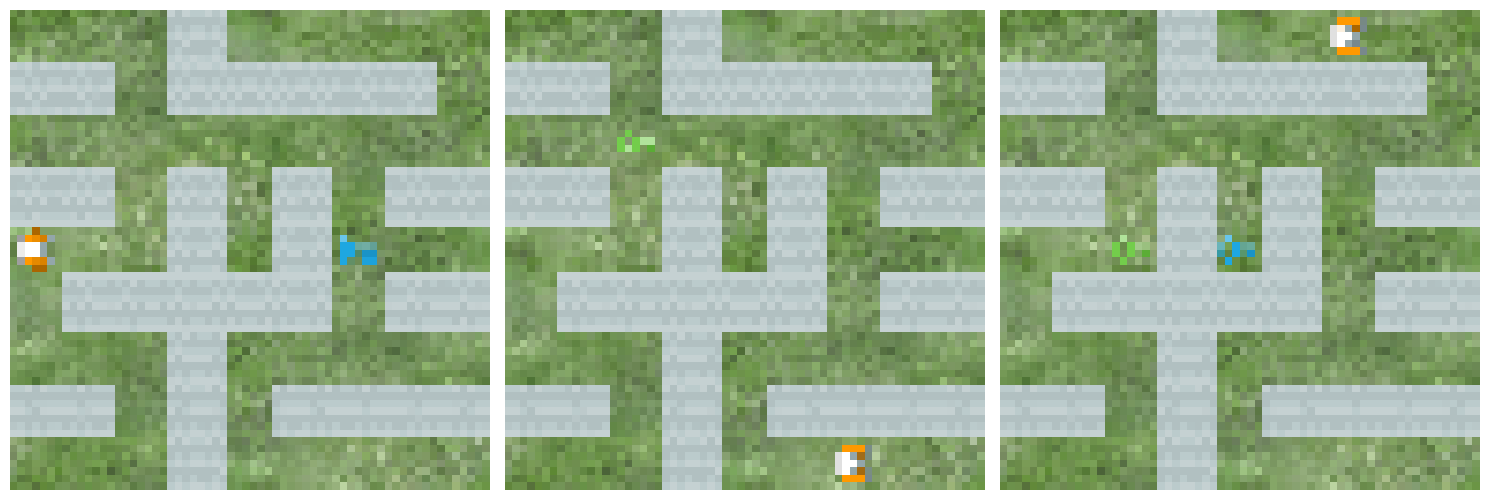

In [4]:
num_samples = 1
num_levels = 100
key_color_combinations = [['blue'], ['green'], ['blue', 'green']]
observations_list = heist.create_key_states(key_color_combinations, num_samples, num_levels)


import itertools
fig, axs = plt.subplots(1, 3, figsize=(15, 12))  # Adjusted to create a 5x3 grid
for ( j), obs in zip(itertools.product(range(3)), itertools.chain.from_iterable(observations_list)):
    axs[ j].imshow(obs.transpose(1, 2, 0))
    # axs[i, j].set_title(f"Sample {j+1}, Obs {i+1}")
    axs[j].axis('off')
plt.tight_layout()
plt.show()

In [5]:
layer_paths = [
    'conv_seqs.0.conv',
    'conv_seqs.0.res_block0.conv0',
    'conv_seqs.0.res_block0.conv1',
    'conv_seqs.0.res_block1.conv0',
    'conv_seqs.0.res_block1.conv1',
    'conv_seqs.1.conv',
    'conv_seqs.1.res_block0.conv0',
    'conv_seqs.1.res_block0.conv1',
    'conv_seqs.1.res_block1.conv0',
    'conv_seqs.1.res_block1.conv1',
    'conv_seqs.2.conv',
    'conv_seqs.2.res_block0.conv0',
    'conv_seqs.2.res_block0.conv1',
    'conv_seqs.2.res_block1.conv0',
    'conv_seqs.2.res_block1.conv1',
    # Add other layers as needed
]

In [6]:

blue_key_only = observations_list[0][0]
green_key_only = observations_list[0][1]
blue_and_green_key = observations_list[0][2]

obs1 = torch.tensor(blue_key_only, dtype=torch.float32)
obs2 = torch.tensor(blue_and_green_key, dtype=torch.float32)

output1, blue_key_only_activations = model_activations.run_with_cache(obs1, layer_paths)
model_activations.clear_hooks()
output2, blue_and_green_key_activations = model_activations.run_with_cache(obs2, layer_paths)



In [7]:
def run_episode_and_save_as_gif(env, model, filepath='../gifs/run.gif', save_gif=False, episode_timeout=200):

    observations = []
    observation = env.reset()
    done = False
    total_reward = 0
    frames=[]
    
    

    # observation = colour_swap(observation)
    count = 0
    while not done:
        if save_gif:
            frames.append(env.render(mode='rgb_array'))  
        action = generate_action(model, observation, is_procgen_env=True) 
        
        observation, reward, done, info = env.step(action)
        total_reward += reward
        observations.append(observation)
        count +=1
        if count >= episode_timeout:
            break

    if save_gif:
        imageio.mimsave(filepath, frames, fps=30) 

    return total_reward, frames, observations




In [8]:
save_gif_option = True  
for episode in range(1):
    venv = gym.make(env_name, start_level=100, num_levels=200, render_mode="rgb_array", distribution_mode="easy") #remove render mode argument to go faster but not produce images 
    total_reward, frames, observations = run_episode_and_save_as_gif(venv, model, filepath=f'episode_mod_2_{episode+1}.gif', save_gif=save_gif_option)
    print(f"Episode {episode + 1} finished with total reward: {total_reward}")

/Users/bensturgeon/Library/Caches/pypoetry/virtualenvs/ai-safety-camp-Y8XZewIj-py3.10/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/Users/bensturgeon/Library/Caches/pypoetry/virtualenvs/ai-safety-camp-Y8XZewIj-py3.10/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/Users/bensturgeon/Library/Caches/pypoetry/virtualenvs/ai-safety-camp-Y8XZewIj-py3.10/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing 

AssertionError: action shape did not match expected=(1,) actual=(1, 1)

In [ ]:
observation = torch.tensor(observations[0], dtype=torch.float32).unsqueeze(0)
output1, normal_activations = model_activations.run_with_cache(observation, layer_paths)

torch.Size([1, 64, 64, 3])


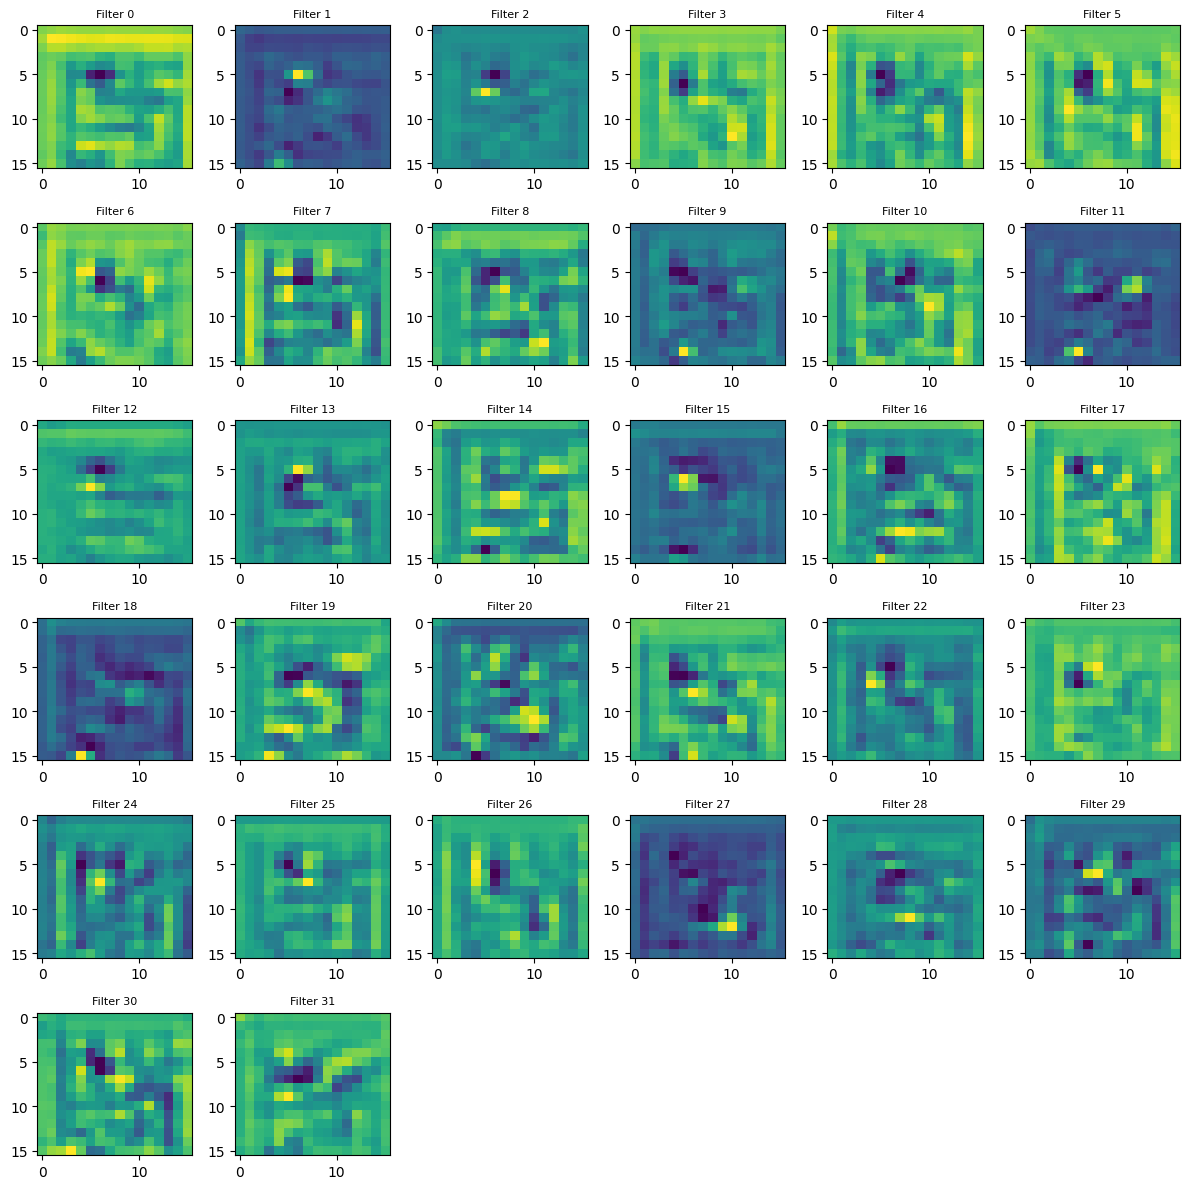

In [ ]:
helpers.plot_layer_activations_dynamic_grid(normal_activations, "conv_seqs_2_conv")

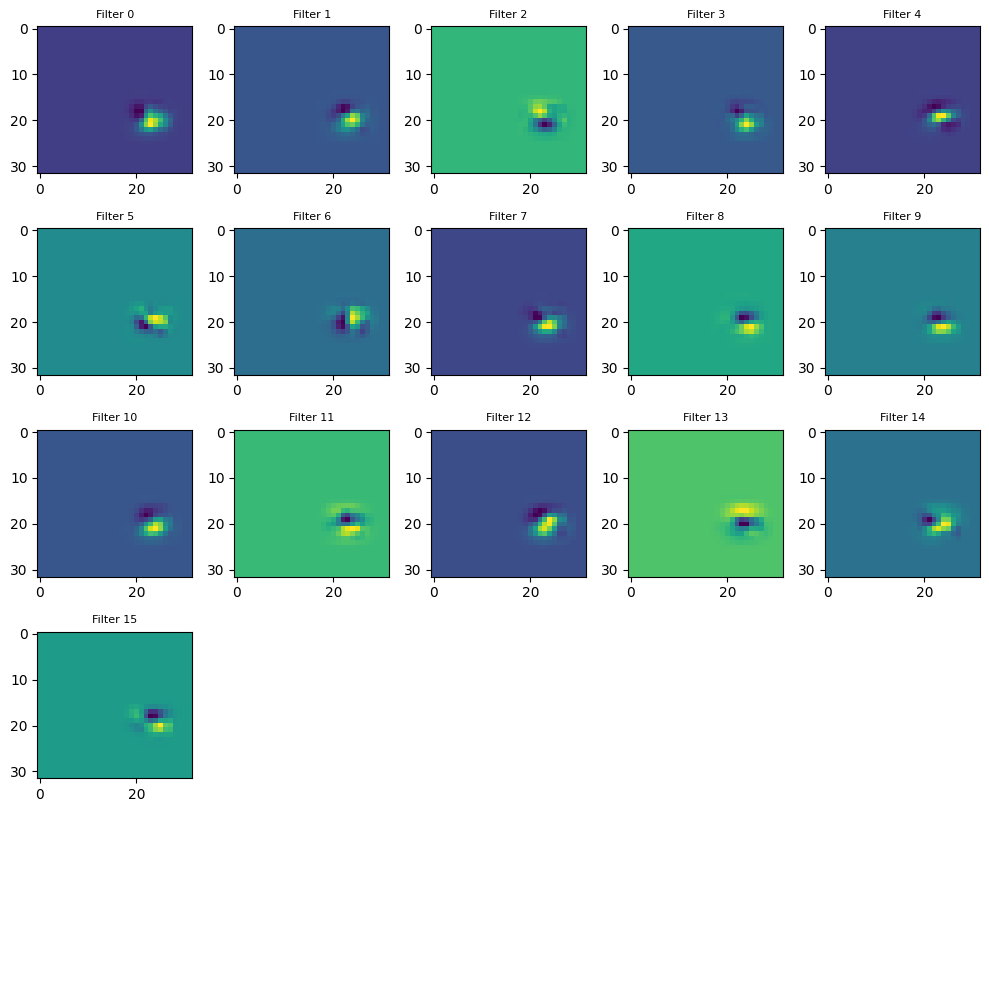

In [ ]:
helpers.plot_layer_activations_dynamic_grid(differences, "conv_seqs_0_res_block1_conv1")


# Compare activations in intepretable vs default model

In [21]:
venv = heist.create_venv(num=1, start_level=random.randint(1000, 10000), num_levels=num_levels)
state = heist.state_from_venv(venv, 0)

full_grid = state.full_grid(with_mouse=False)
entities = state.state_vals["ents"]
legal_mouse_positions = heist.get_legal_mouse_positions(full_grid, entities)

unchanged_obs= venv.reset()


state.remove_all_entities()

x, y = heist.get_legal_mouse_positions(full_grid, entities)[random.randint(0, len(legal_mouse_positions) - 1)]
entities = state.state_vals["ents"]
# state.set_key_position(0,x,y) 
entities = state.state_vals["ents"]
x, y = heist.get_legal_mouse_positions(full_grid, entities)[random.randint(0, len(legal_mouse_positions) - 1)]
state.set_mouse_pos(x,y)
entities = state.state_vals["ents"]
x, y = heist.get_legal_mouse_positions(full_grid, entities)[random.randint(0, len(legal_mouse_positions) - 1)]
state.set_gem_position(x,y)
state_bytes = state.state_bytes
if state_bytes is not None:
    venv.env.callmethod("set_state", [state_bytes])
    obs = venv.reset()

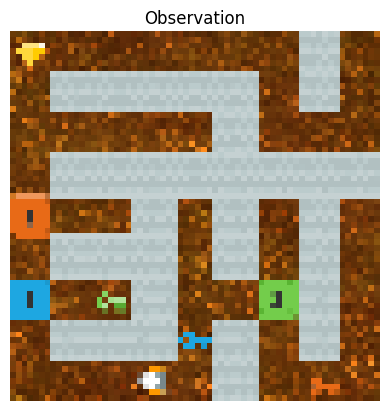

In [72]:
helpers.plot_single_observation(unchanged_obs.squeeze().transpose(1,2,0))

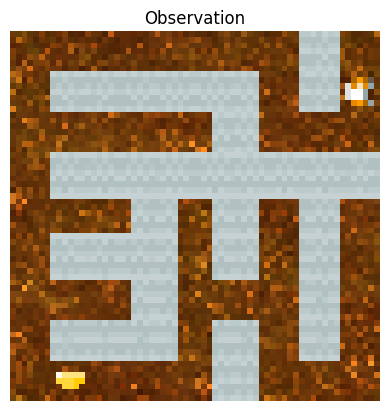

In [74]:
helpers.plot_single_observation(obs.squeeze().transpose(1,2,0))


In [75]:
from src.policies_impala import ImpalaCNN
less_interpretable_model = helpers.load_model(ImpalaCNN, "../model_1400_latest.pt", )
less_interpretable_model_layer_paths = helpers.get_model_layer_names(less_interpretable_model)
model_activations = ModelActivations(less_interpretable_model)
output2, gem_only_activations = model_activations.run_with_cache(obs, less_interpretable_model_layer_paths)
output2, unmodified_activations = model_activations.run_with_cache(helpers.observation_to_rgb( unchanged_obs), less_interpretable_model_layer_paths)


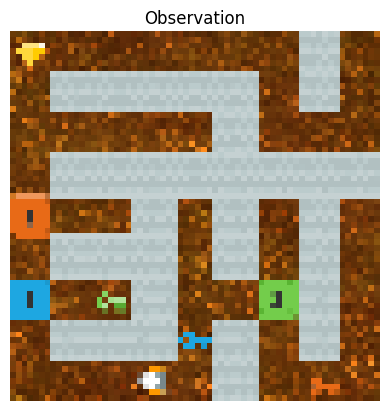

In [77]:
helpers.plot_activations_for_layers(unmodified_activations, ["conv_seqs_0_conv", "conv_seqs_1_conv"] )

# Interpretable model activations

In [85]:
from src.policies_modified import ImpalaCNN
model = helpers.load_model(ImpalaCNN,"../model_1501.0_interpretable.pt")
interp_model_activations =  ModelActivations(model)
interpretable_model_layer_paths = helpers.get_model_layer_names(model)
output2, player_gem_activations_interp = interp_model_activations.run_with_cache(helpers.observation_to_rgb(obs), interpretable_model_layer_paths)
output2, unmodified_activations_interp = interp_model_activations.run_with_cache(helpers.observation_to_rgb( unchanged_obs), interpretable_model_layer_paths)

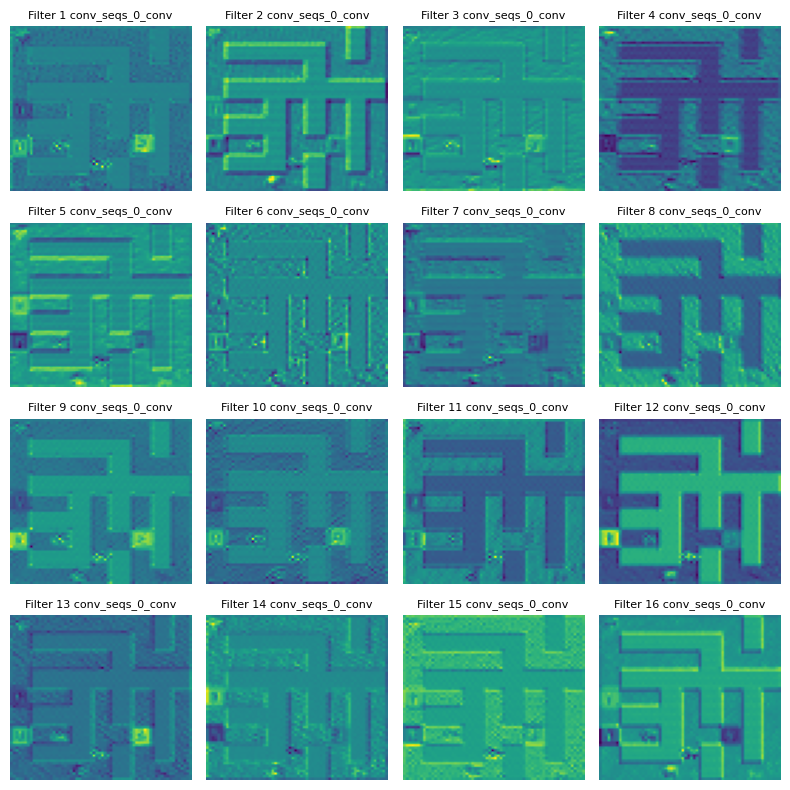

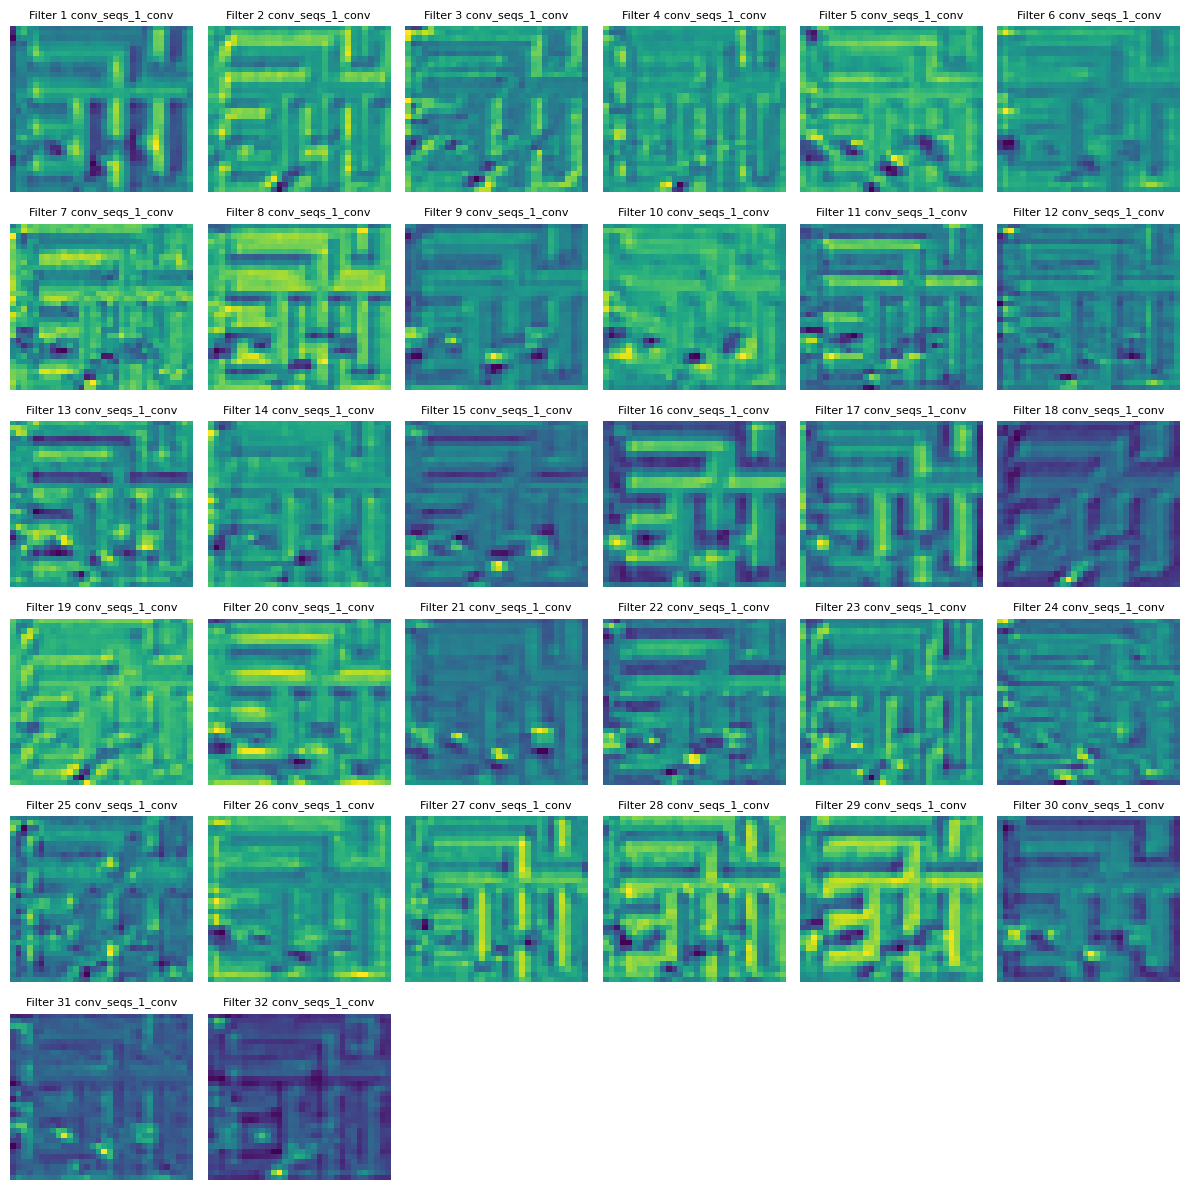

In [80]:
helpers.plot_activations_for_layers(unmodified_activations_interp, ["conv_seqs_0_conv", "conv_seqs_1_conv"] )

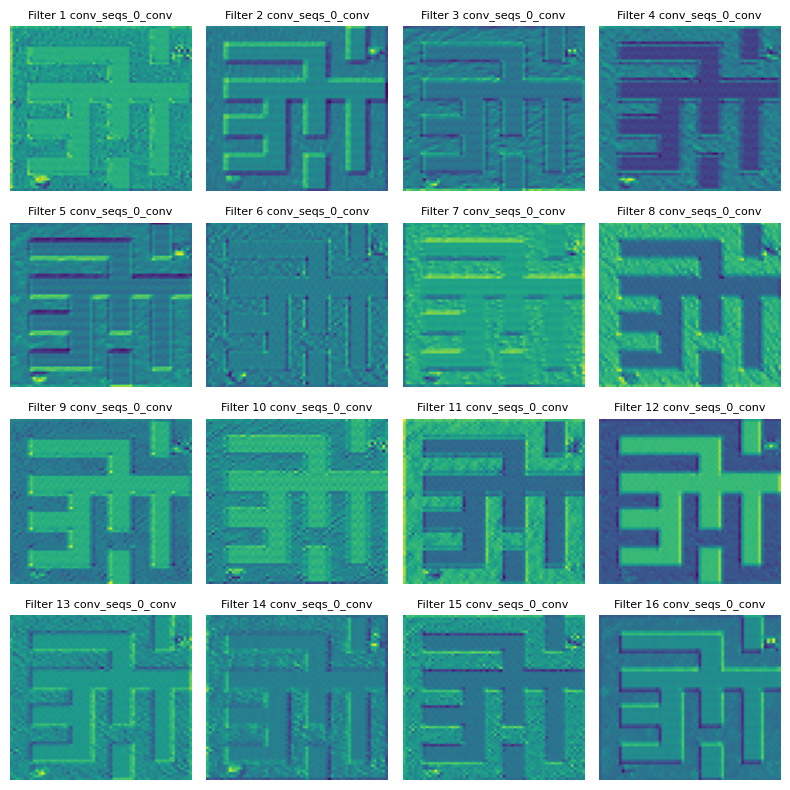

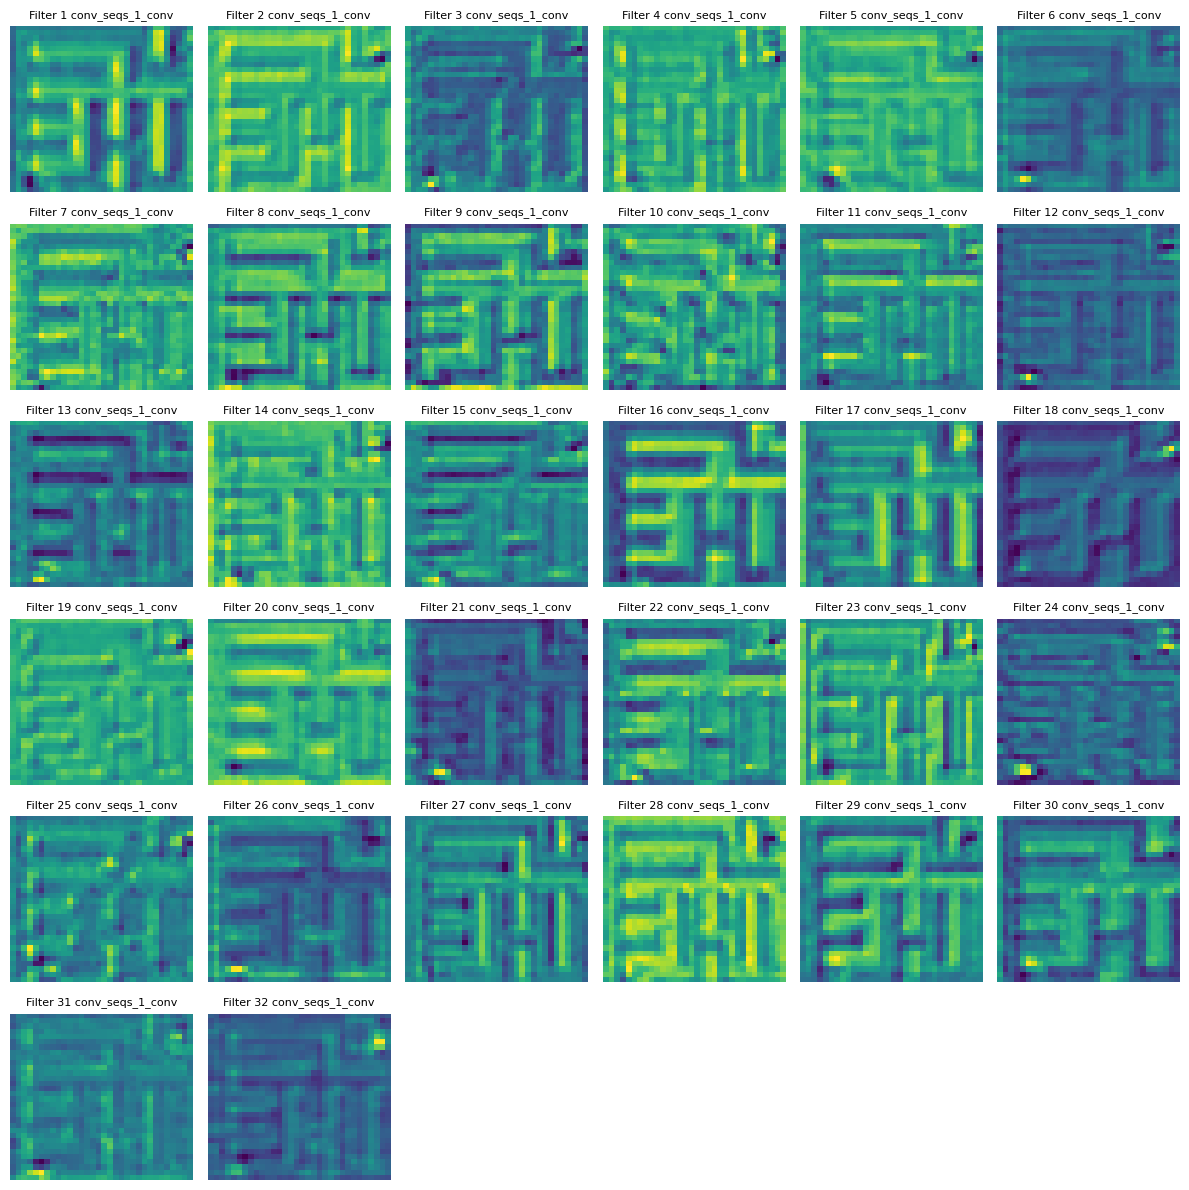

In [86]:
helpers.plot_activations_for_layers(player_gem_activations_interp, ["conv_seqs_0_conv", "conv_seqs_1_conv"] )


In [ ]:
venv = heist.create_venv(num=1, start_level=random.randint(1000, 10000), num_levels=num_levels)
state = heist.state_from_venv(venv, 0)

full_grid = state.full_grid(with_mouse=False)
entities = state.state_vals["ents"]
legal_mouse_positions = heist.get_legal_mouse_positions(full_grid, entities)

unchanged_obs= venv.reset()

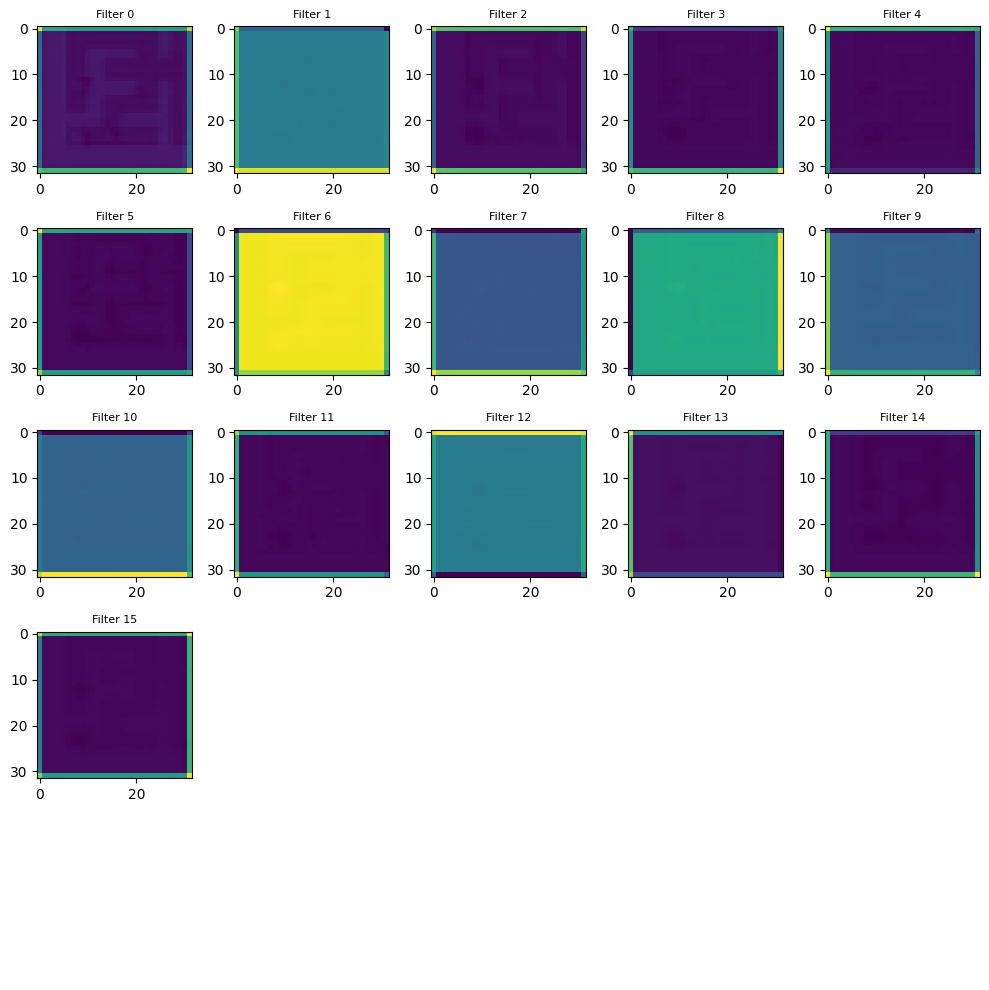

In [87]:
venv = heist.create_venv(num=1, start_level=random.randint(1000, 10000), num_levels=num_levels)
state = heist.state_from_venv(venv, 0)
normal_obs = venv.reset()
output2, normal_activations = model_activations.run_with_cache(normal_obs, layer_paths)
helpers.plot_layer_activations_dynamic_grid(normal_activations, "conv_seqs_0_res_block0_conv0")

In [ ]:
activations = {}

def get_activation(name):
    def hook(model, input, output):
        # Initialize a placeholder for processed output
        processed_output = []
        
        for item in output:
            # Check if the item is a tensor and detach it
            if isinstance(item, torch.Tensor):
                processed_output.append(item.detach())
            # If the item is a Categorical, you might want to extract its logits or probs
            elif isinstance(item, torch.distributions.Categorical):
                processed_output.append(item.logits.detach())
            else:
                # Handle other types as necessary
                processed_output.append(item)
        
        # Save the processed output in the activations dictionary
        activations[name] = tuple(processed_output)
    return hook



# Define a function to recursively register hooks based on a path
def register_hook_by_path(model, path, name):
    elements = path.split('.')
    for i, element in enumerate(elements):
        if '[' in element:
            # Splitting at '[' and removing the closing ']' to get the index
            base, index = element.replace(']', '').split('[')
            index = int(index)  # Convert index to integer
            model = getattr(model, base)[index]
        else:
            model = getattr(model, element)
        # If we are at the last element, register the hook
        if i == len(elements) - 1:
            model.register_forward_hook(get_activation(name))

# List of layer paths to hook, based on your initial list
layer_paths = [
    'conv_seqs.0.conv',
    'conv_seqs.0.res_block0.conv0',
    'conv_seqs.0.res_block0.conv1',
    'conv_seqs.0.res_block1.conv0',
    'conv_seqs.0.res_block1.conv1',
    'conv_seqs.1.conv',
    'conv_seqs.1.res_block0.conv0',
    'conv_seqs.1.res_block0.conv1',
    'conv_seqs.1.res_block1.conv0',
    'conv_seqs.1.res_block1.conv1',
    'conv_seqs.2.conv',
    'conv_seqs.2.res_block0.conv0',
    'conv_seqs.2.res_block0.conv1',
    'conv_seqs.2.res_block1.conv0',
    'conv_seqs.2.res_block1.conv1',
    # Add other layers as needed
]


# Register hooks for each path
for path in layer_paths:
    register_hook_by_path(model, path, path.replace('.', '_'))


observation = torch.tensor(normal_obs, dtype=torch.float32)


# if observation.shape == torch.Size([3, 64, 64]):
observation = observation.permute(0,3, 2, 1)  # Switch dimensions to (64, 64, 3)

output = model(observation)


In [ ]:
observation_test = torch.tensor(observations[0], dtype=torch.float32).unsqueeze(0)
observation_test.shape

torch.Size([1, 64, 64, 3])

In [130]:

def run_episode_and_save_as_gif(env, model, filepath='../gifs/run.gif', save_gif=False, episode_timeout=400, is_procgen_env=False):

    observations = []
    observation = env.reset()
    done = False
    total_reward = 0
    frames=[]
    
    
    activations = {}
    # observation = colour_swap(observation)
    count = 0
    while not done:
        if save_gif:
            frames.append(env.render(mode='rgb_array'))  
        observation= np.squeeze(observation)
        observation =np.transpose(observation, (1,2,0))
        converted_obs = helpers.observation_to_rgb(observation)
        action = helpers.generate_action(model, converted_obs, is_procgen_env) 
        observation, reward, done, info = env.step(action)
        # observation = colour_swap(observation)
        total_reward += reward
        observations.append(converted_obs)
        count +=1
        if count >= episode_timeout:
            break

    if save_gif:
        imageio.mimsave(filepath, frames, fps=30) 

    return total_reward, frames, observations

env_name = "procgen:procgen-heist-v0"  

env = gym.make(env_name, start_level=100, num_levels=200, render_mode="rgb_array", distribution_mode="easy") #remove render mode argument to go faster but not produce images 

model = helpers.load_model()

# save_gif_option = False  
# for episode in range(10):
#     venv = heist.create_venv(num=1, start_level=random.randint(1000, 10000), num_levels=4)
#     # env = gym.make(env_name, start_level=100, num_levels=200, render_mode="rgb_array", distribution_mode="easy") #remove render mode argument to go faster but not produce images 
#     env = heist.create_venv(1,0,5)

#     total_reward, frames, observations = run_episode_and_save_as_gif(env, model, filepath=f'episode_mod_2_{episode+1}_procgen2.gif', save_gif=save_gif_option)
#     print(f"Episode {episode + 1} finished with total reward: {total_reward}")

RuntimeError: Error(s) in loading state_dict for ImpalaCNN:
	Missing key(s) in state_dict: "conv_seqs.3.conv.weight", "conv_seqs.3.conv.bias", "conv_seqs.3.res_block0.conv0.weight", "conv_seqs.3.res_block0.conv0.bias", "conv_seqs.3.res_block0.conv1.weight", "conv_seqs.3.res_block0.conv1.bias", "conv_seqs.3.res_block1.conv0.weight", "conv_seqs.3.res_block1.conv0.bias", "conv_seqs.3.res_block1.conv1.weight", "conv_seqs.3.res_block1.conv1.bias", "conv_seqs.4.conv.weight", "conv_seqs.4.conv.bias", "conv_seqs.4.res_block0.conv0.weight", "conv_seqs.4.res_block0.conv0.bias", "conv_seqs.4.res_block0.conv1.weight", "conv_seqs.4.res_block0.conv1.bias", "conv_seqs.4.res_block1.conv0.weight", "conv_seqs.4.res_block1.conv0.bias", "conv_seqs.4.res_block1.conv1.weight", "conv_seqs.4.res_block1.conv1.bias", "hidden_fc1.weight", "hidden_fc1.bias", "hidden_fc2.weight", "hidden_fc2.bias". 
	Unexpected key(s) in state_dict: "hidden_fc.weight", "hidden_fc.bias". 
	size mismatch for logits_fc.weight: copying a param with shape torch.Size([15, 256]) from checkpoint, the shape in current model is torch.Size([15, 512]).
	size mismatch for value_fc.weight: copying a param with shape torch.Size([1, 256]) from checkpoint, the shape in current model is torch.Size([1, 512]).

## Procgen env notes
The above experiments confirm that the model is now working on the procgen venv once we convert the values to the right scale and below demonstrate that the activations are looking as we expect. 



In [ ]:
normal_activations.keys()

dict_keys(['conv_seqs_0_conv', 'conv_seqs_0_res_block0_conv0', 'conv_seqs_0_res_block0_conv1', 'conv_seqs_0_res_block1_conv0', 'conv_seqs_0_res_block1_conv1', 'conv_seqs_1_conv', 'conv_seqs_1_res_block0_conv0', 'conv_seqs_1_res_block0_conv1', 'conv_seqs_1_res_block1_conv0', 'conv_seqs_1_res_block1_conv1', 'conv_seqs_2_conv', 'conv_seqs_2_res_block0_conv0', 'conv_seqs_2_res_block0_conv1', 'conv_seqs_2_res_block1_conv0', 'conv_seqs_2_res_block1_conv1'])

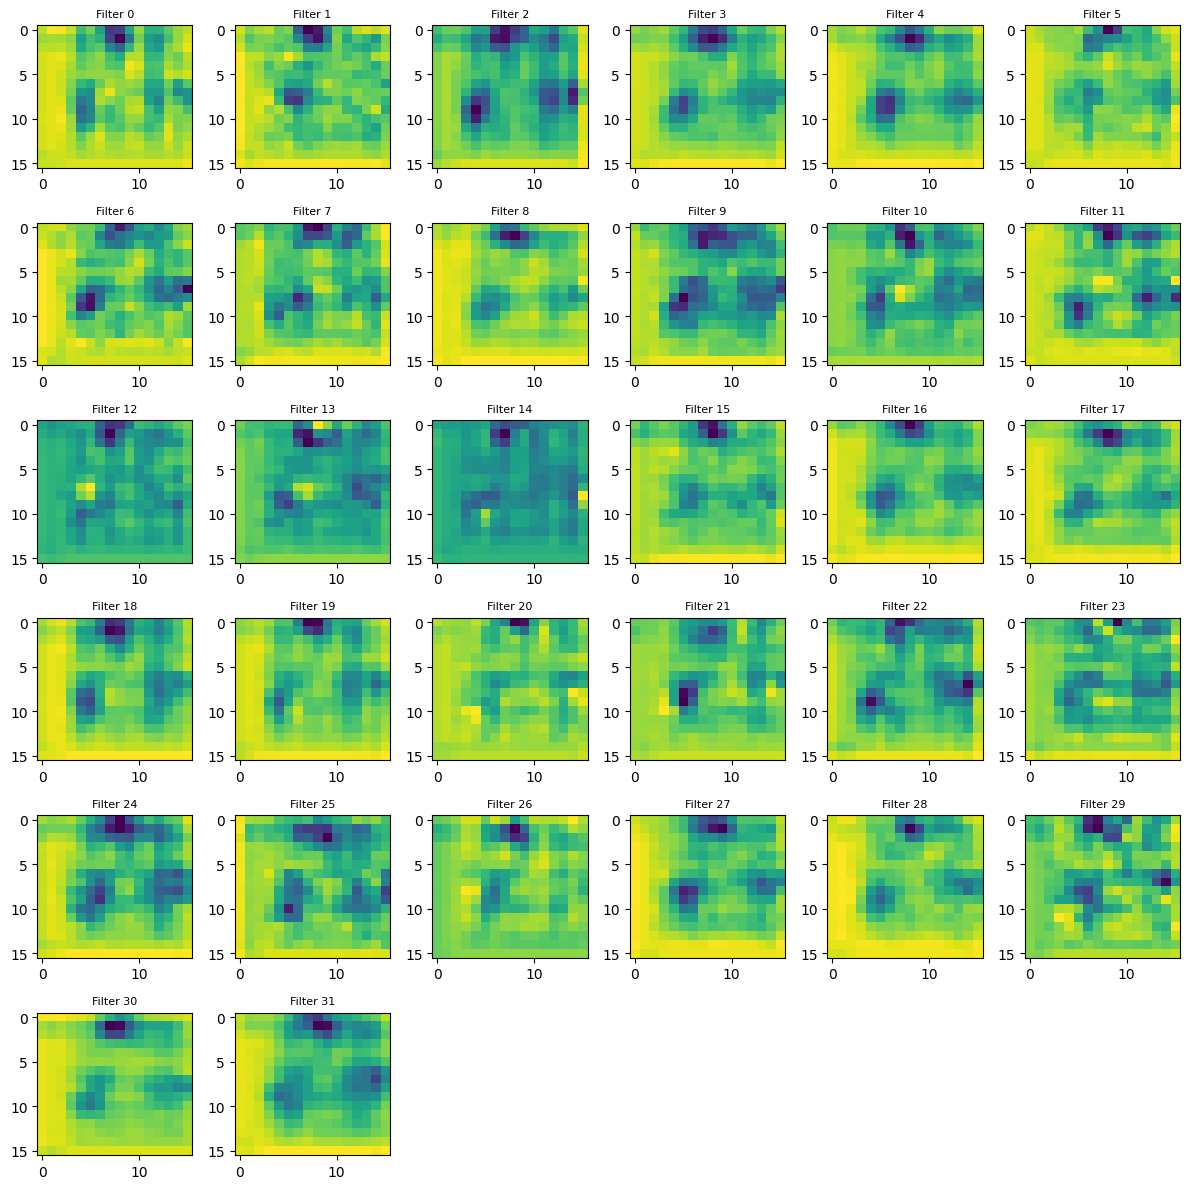

In [ ]:
helpers.plot_layer_activations_dynamic_grid(normal_activations, "conv_seqs_1_res_block0_conv0")

## Exploring key interactions without goals
To discover how the agent operates without a final goal we set up an environment with no final goal present. We can then have it run through the episode as normal and look at the gif of its performance as well as the initial activations.


In [ ]:
# num_levels = 5
# venv = heist.create_venv(num=1, start_level=random.randint(1000, 10000), num_levels=num_levels)
# state = heist.state_from_venv(venv, 0)

# full_grid = state.full_grid(with_mouse=False)
# entities = state.state_vals["ents"]
# legal_mouse_positions = heist.get_legal_mouse_positions(full_grid, entities)

unchanged_obs= venv.reset()


state.remove_all_entities()

x, y = heist.get_legal_mouse_positions(full_grid, entities)[random.randint(0, len(legal_mouse_positions) - 1)]
entities = state.state_vals["ents"]
state.set_key_position(0,x,y) 
entities = state.state_vals["ents"]
x, y = heist.get_legal_mouse_positions(full_grid, entities)[random.randint(0, len(legal_mouse_positions) - 1)]
state.set_mouse_pos(x,y)
state_bytes = state.state_bytes
if state_bytes is not None:
    venv.env.callmethod("set_state", [state_bytes])
    obs = venv.reset()

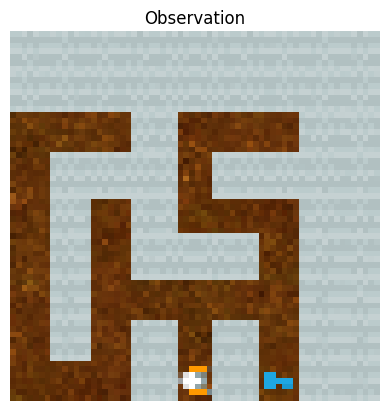

In [ ]:
helpers.plot_single_observation(obs.squeeze().transpose(1,2,0))

In [ ]:
entities = state.state_vals["ents"]
x, y = heist.get_legal_mouse_positions(full_grid, entities)[random.randint(0, len(legal_mouse_positions) - 1)]
state.set_gem_position(x,y)

state_bytes = state.state_bytes
if state_bytes is not None:
    venv.env.callmethod("set_state", [state_bytes])
    obs = venv.reset()

In [ ]:
venv[0]

TypeError: 'ScaledFloatFrame' object is not subscriptable

In [ ]:
save_gif_option = True  

model = helpers.load_model()

total_reward, frames, observations = run_episode_and_save_as_gif(venv, model, filepath=f'episode_0_key.gif', save_gif=save_gif_option, episode_timeout=150)

In [ ]:
layer_paths = [
    'conv_seqs.0.conv',
    'conv_seqs.0.res_block0.conv0',
    'conv_seqs.0.res_block0.conv1',
    'conv_seqs.0.res_block1.conv0',
    'conv_seqs.0.res_block1.conv1',
    'conv_seqs.1.conv',
    'conv_seqs.1.res_block0.conv0',
    'conv_seqs.1.res_block0.conv1',
    'conv_seqs.1.res_block1.conv0',
    'conv_seqs.1.res_block1.conv1',
    'conv_seqs.2.conv',
    'conv_seqs.2.res_block0.conv0',
    'conv_seqs.2.res_block0.conv1',
    'conv_seqs.2.res_block1.conv0',
    'conv_seqs.2.res_block1.conv1',
    # Add other layers as needed
]


model_activations = ModelActivations(model)

output2, normal_activations = model_activations.run_with_cache(observations[0], layer_paths)


torch.Size([64, 64, 3])


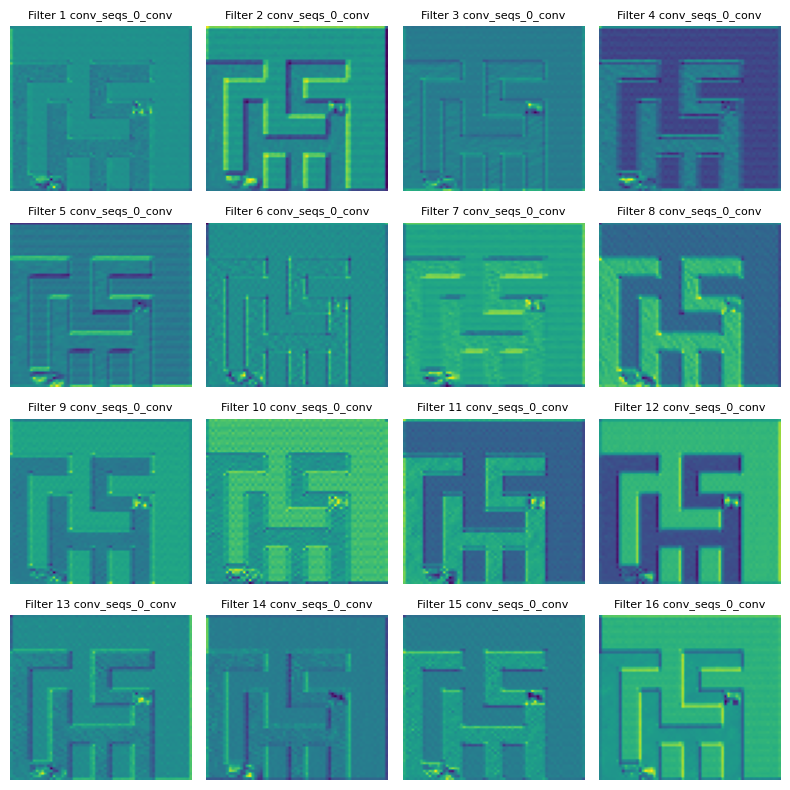

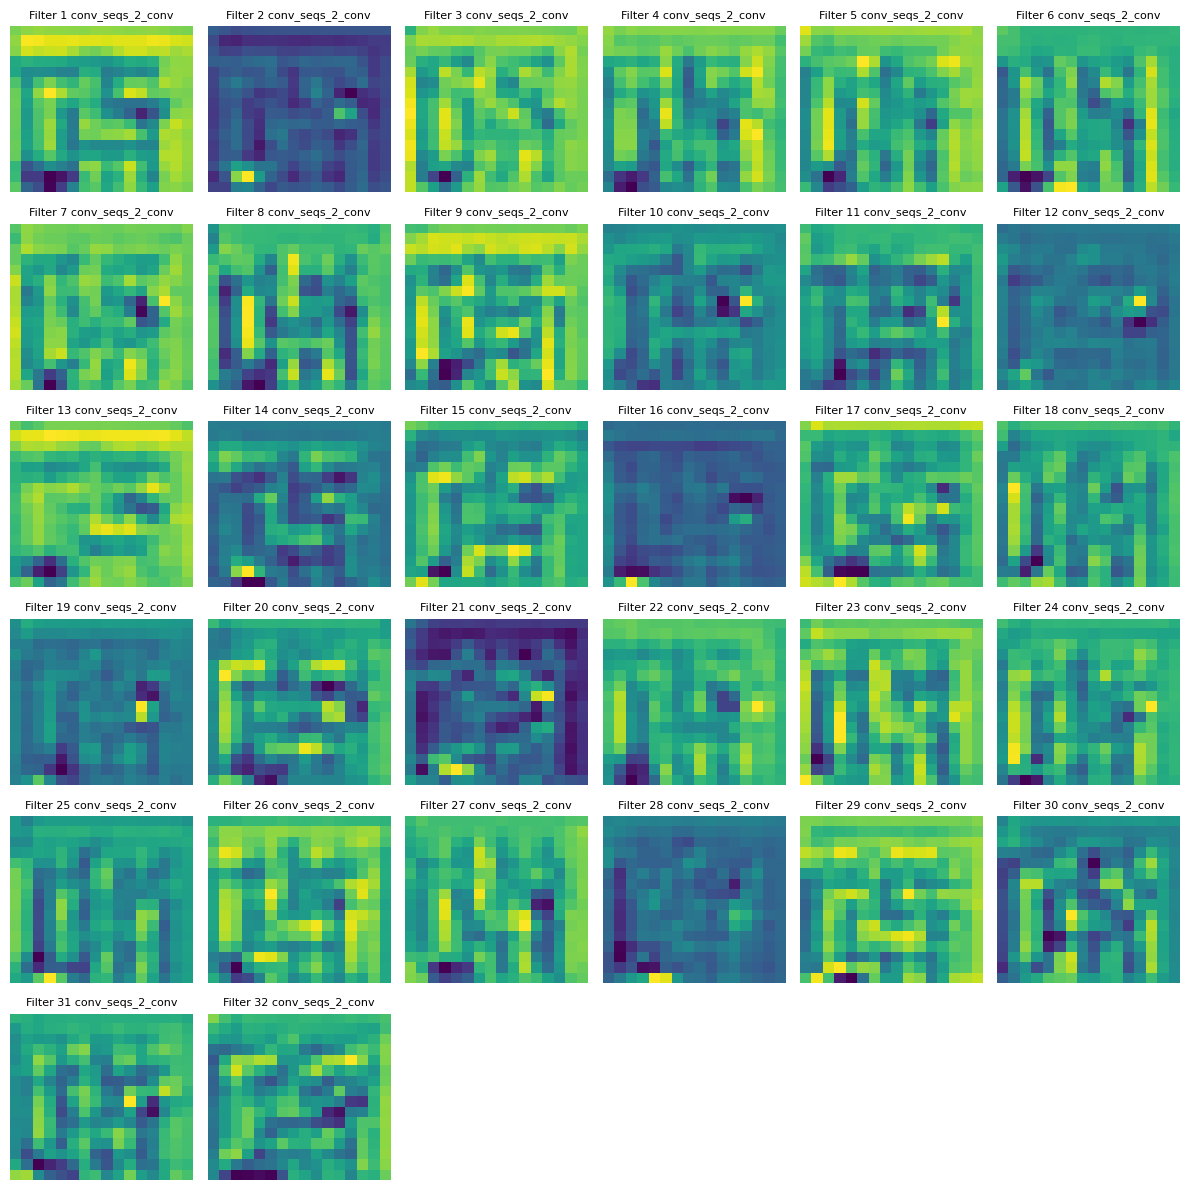

In [ ]:
helpers.plot_activations_for_layers(normal_activations, ['conv_seqs_0_conv', 'conv_seqs_2_conv'])

## Comparing activation differences between gem and blue key


In [ ]:
num_levels = 5
venv = heist.create_venv(num=1, start_level=random.randint(1000, 10000), num_levels=num_levels)
state = heist.state_from_venv(venv, 0)

full_grid = state.full_grid(with_mouse=False)
entities = state.state_vals["ents"]
legal_mouse_positions = heist.get_legal_mouse_positions(full_grid, entities)

unchanged_obs= venv.reset()


state.remove_all_entities()

entities = state.state_vals["ents"]
target_x, target_y = heist.get_legal_mouse_positions(full_grid, entities)[random.randint(0, len(legal_mouse_positions) - 1)]
state.set_key_position(0,target_x,target_y) 
entities = state.state_vals["ents"]
x, y = heist.get_legal_mouse_positions(full_grid, entities)[random.randint(0, len(legal_mouse_positions) - 1)]
state.set_mouse_pos(x,y)
state_bytes = state.state_bytes
if state_bytes is not None:
    venv.env.callmethod("set_state", [state_bytes])
    obs = venv.reset()

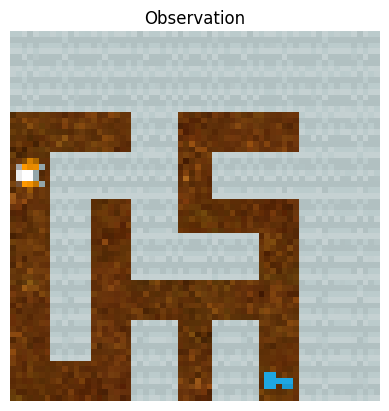

In [ ]:
# obs = venv.reset()
helpers.plot_single_observation(obs.squeeze().transpose(1,2,0))


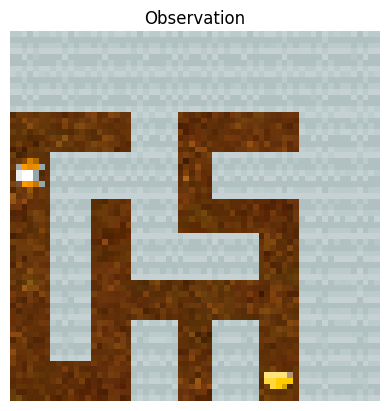

In [ ]:
state.remove_all_entities()
state.set_mouse_pos(x,y)
state.set_gem_position(target_x,target_y)
state_bytes = state.state_bytes
if state_bytes is not None:
    venv2 = venv
    venv2.env.callmethod("set_state", [state_bytes])
    obs2 = venv2.reset()

helpers.plot_single_observation(obs2.squeeze().transpose(1,2,0))

In [ ]:

output, key_activations = model_activations.run_with_cache(helpers.observation_to_rgb(obs.squeeze().transpose(1,2,0)), layer_paths)
output, gem_activations = model_activations.run_with_cache(helpers.observation_to_rgb(obs2.squeeze().transpose(1,2,0)), layer_paths)


torch.Size([64, 64, 3])
torch.Size([64, 64, 3])


In [ ]:
obs.squeeze().transpose(1,2,0).shape

(64, 64, 3)

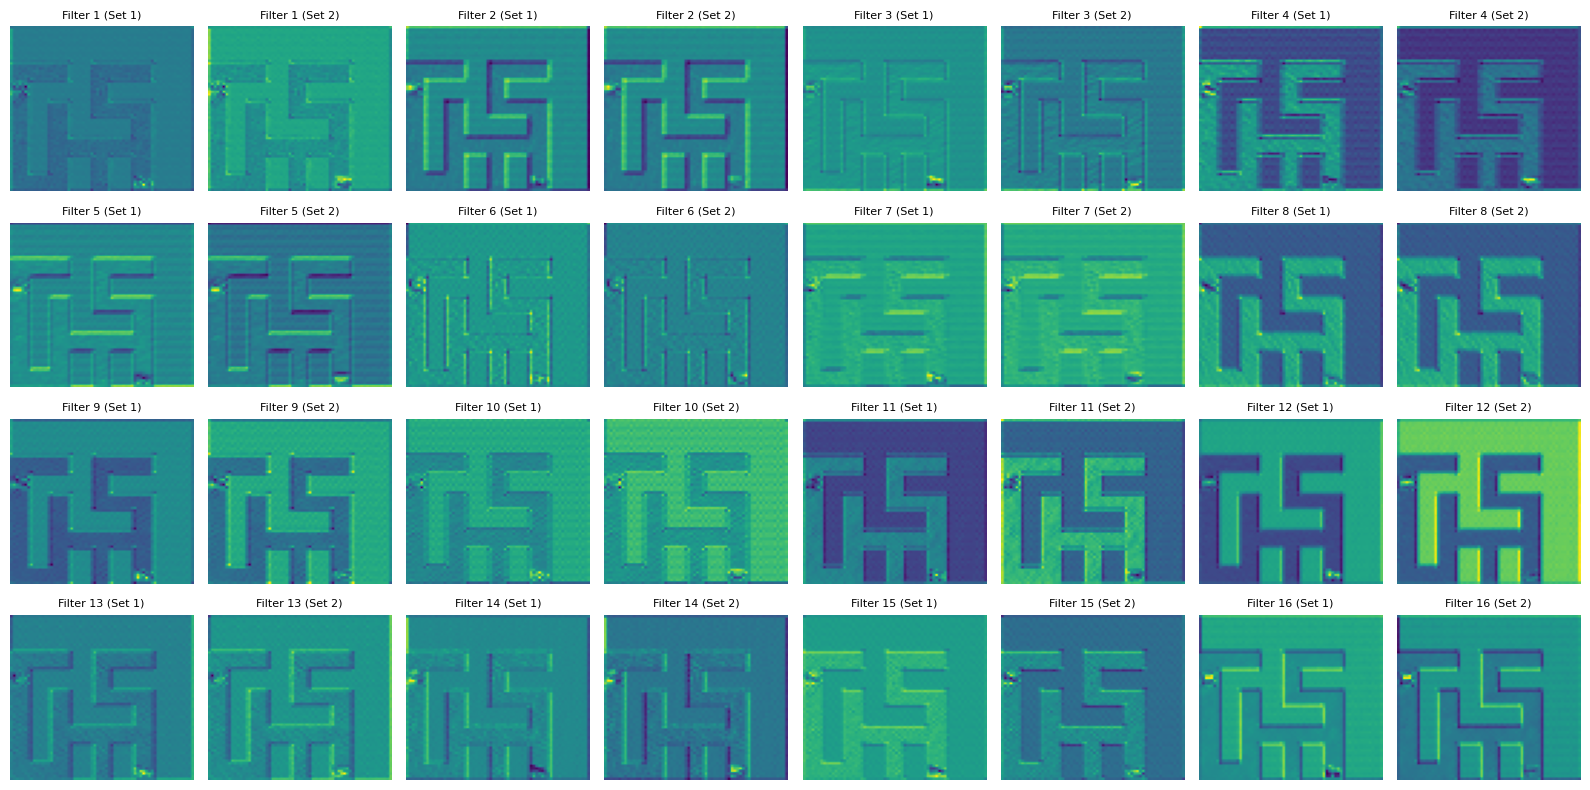

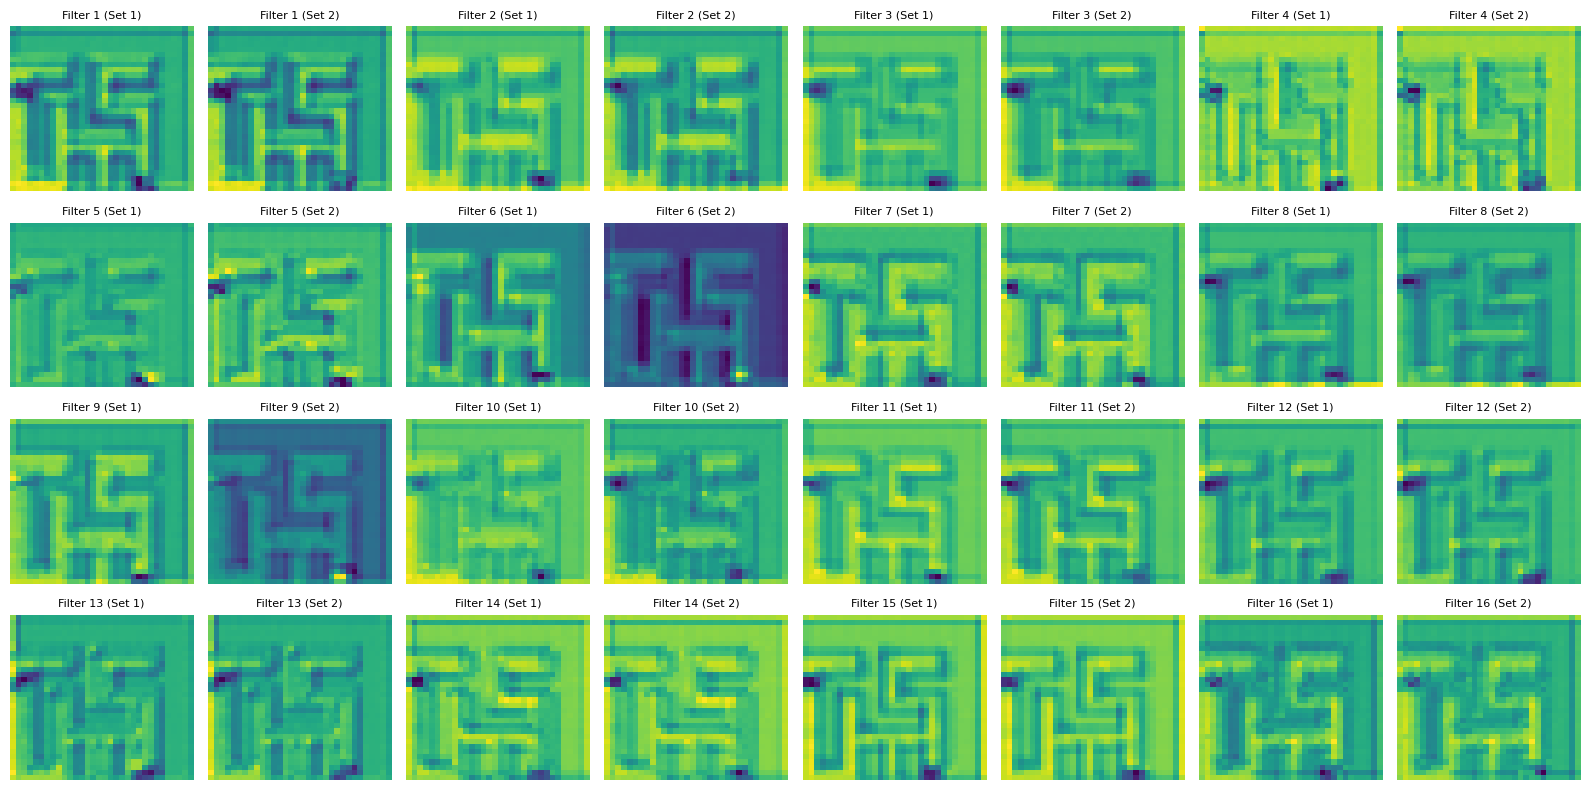

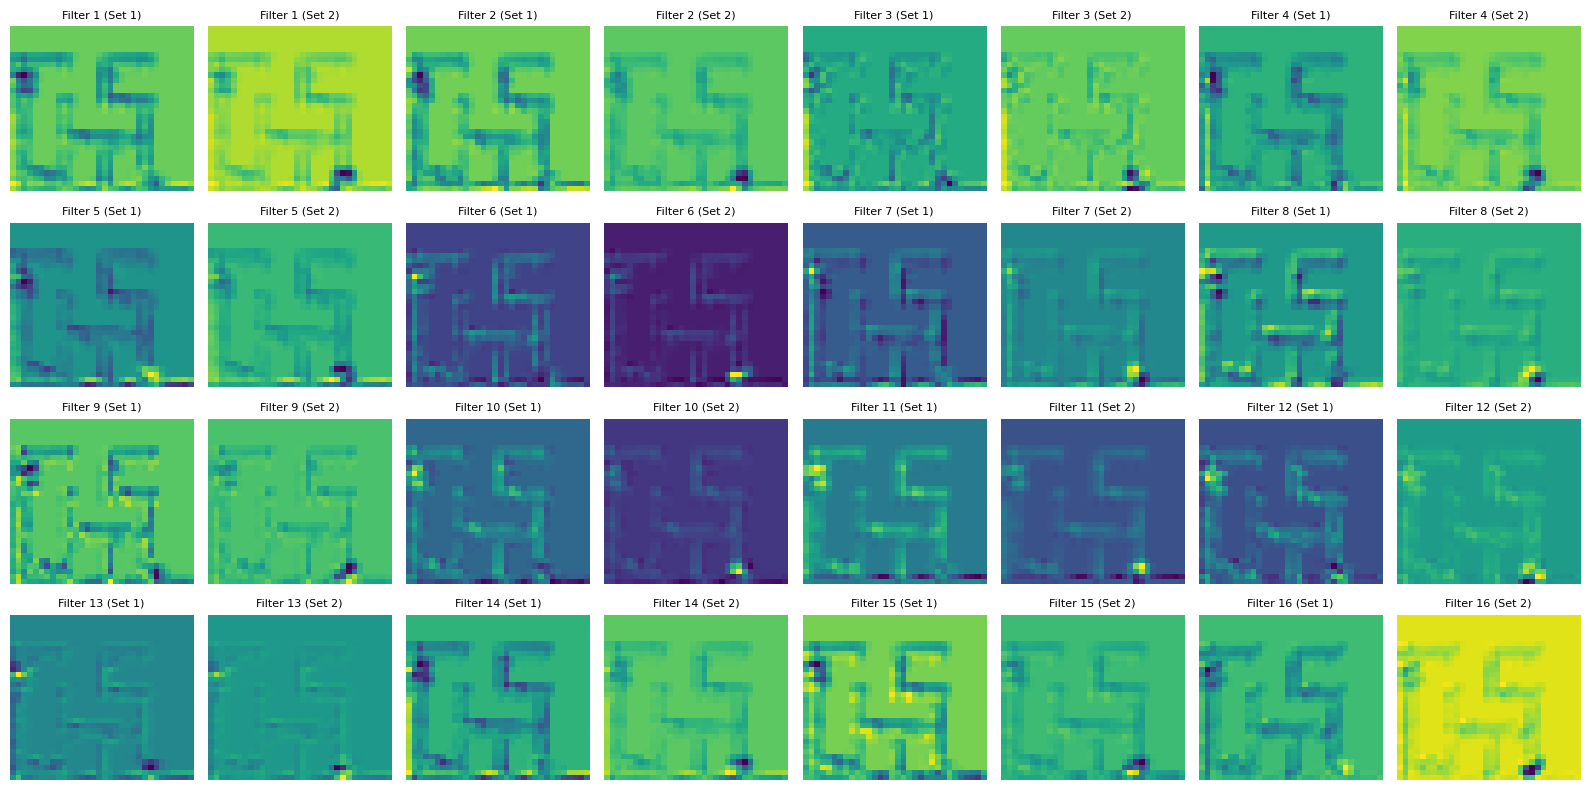

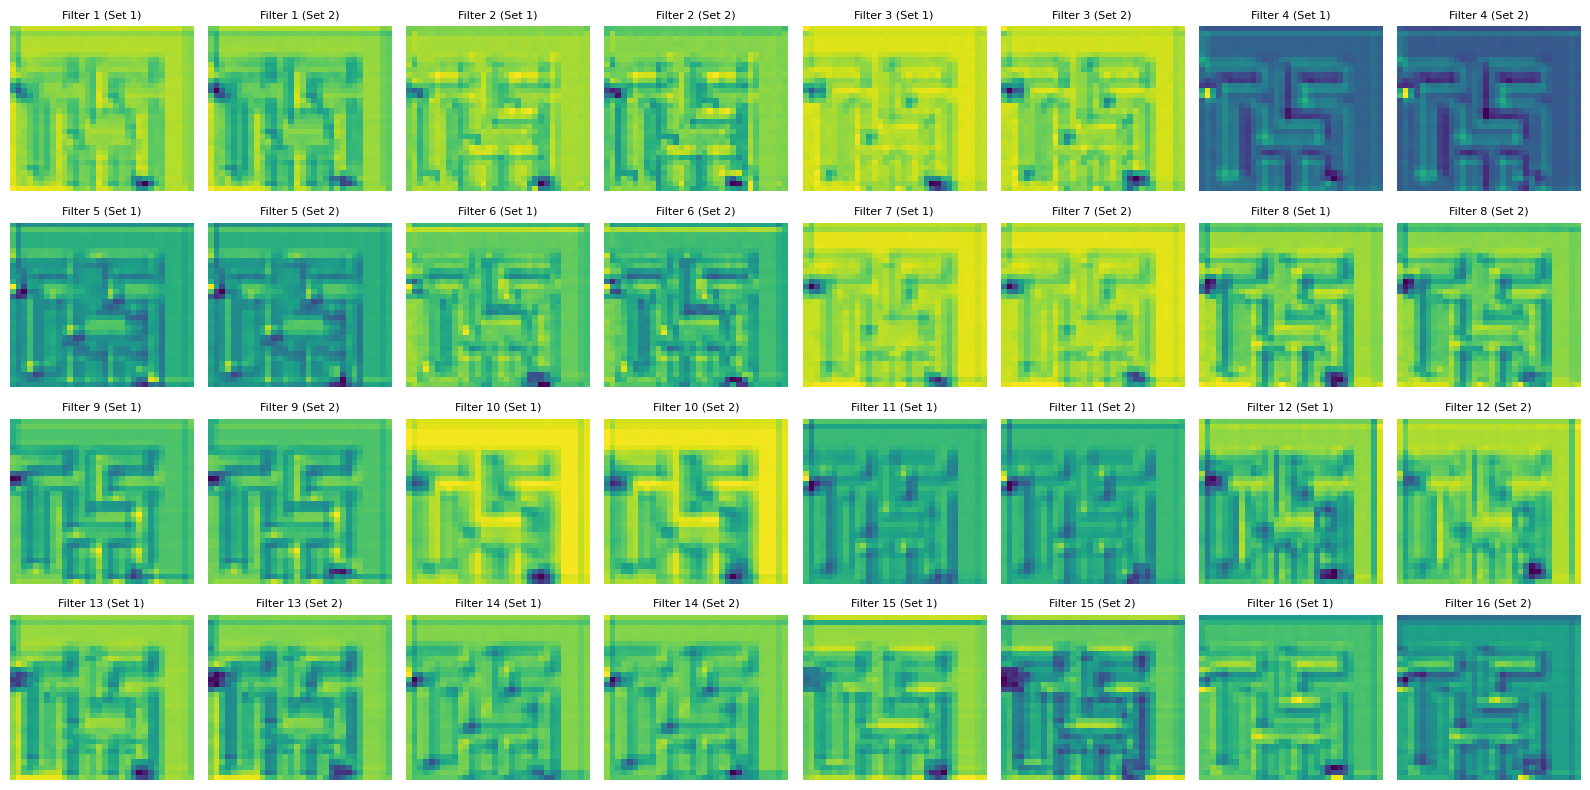

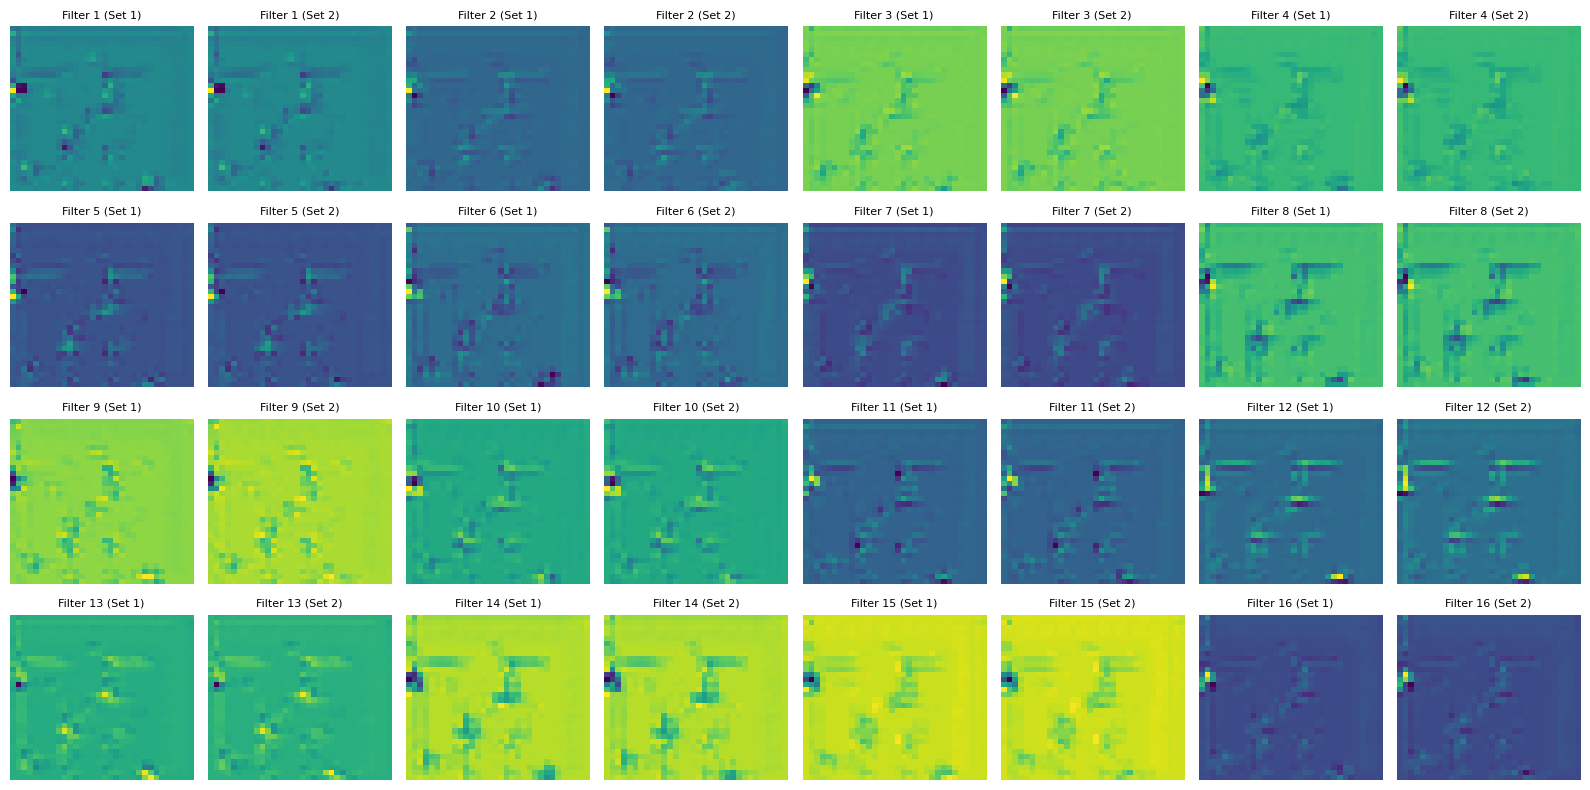

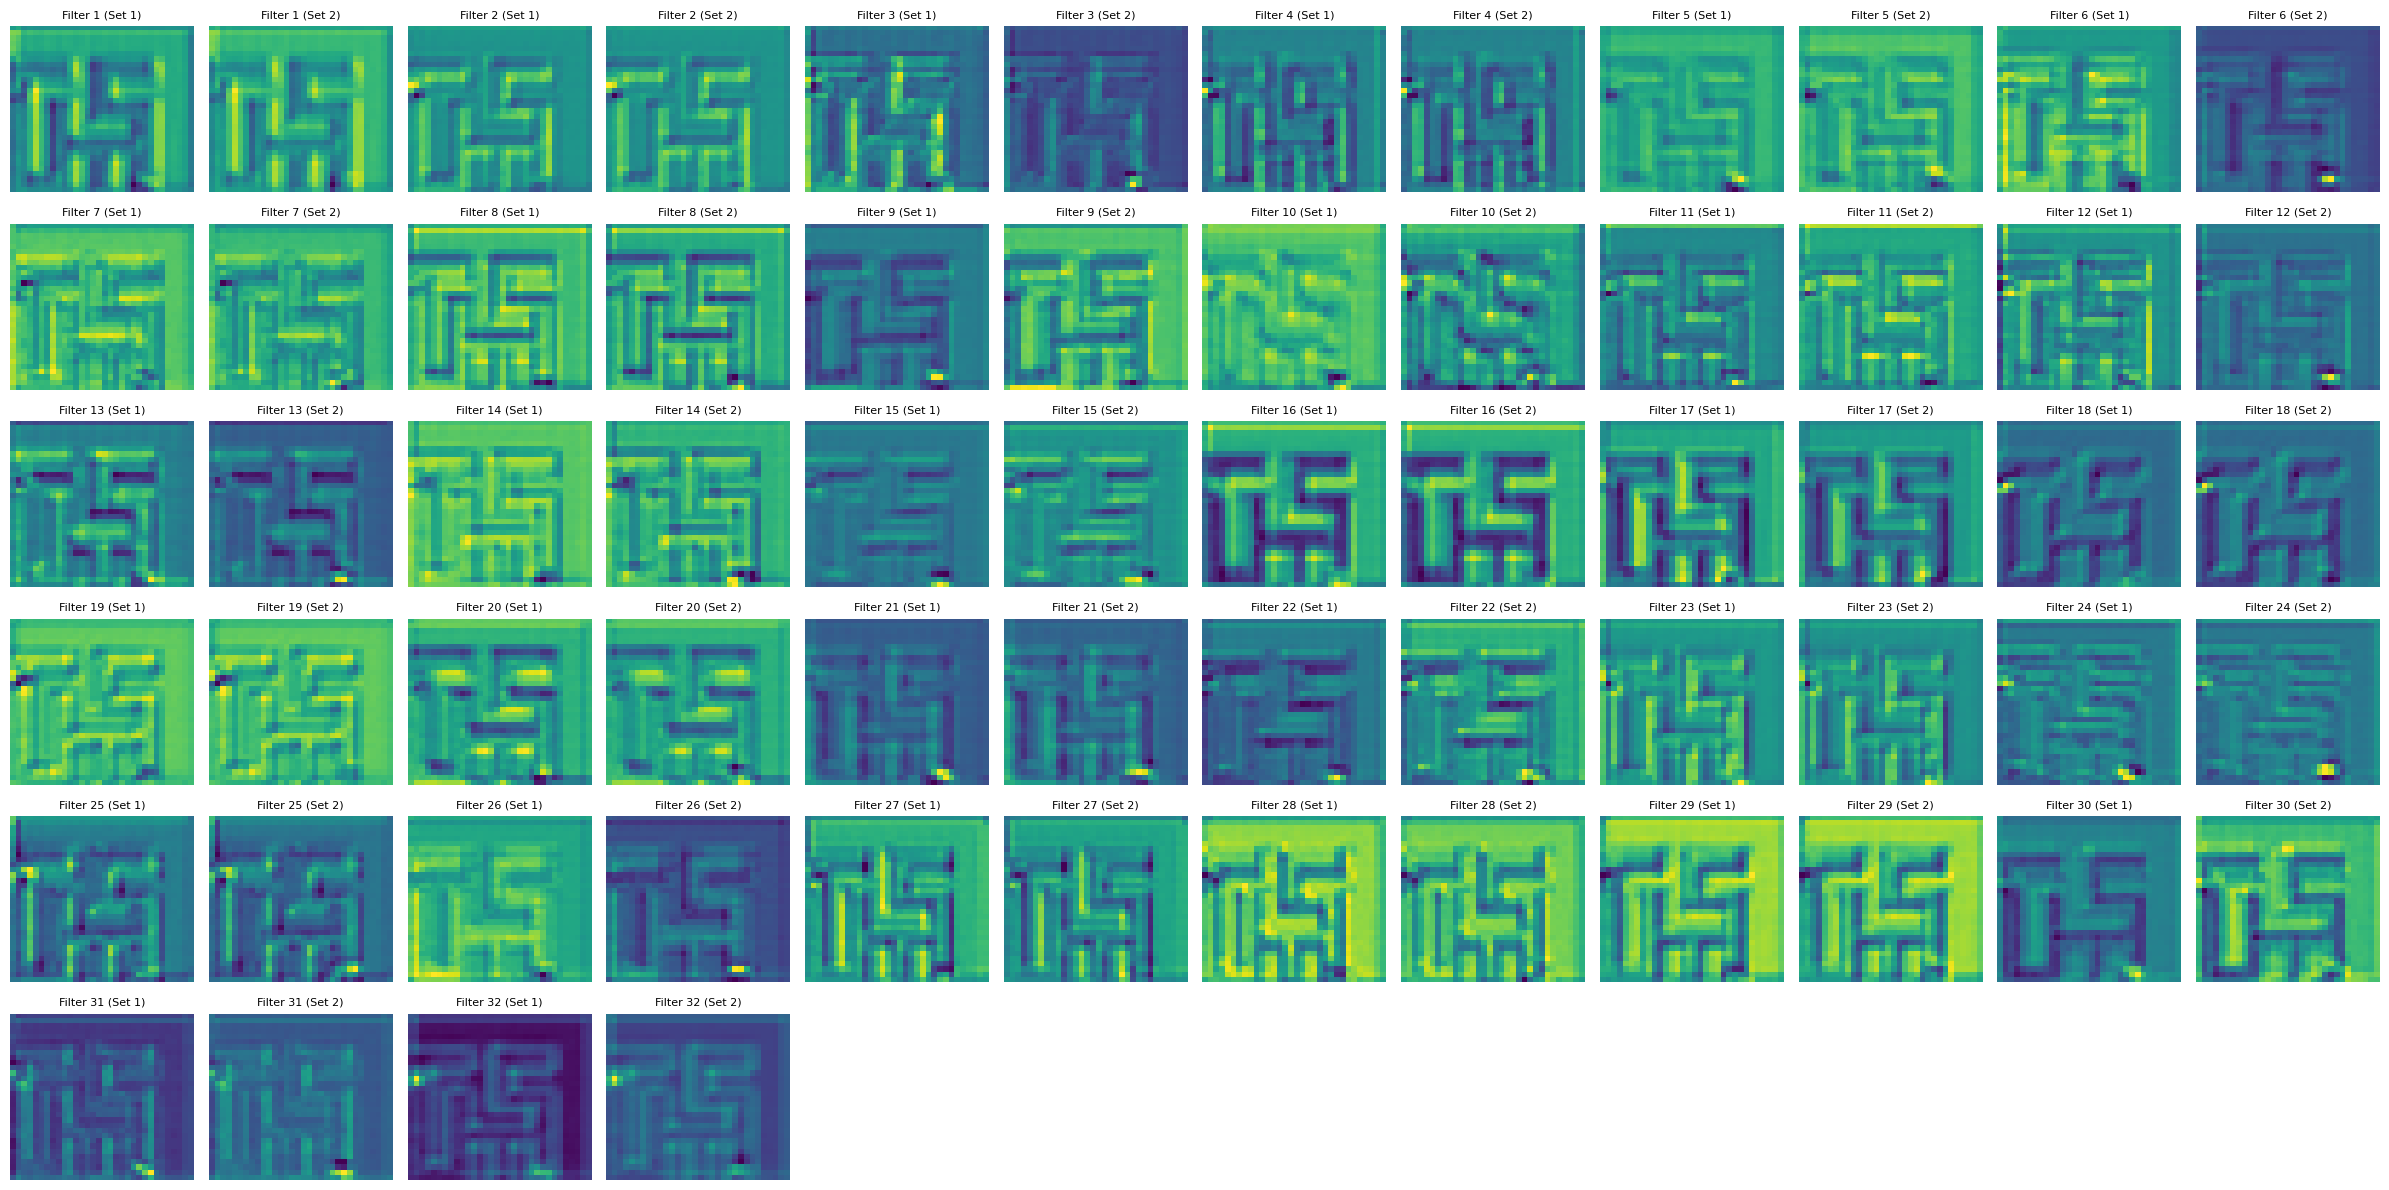

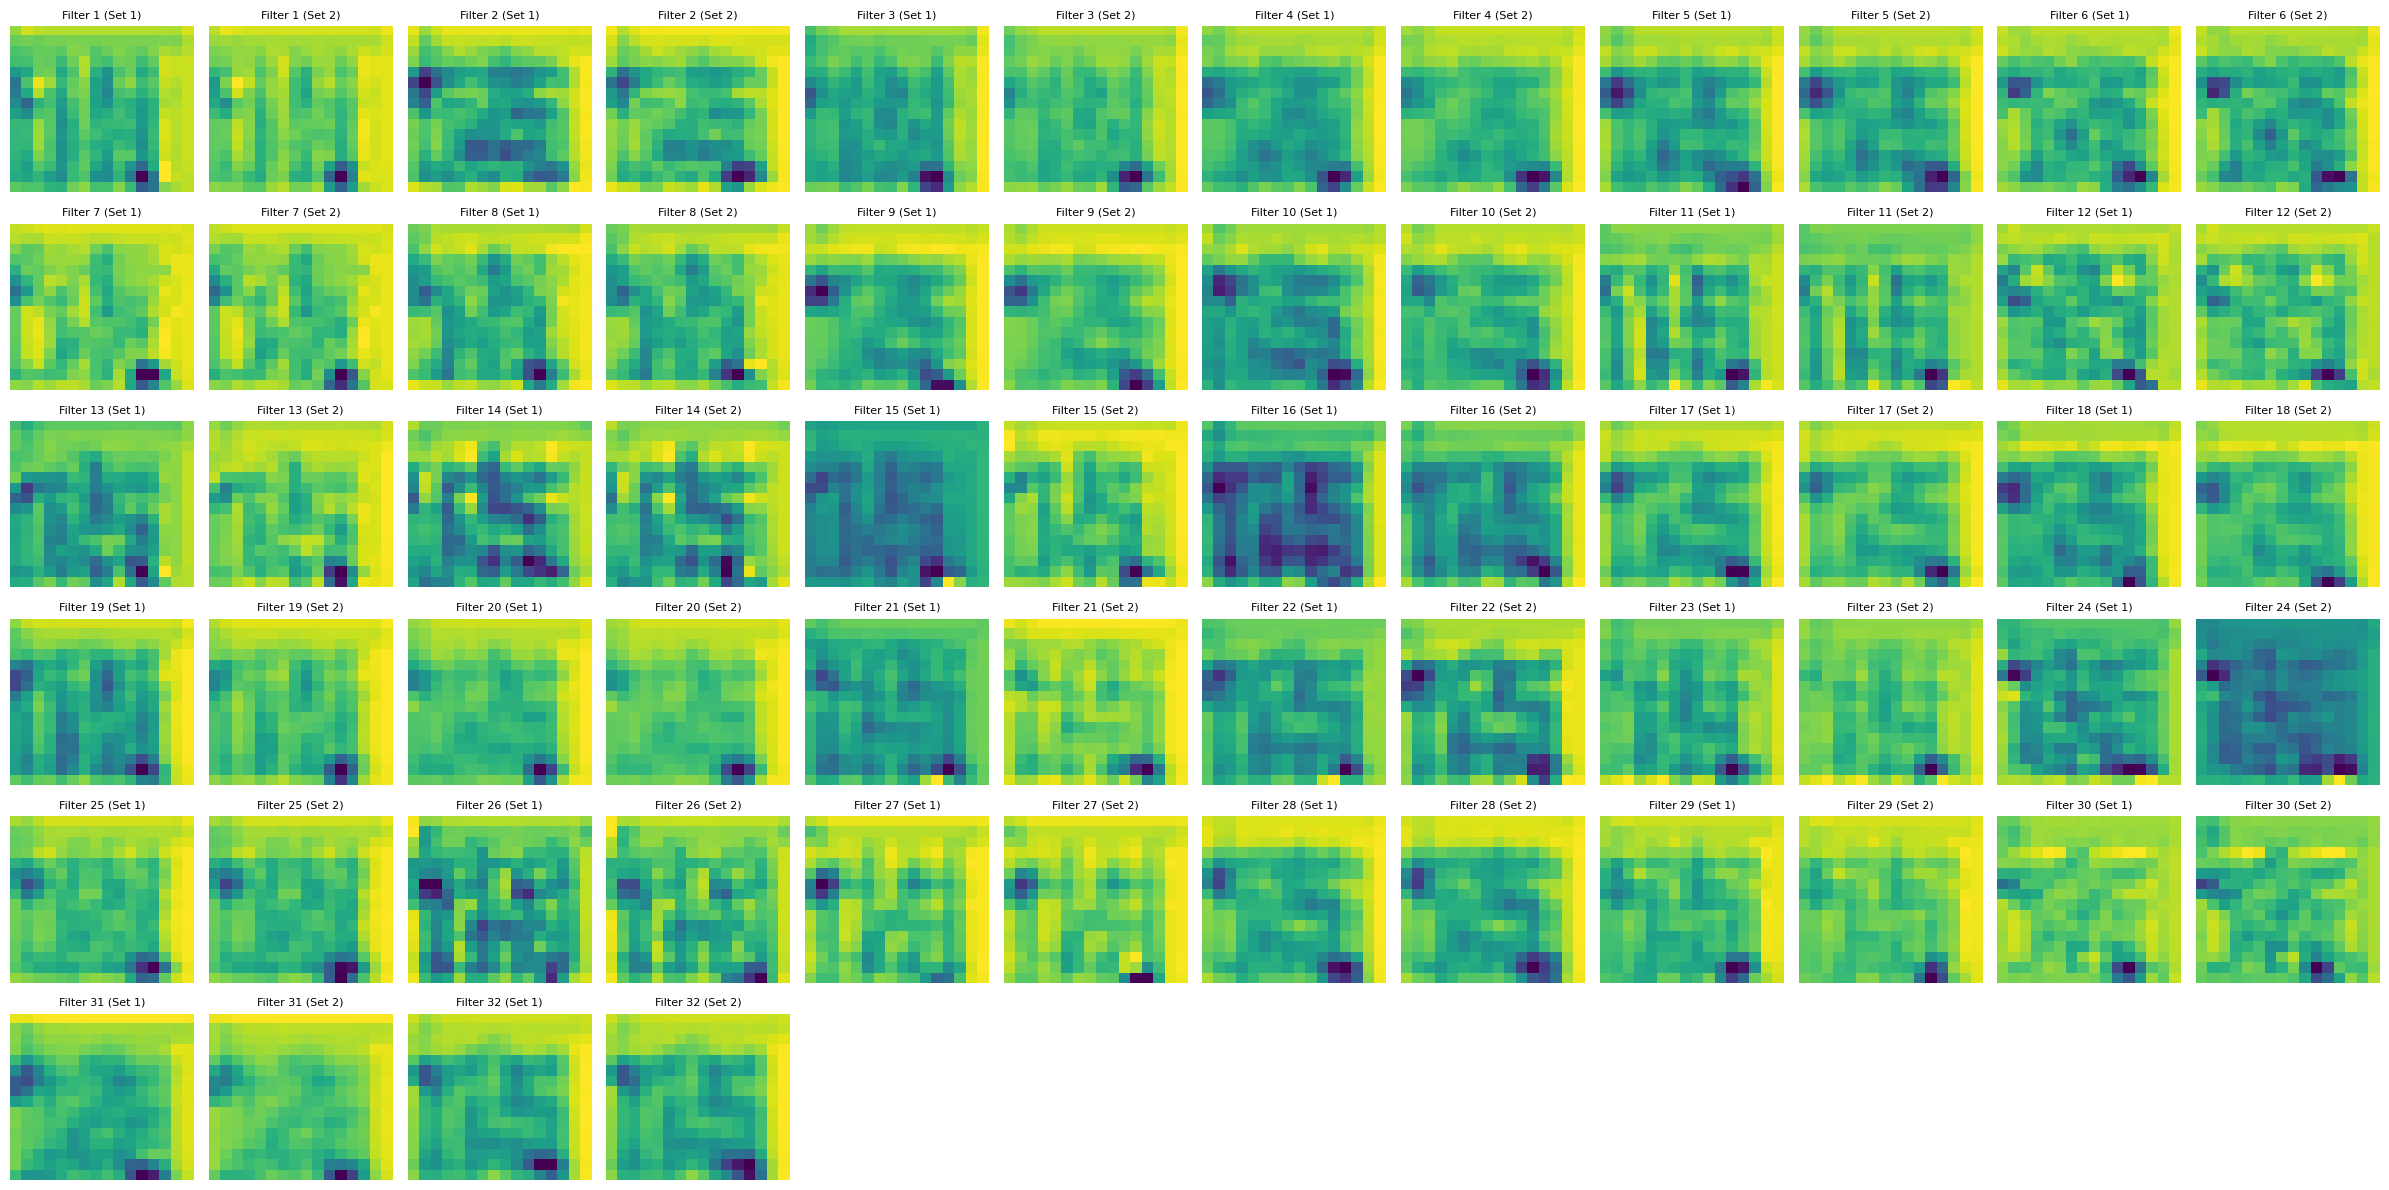

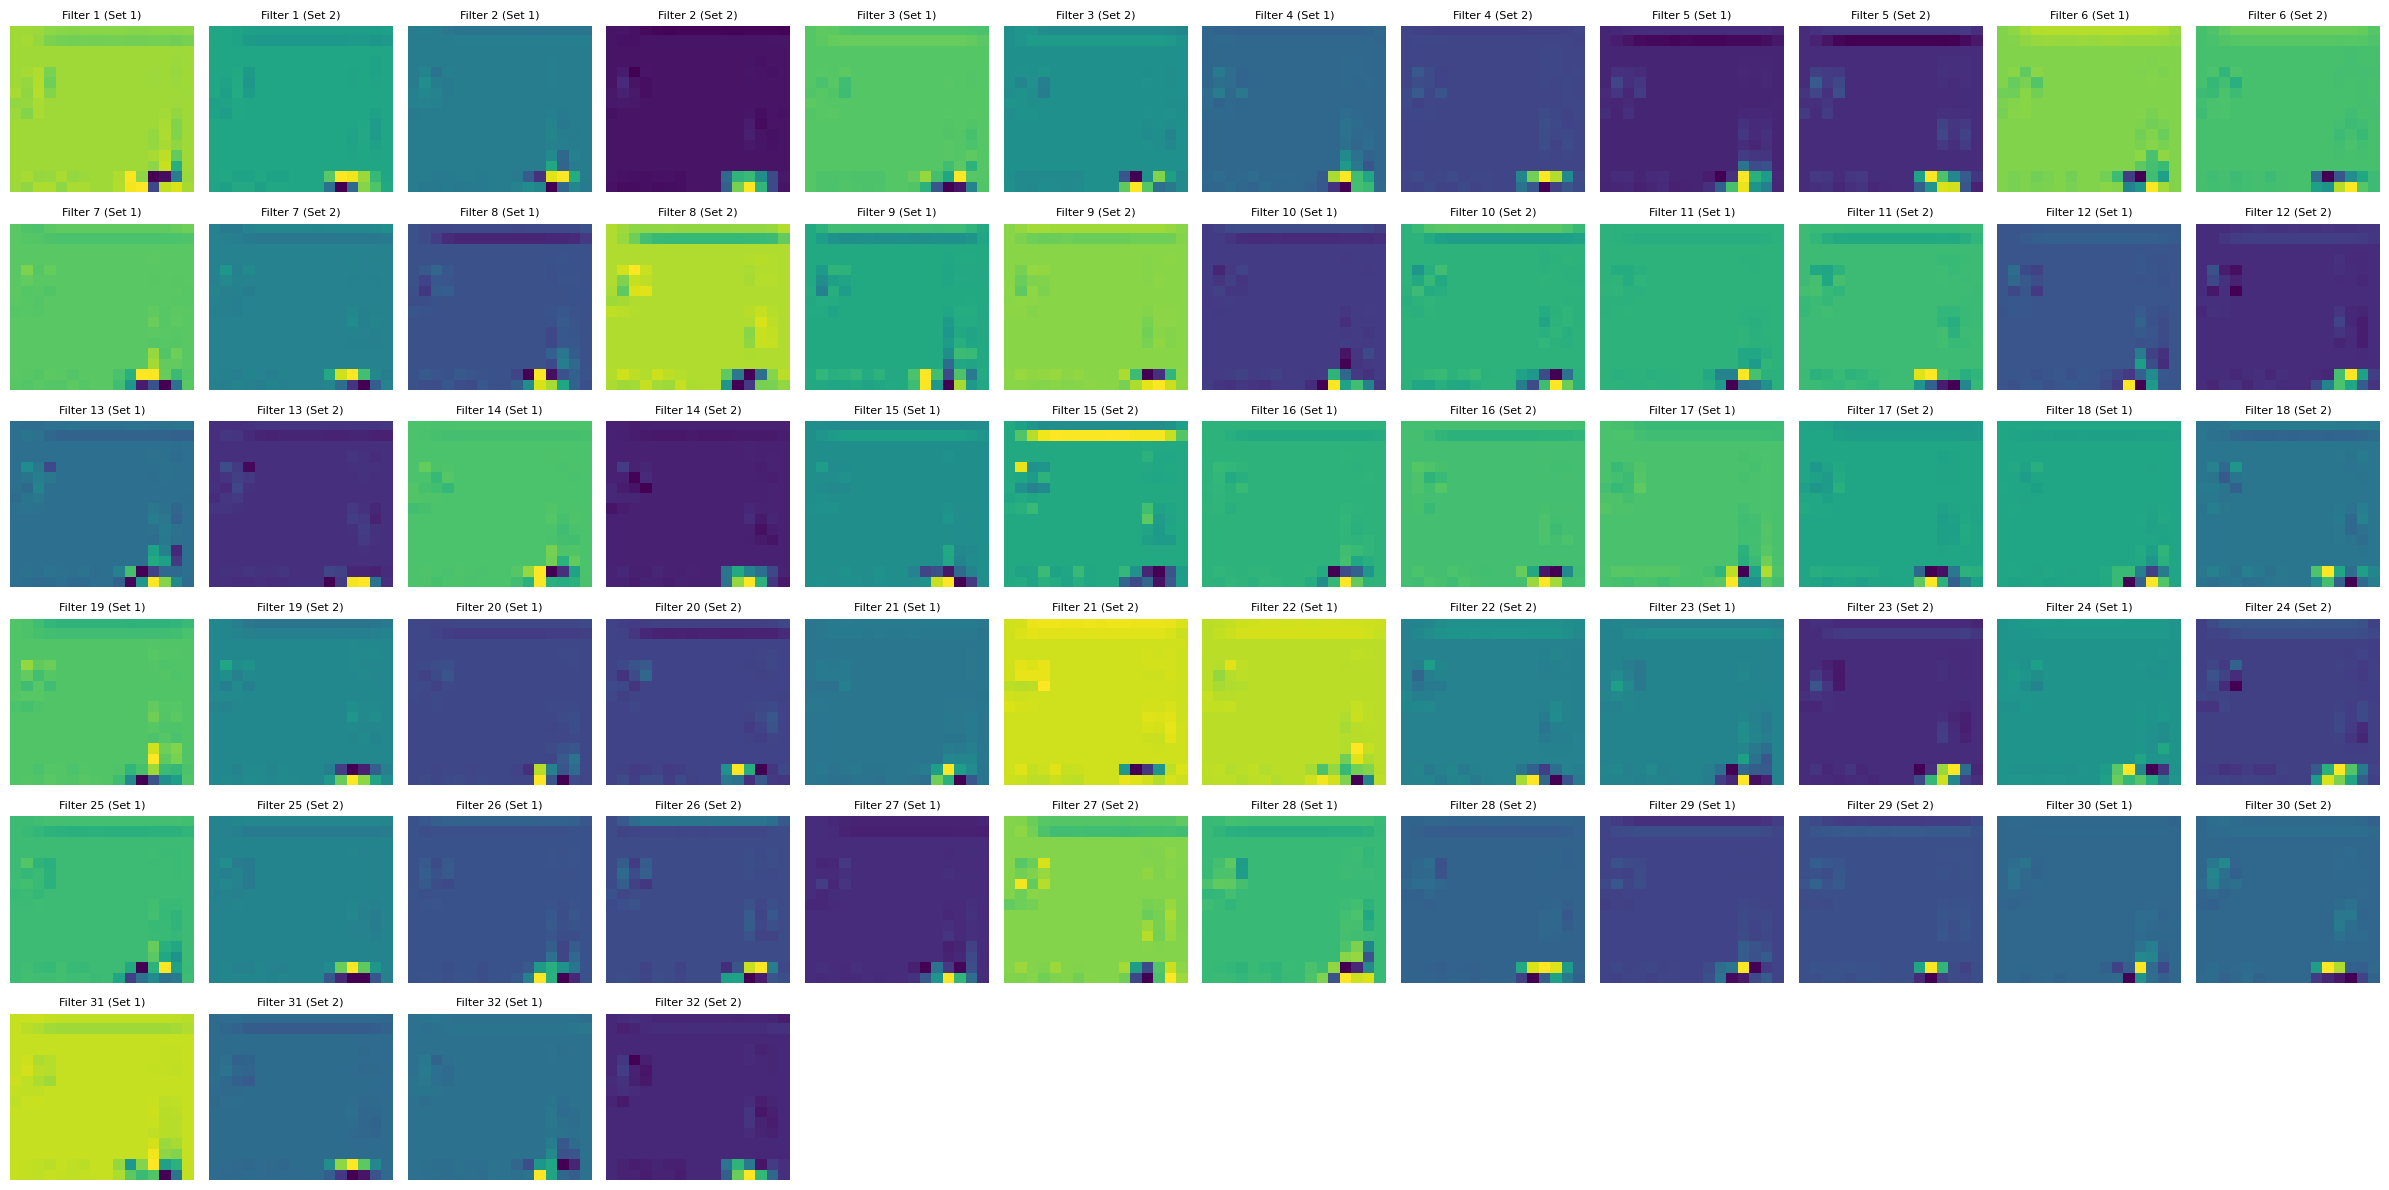

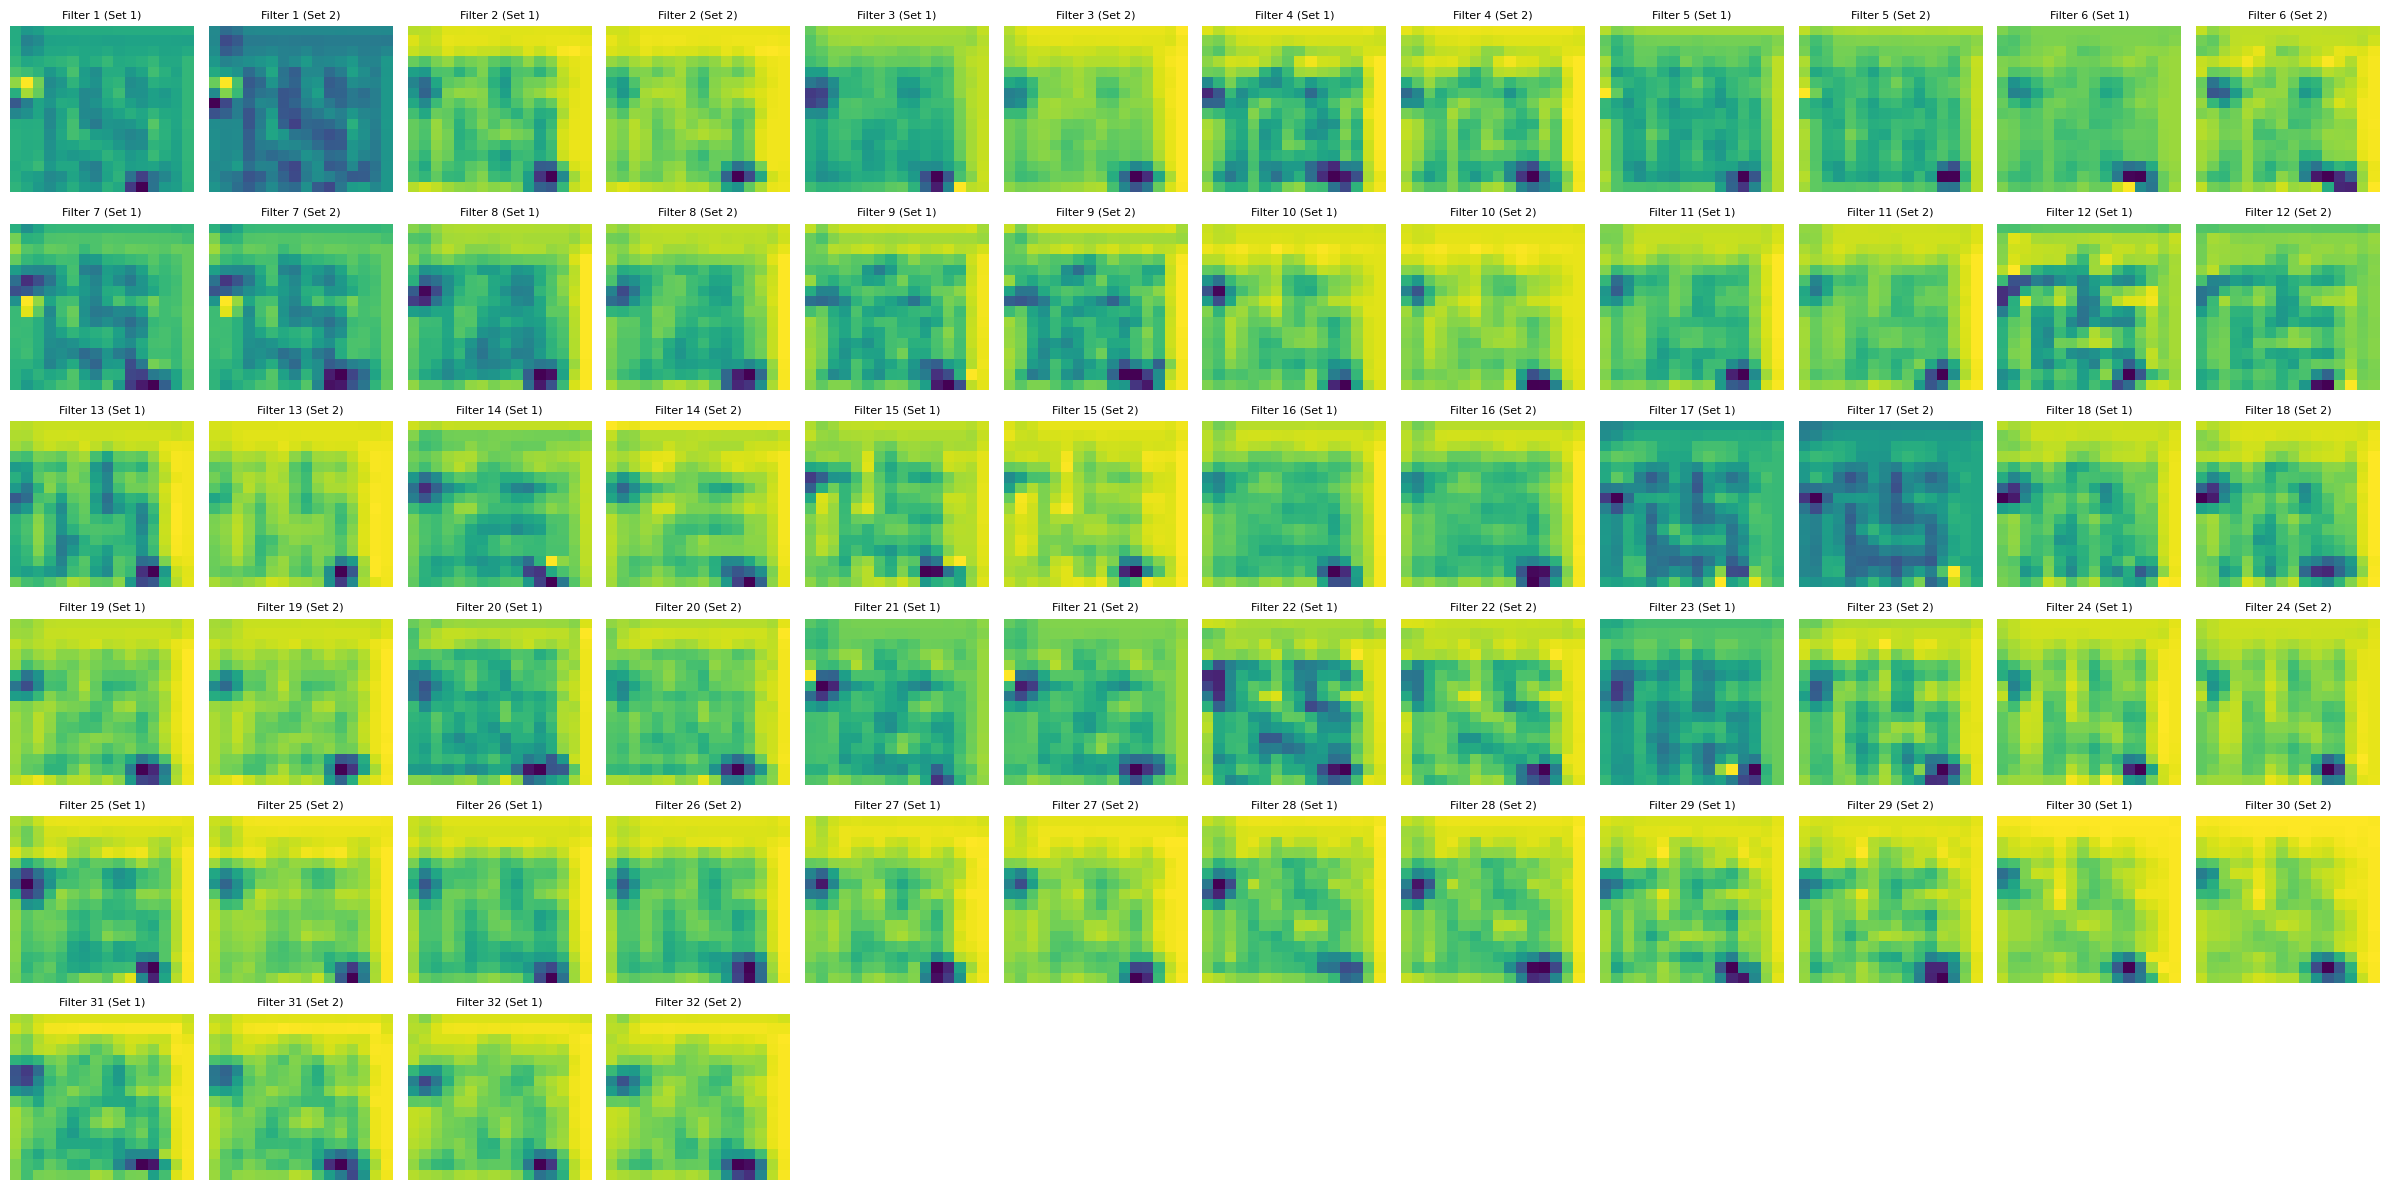

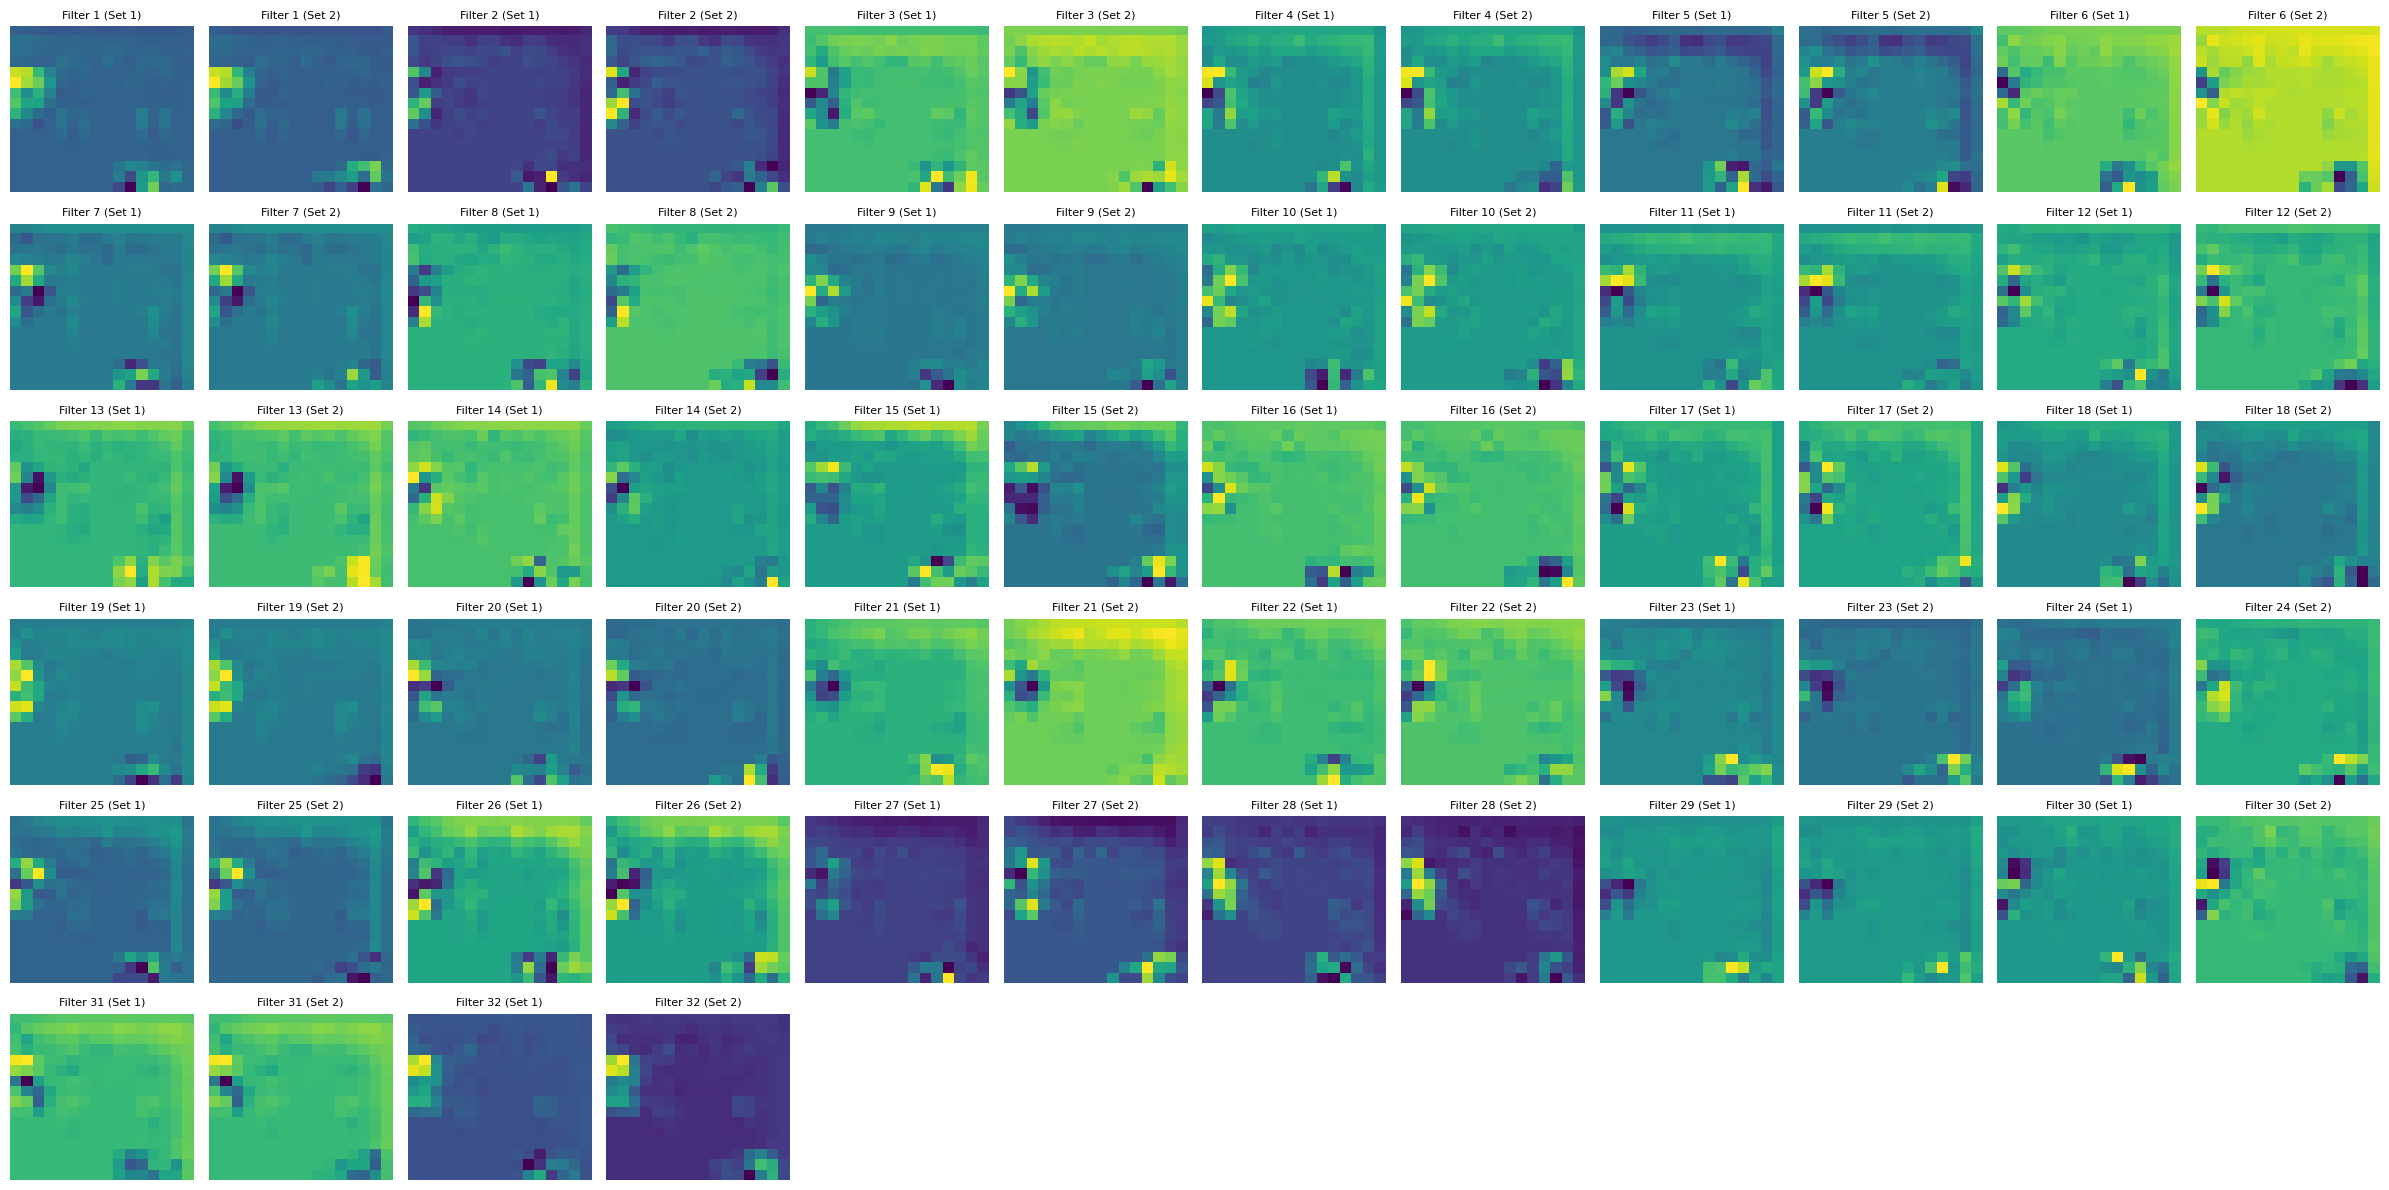

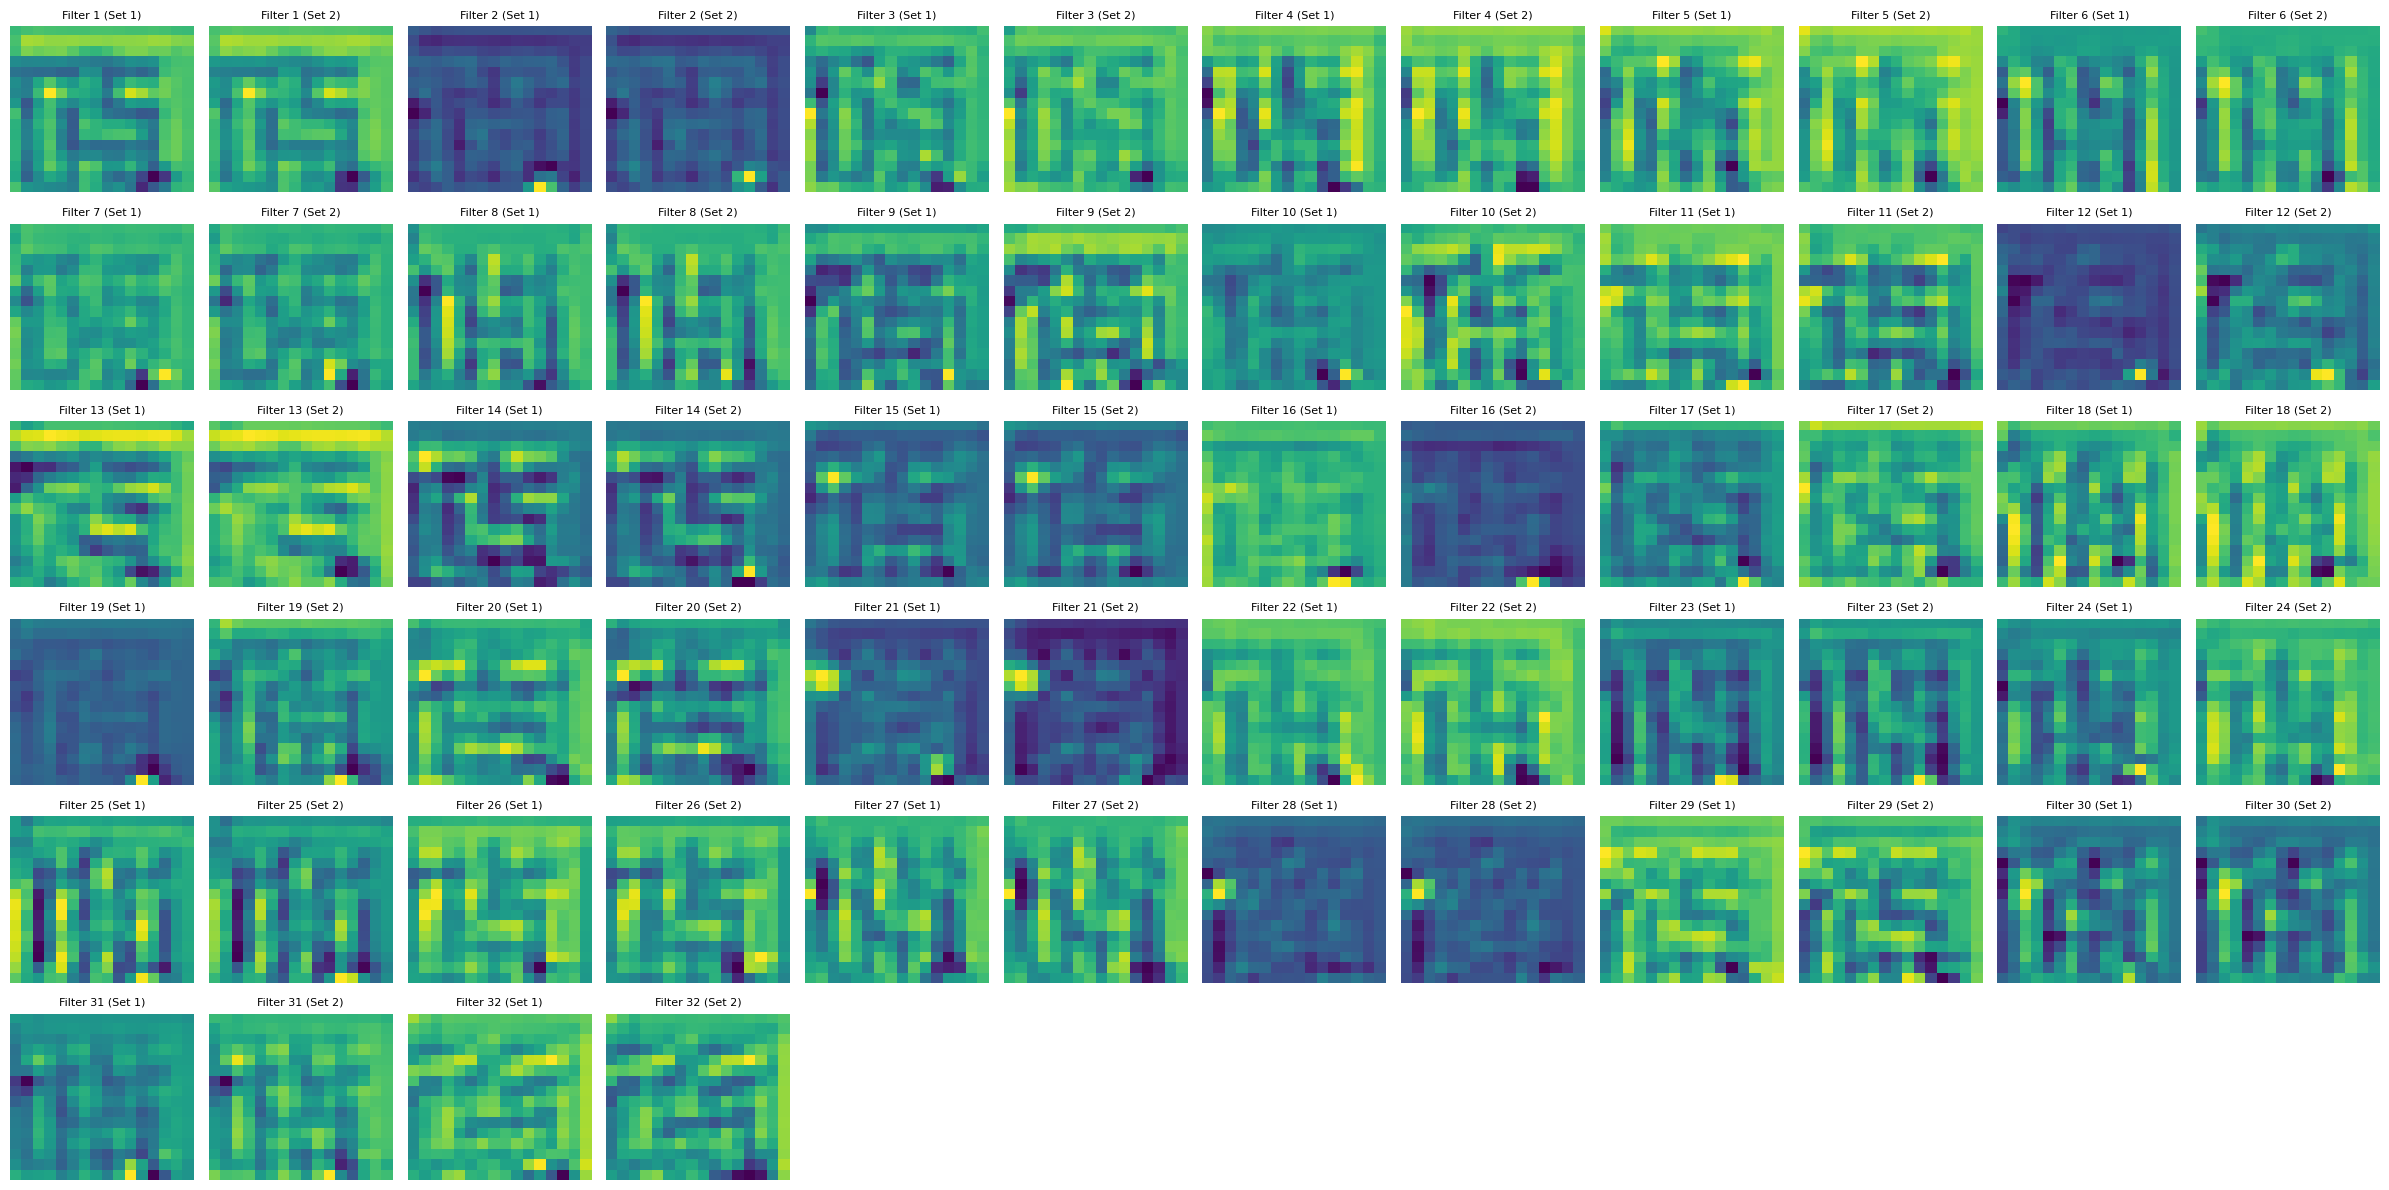

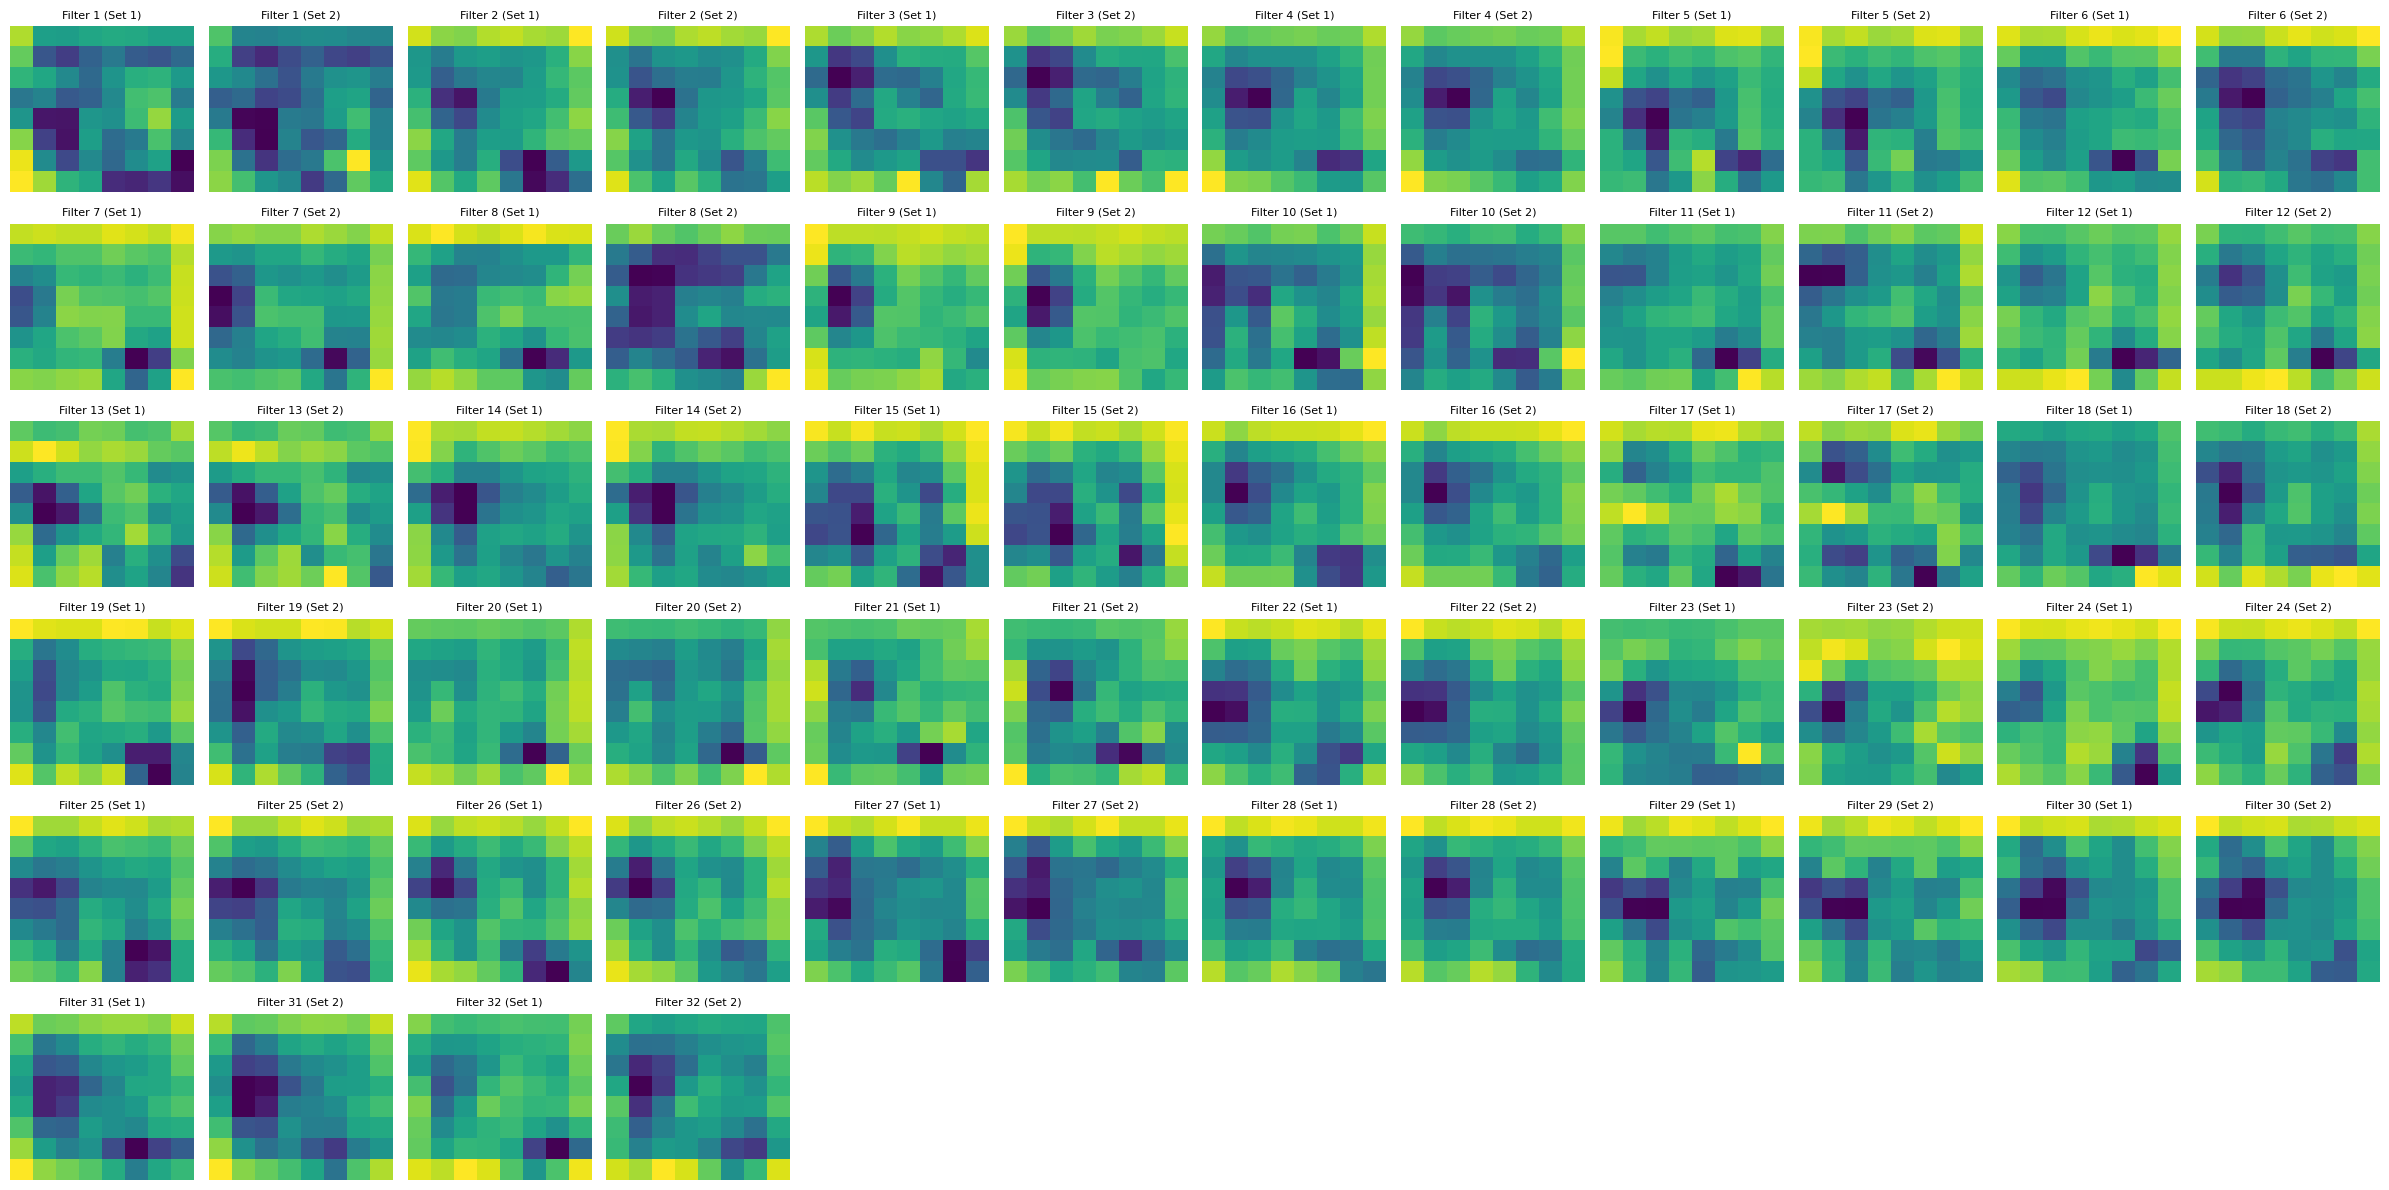

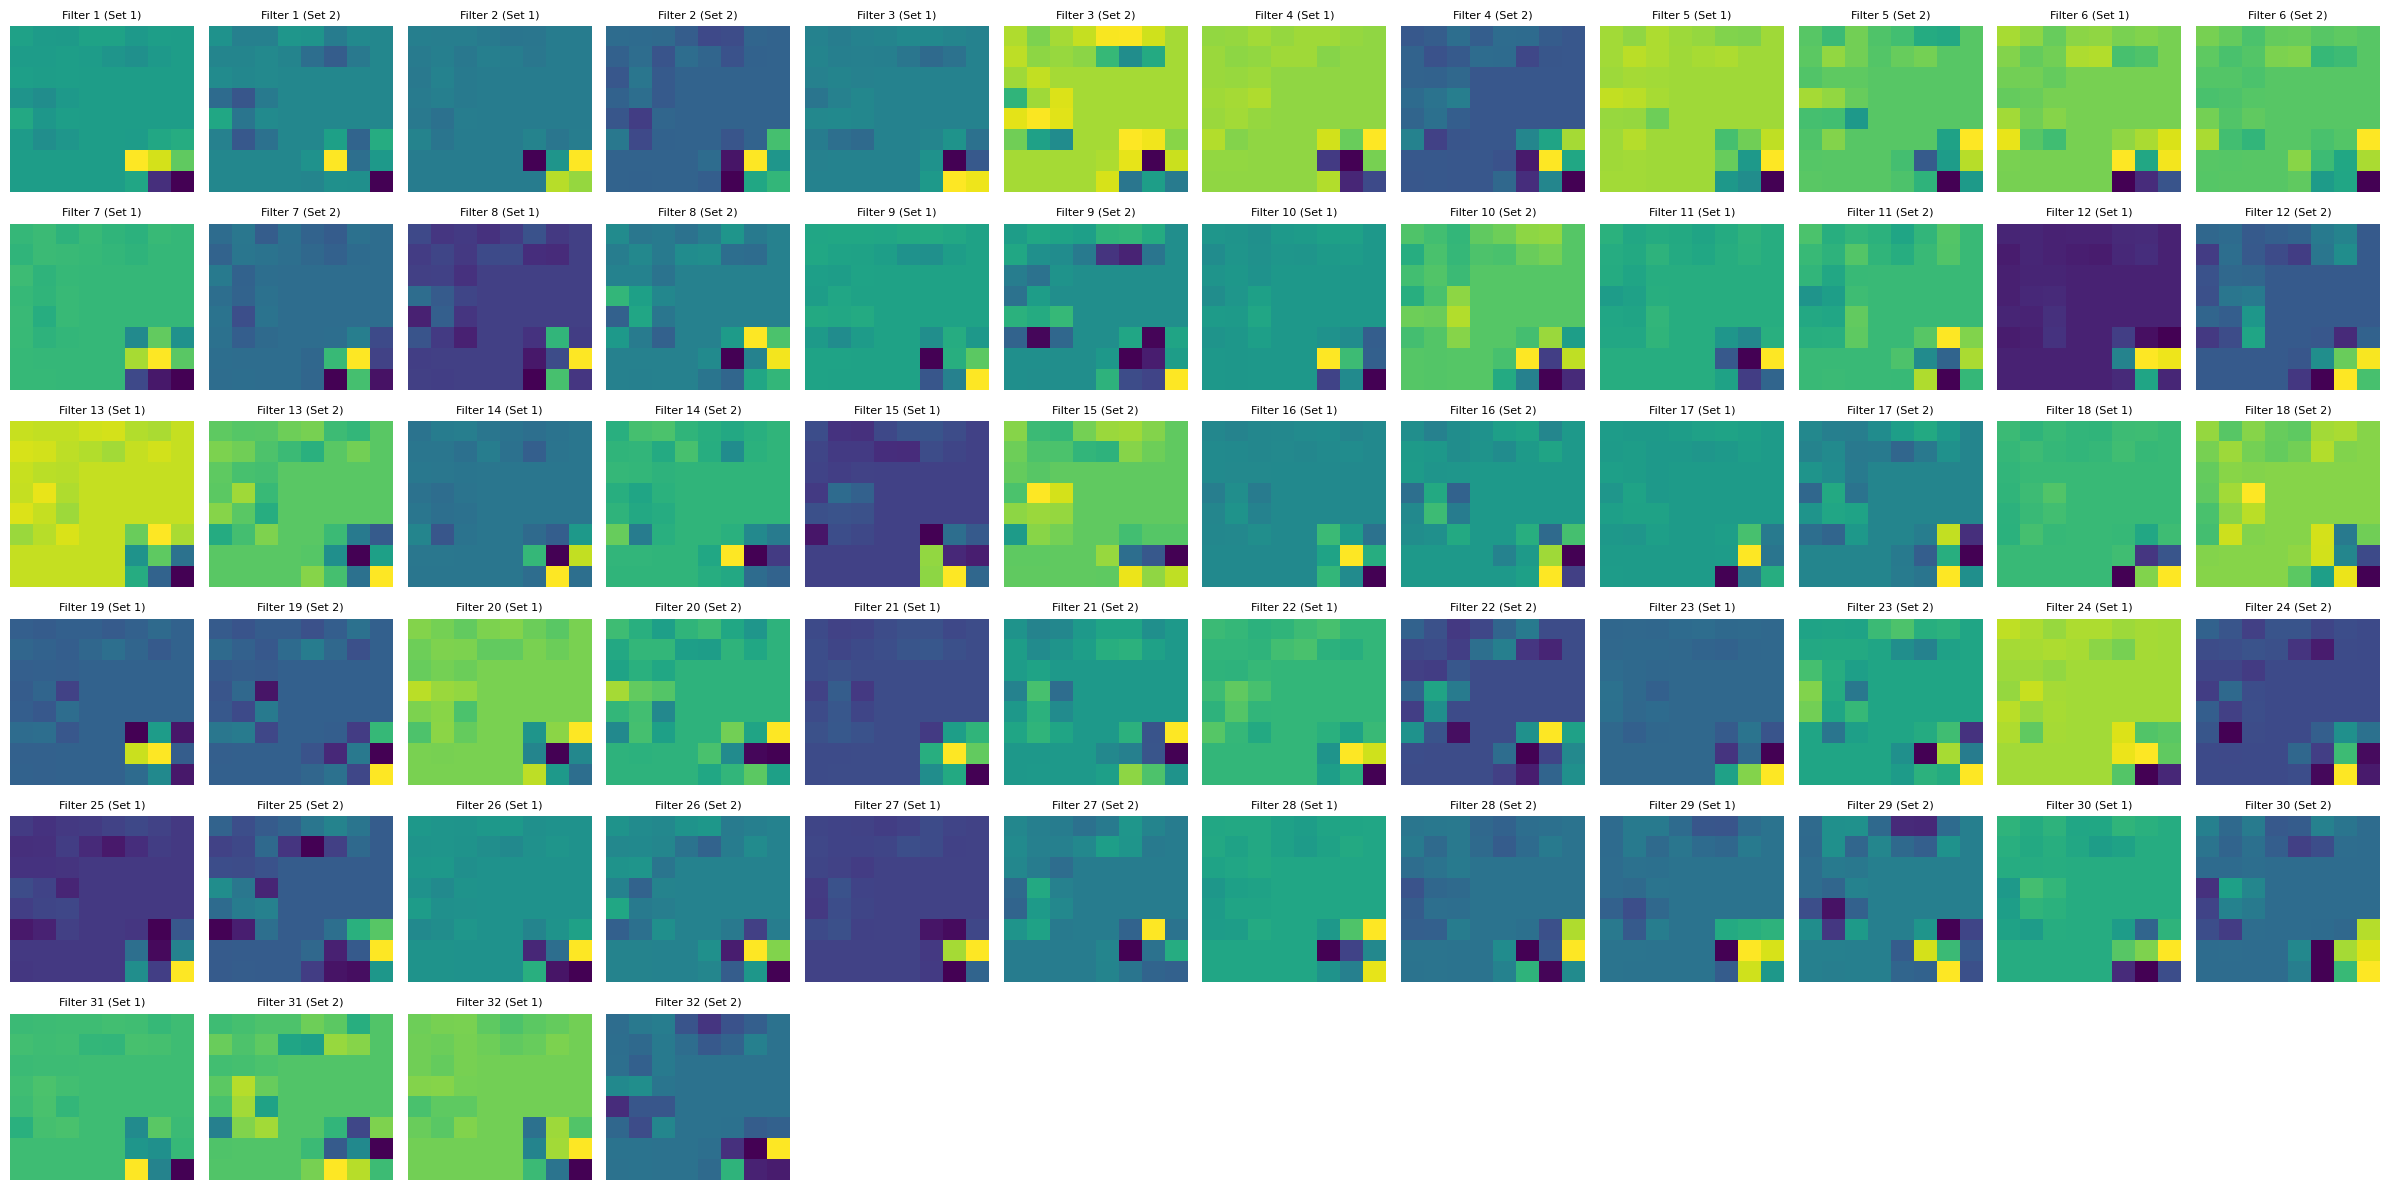

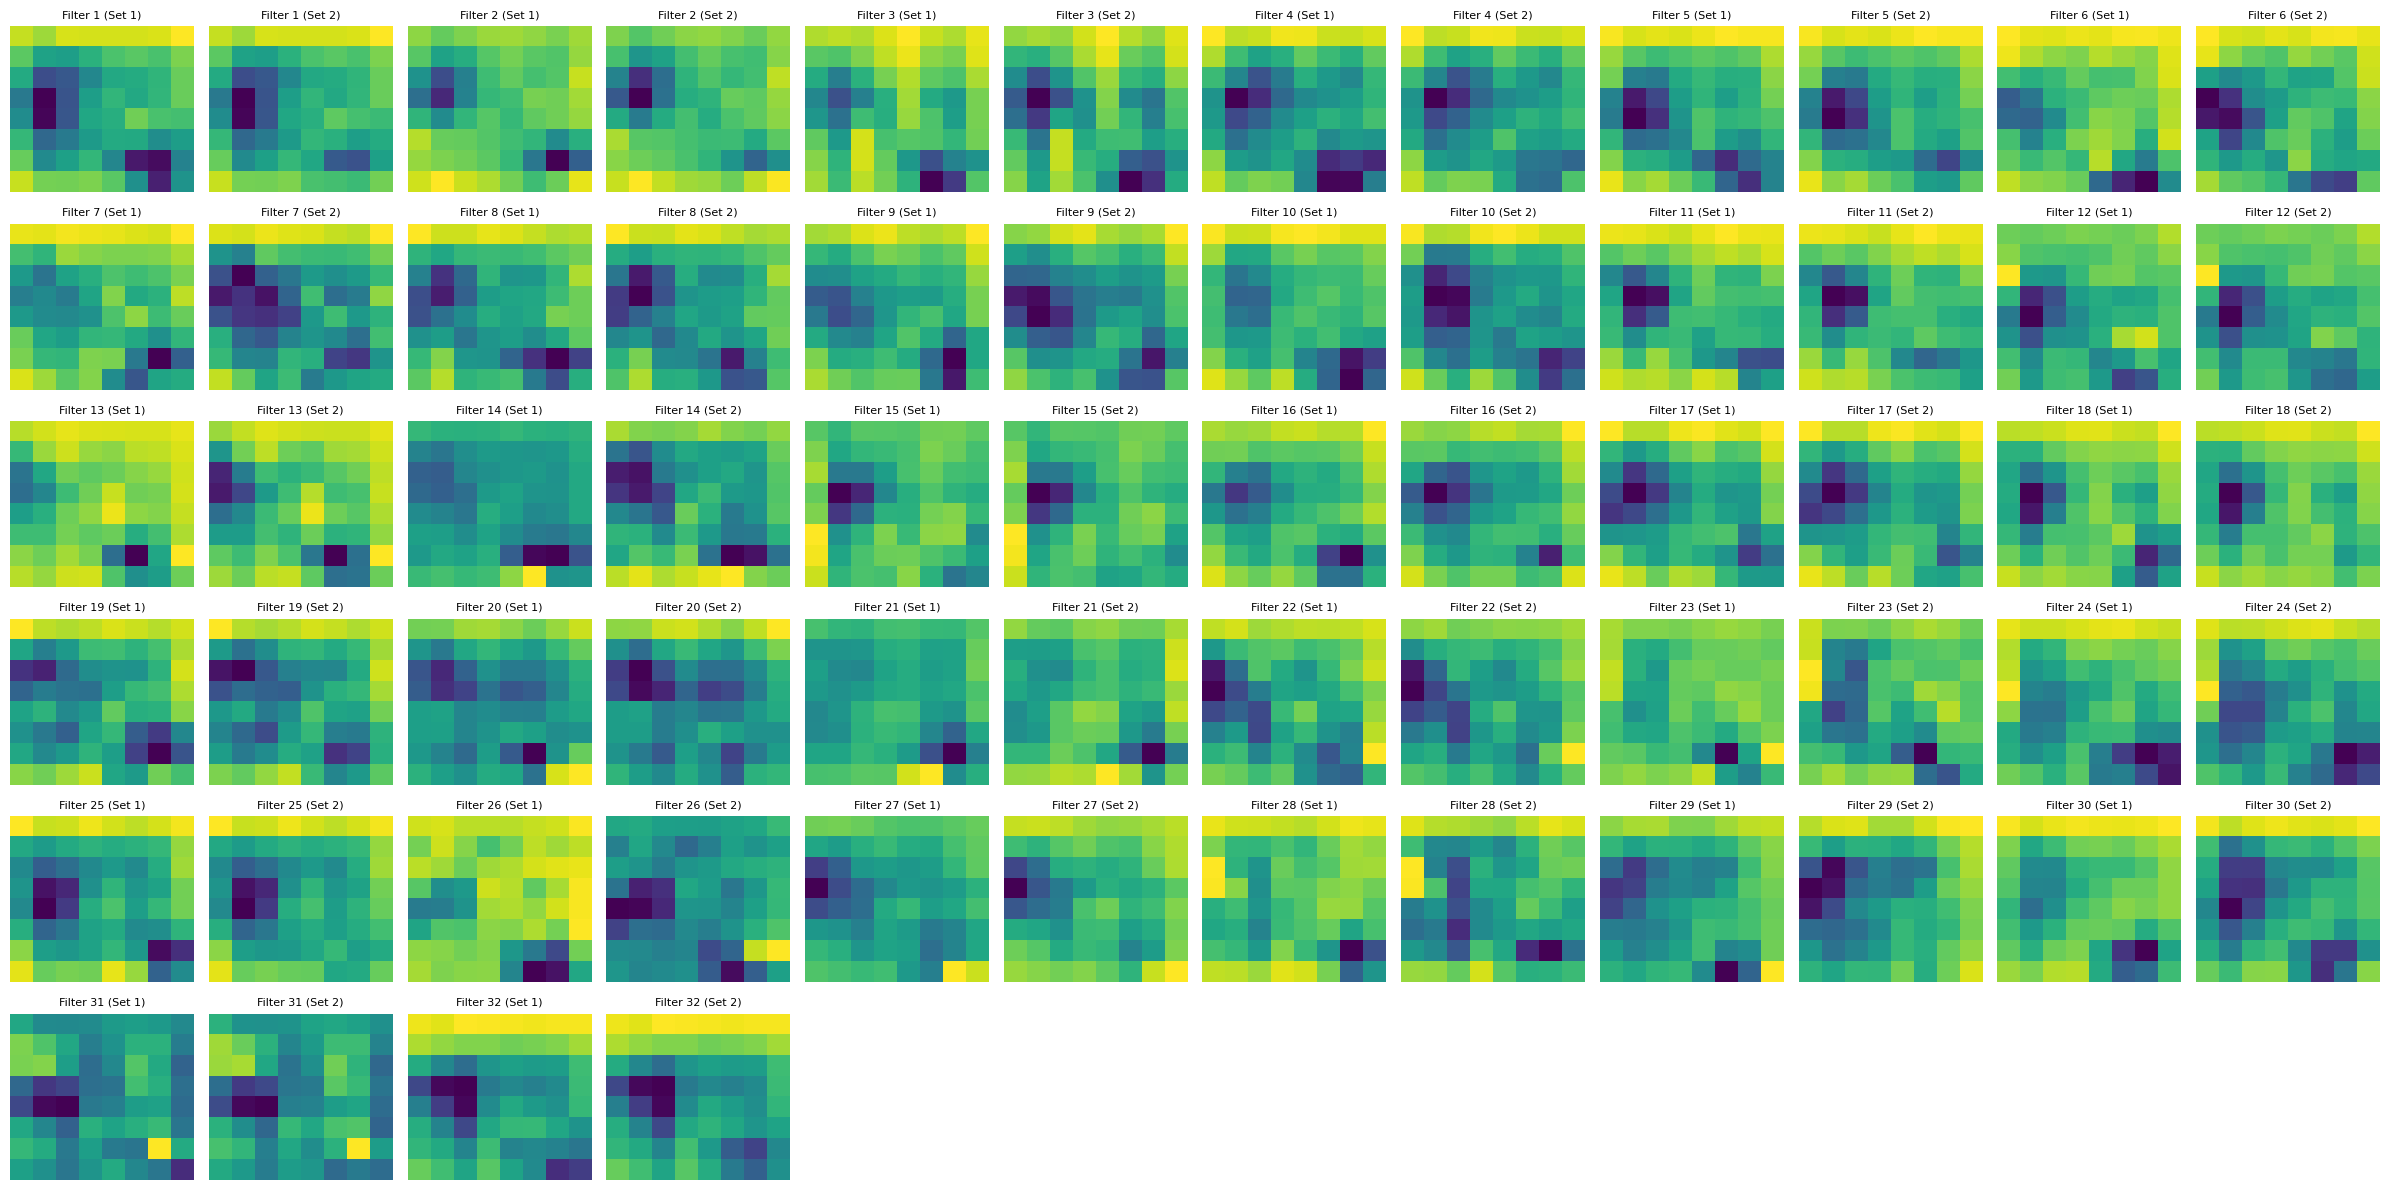

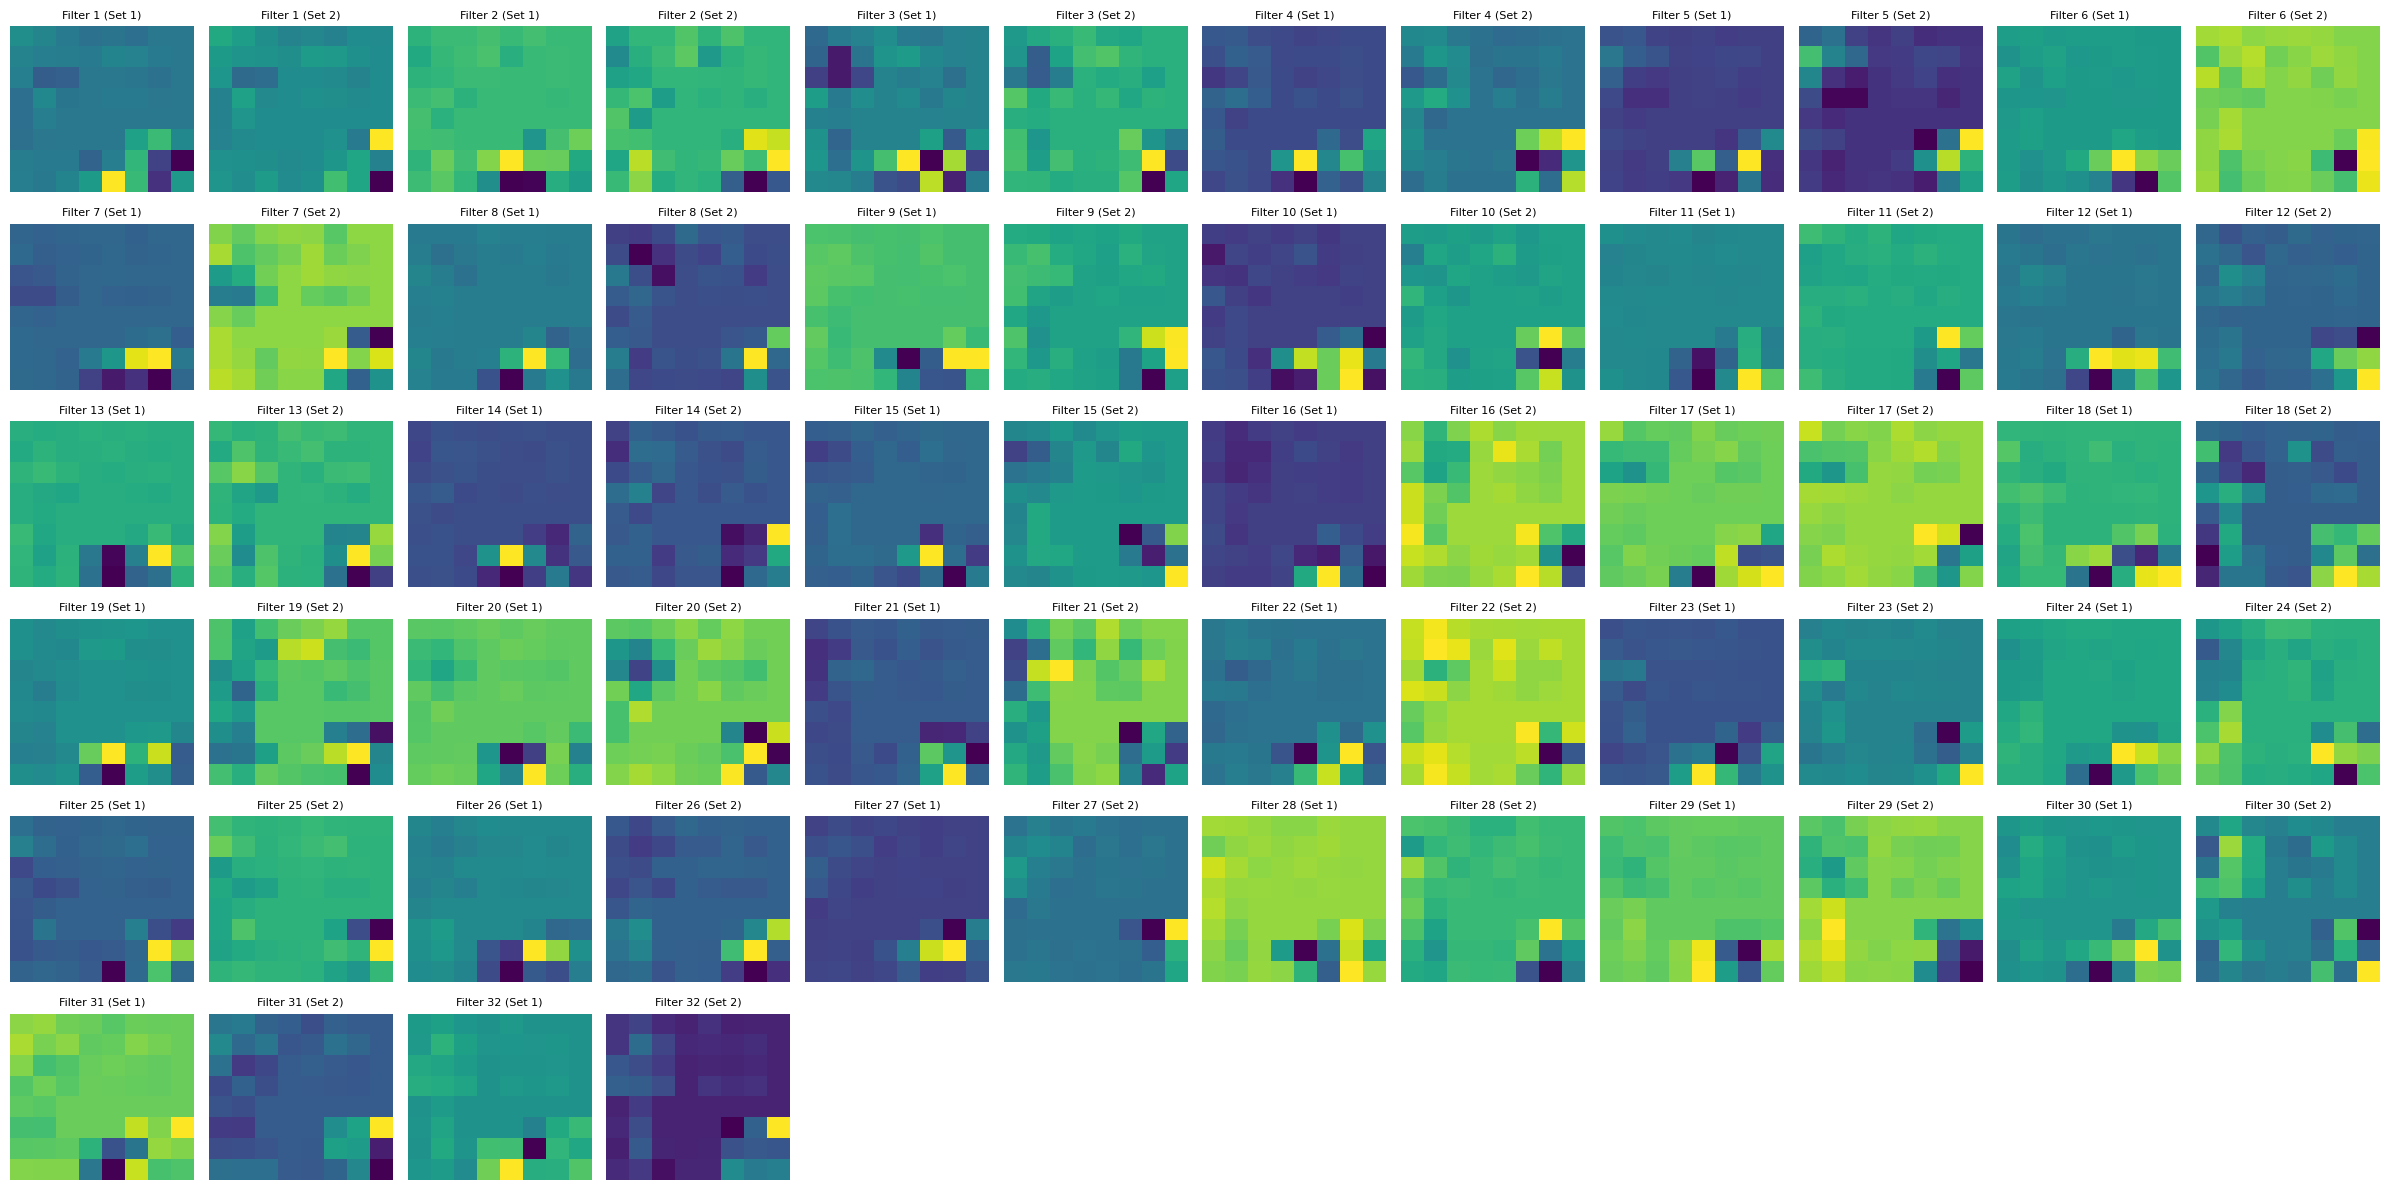

In [ ]:
all_layers = ['conv_seqs_0_conv', 'conv_seqs_0_res_block0_conv0', 'conv_seqs_0_res_block0_conv1', 'conv_seqs_0_res_block1_conv0', 'conv_seqs_0_res_block1_conv1', 'conv_seqs_1_conv', 'conv_seqs_1_res_block0_conv0', 'conv_seqs_1_res_block0_conv1', 'conv_seqs_1_res_block1_conv0', 'conv_seqs_1_res_block1_conv1', 'conv_seqs_2_conv', 'conv_seqs_2_res_block0_conv0', 'conv_seqs_2_res_block0_conv1', 'conv_seqs_2_res_block1_conv0', 'conv_seqs_2_res_block1_conv1']

helpers.plot_activations_for_layers_side_by_side(key_activations, gem_activations,helpers.rename_paths(layer_paths))

torch.Size([16, 64, 64])
Key: conv_seqs_0_conv has non-zero differences.
torch.Size([16, 32, 32])
Key: conv_seqs_0_res_block0_conv0 has non-zero differences.
torch.Size([16, 32, 32])
Key: conv_seqs_0_res_block0_conv1 has non-zero differences.
torch.Size([16, 32, 32])
Key: conv_seqs_0_res_block1_conv0 has non-zero differences.
torch.Size([16, 32, 32])
Key: conv_seqs_0_res_block1_conv1 has non-zero differences.
torch.Size([32, 32, 32])
Key: conv_seqs_1_conv has non-zero differences.
torch.Size([32, 16, 16])
Key: conv_seqs_1_res_block0_conv0 has non-zero differences.
torch.Size([32, 16, 16])
Key: conv_seqs_1_res_block0_conv1 has non-zero differences.
torch.Size([32, 16, 16])
Key: conv_seqs_1_res_block1_conv0 has non-zero differences.
torch.Size([32, 16, 16])
Key: conv_seqs_1_res_block1_conv1 has non-zero differences.
torch.Size([32, 16, 16])
Key: conv_seqs_2_conv has non-zero differences.
torch.Size([32, 8, 8])
Key: conv_seqs_2_res_block0_conv0 has non-zero differences.
torch.Size([32, 8,

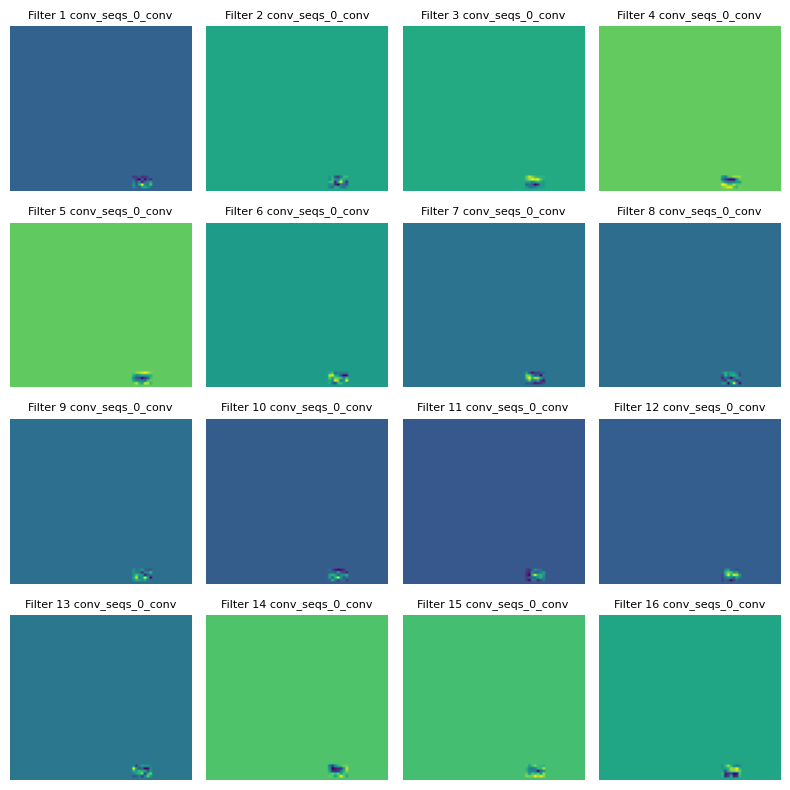

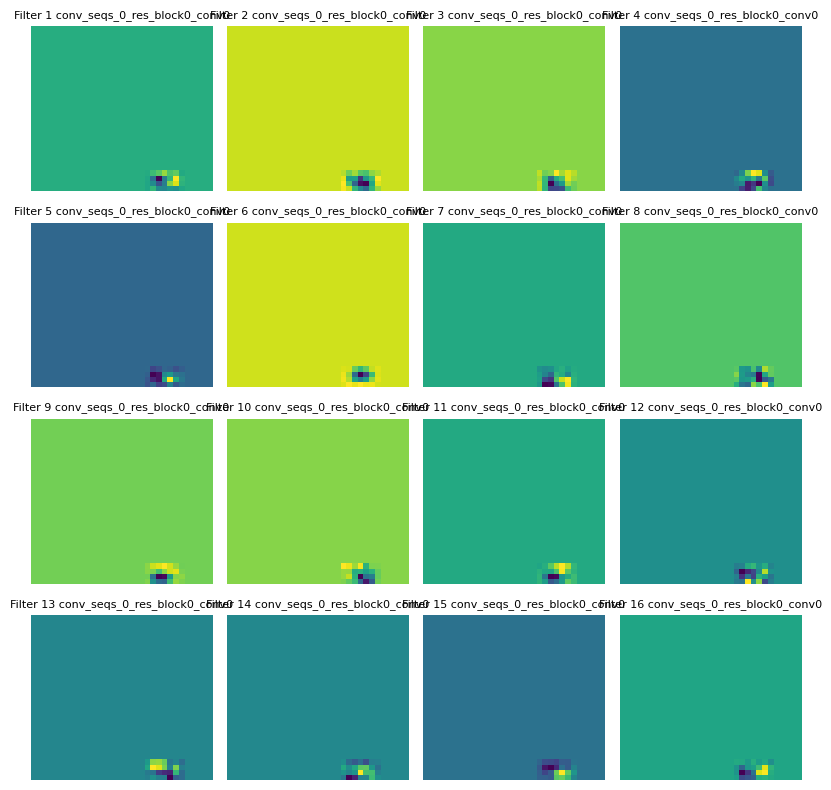

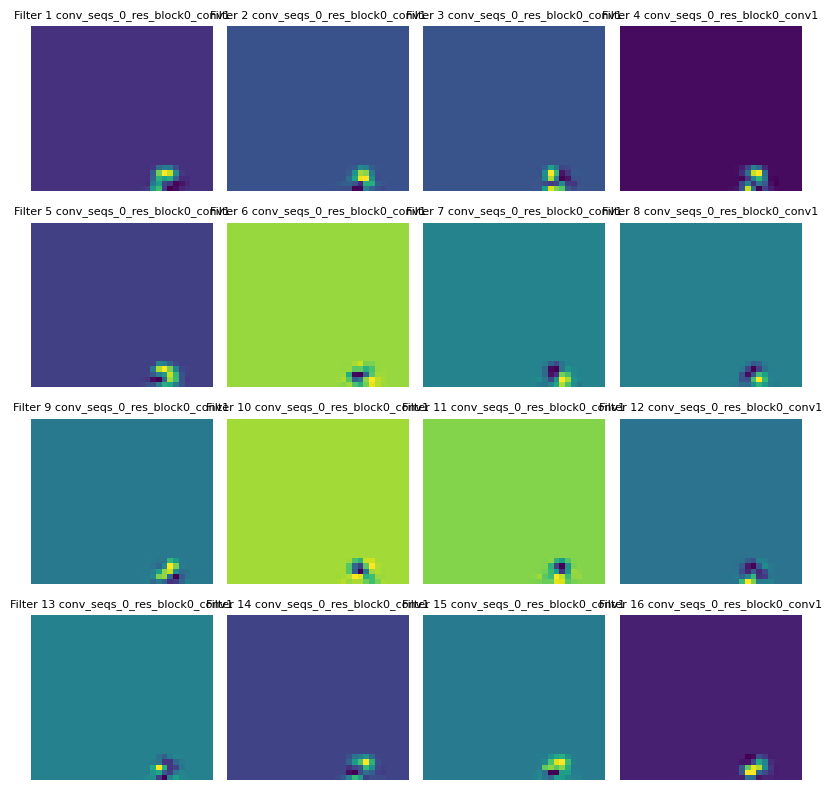

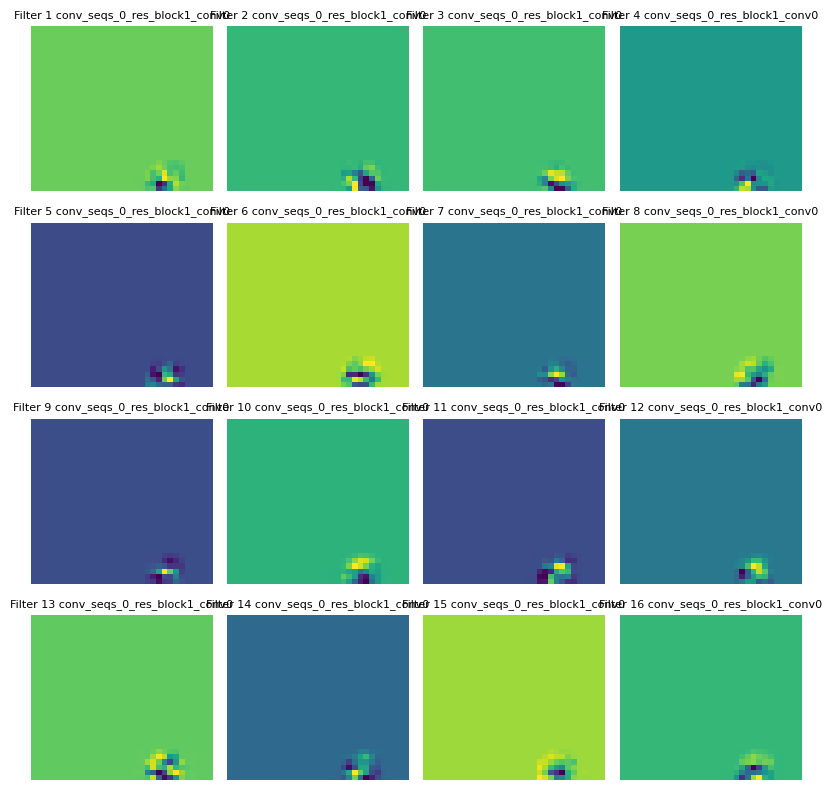

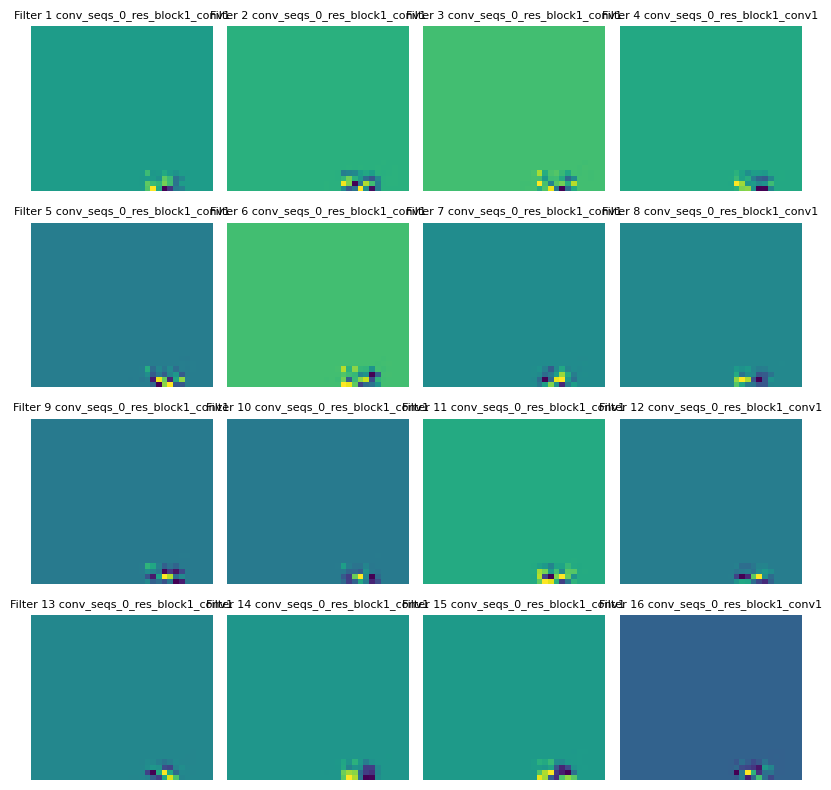

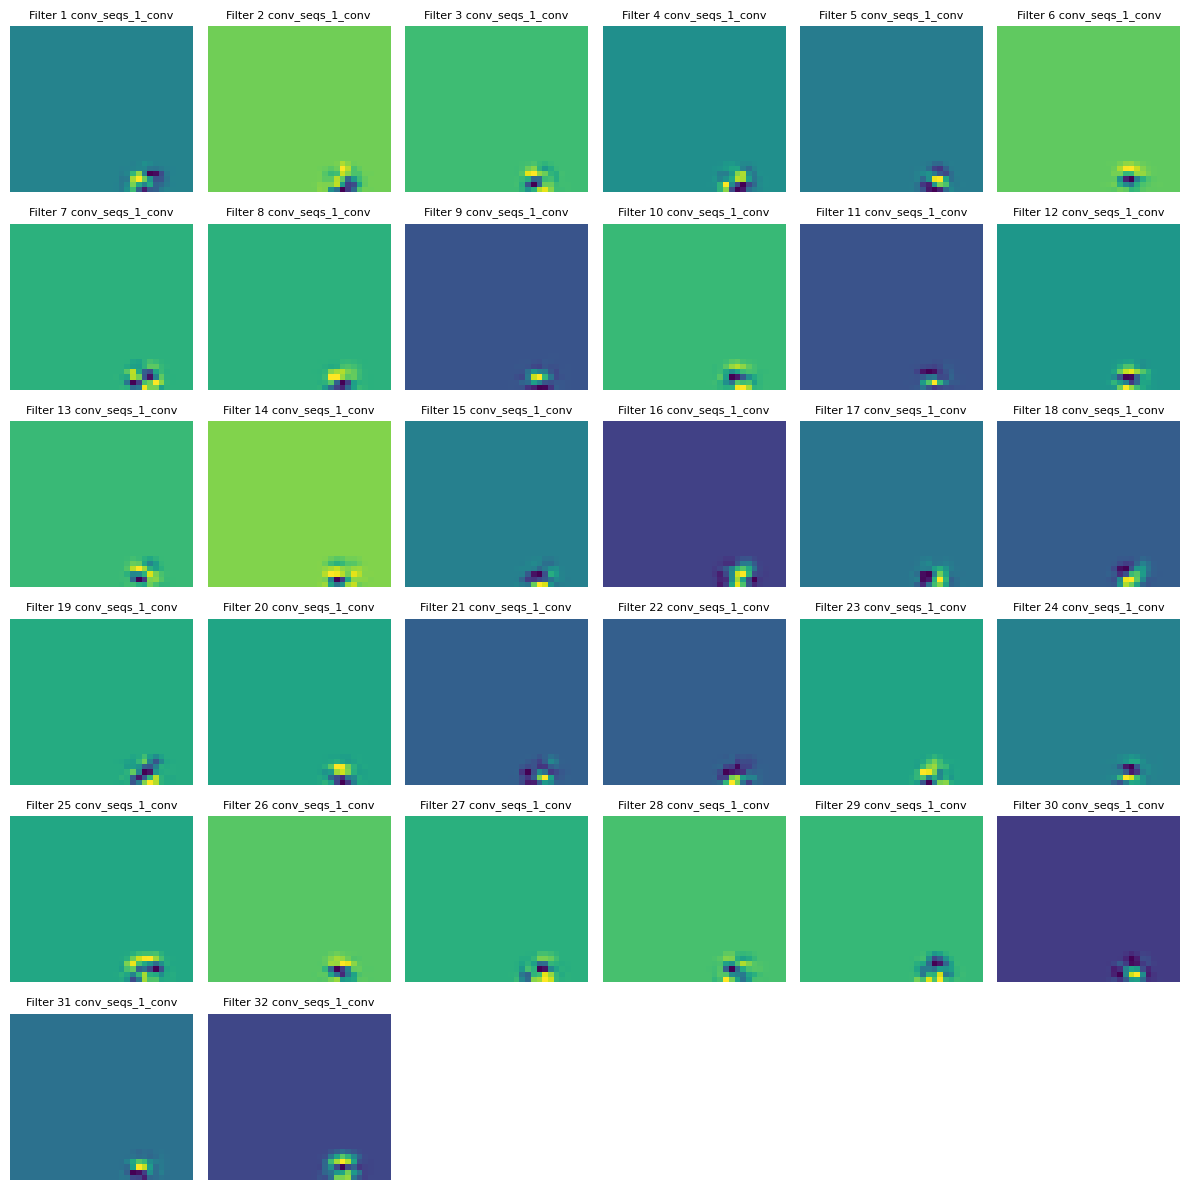

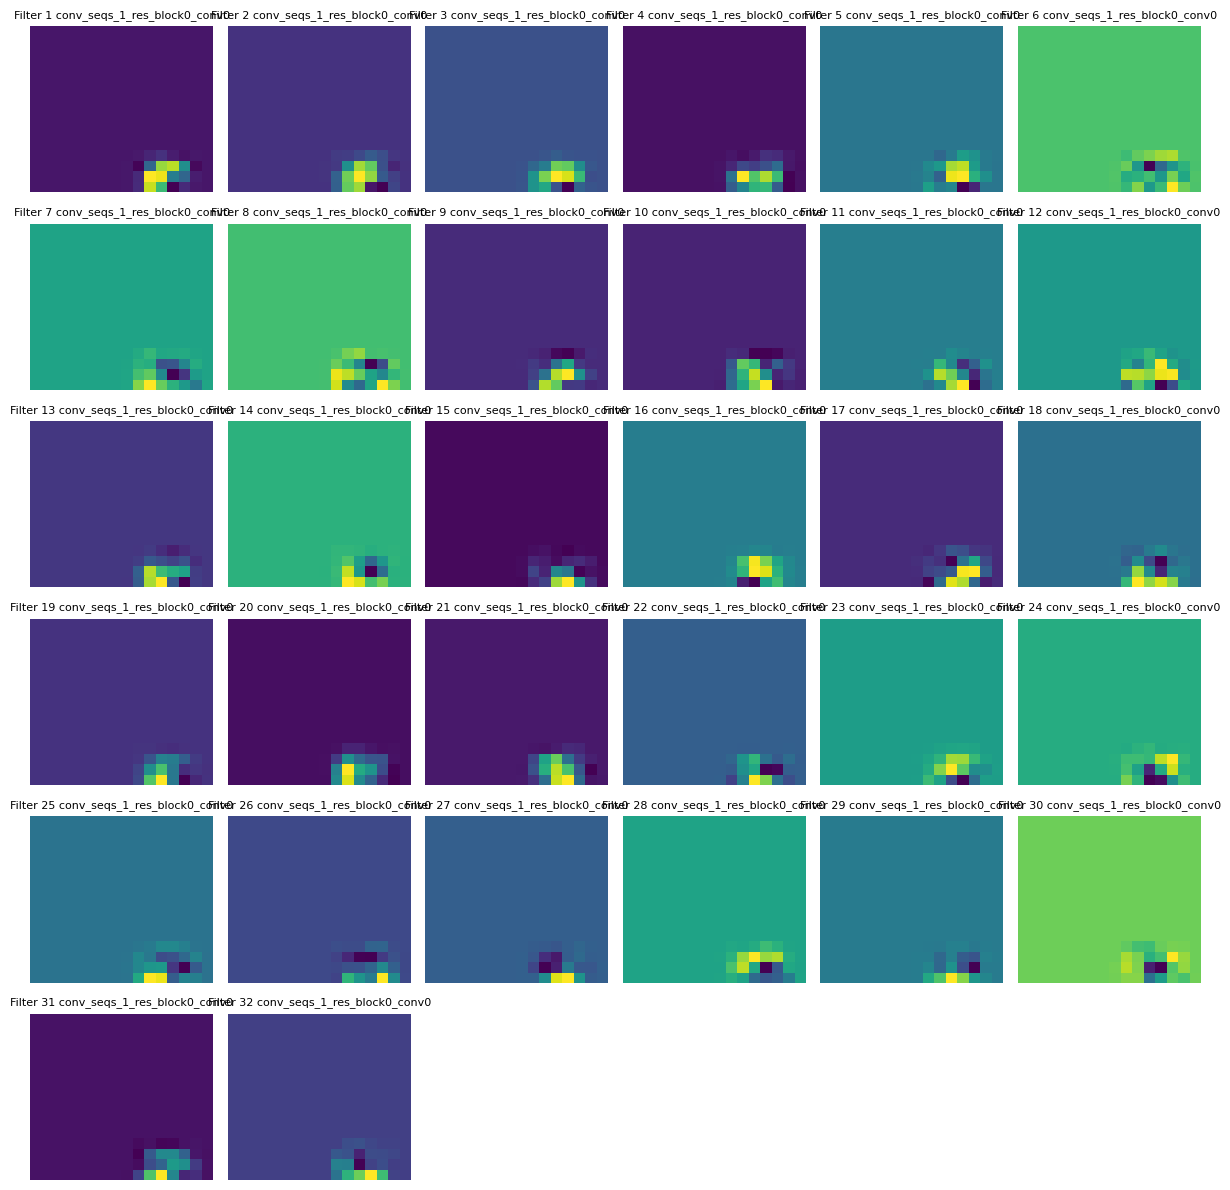

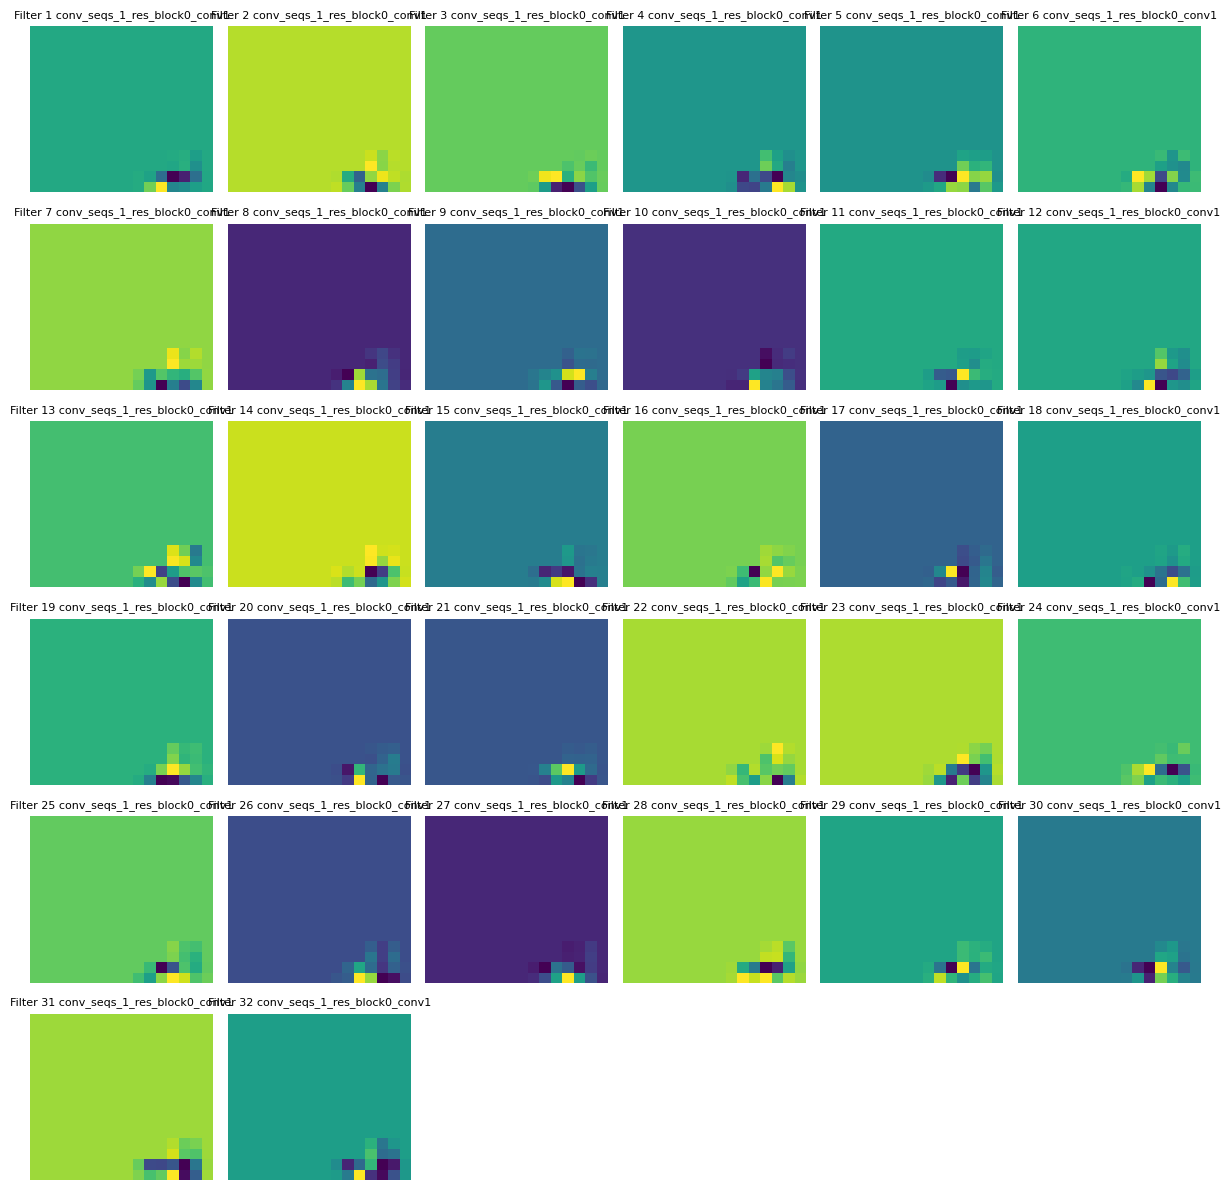

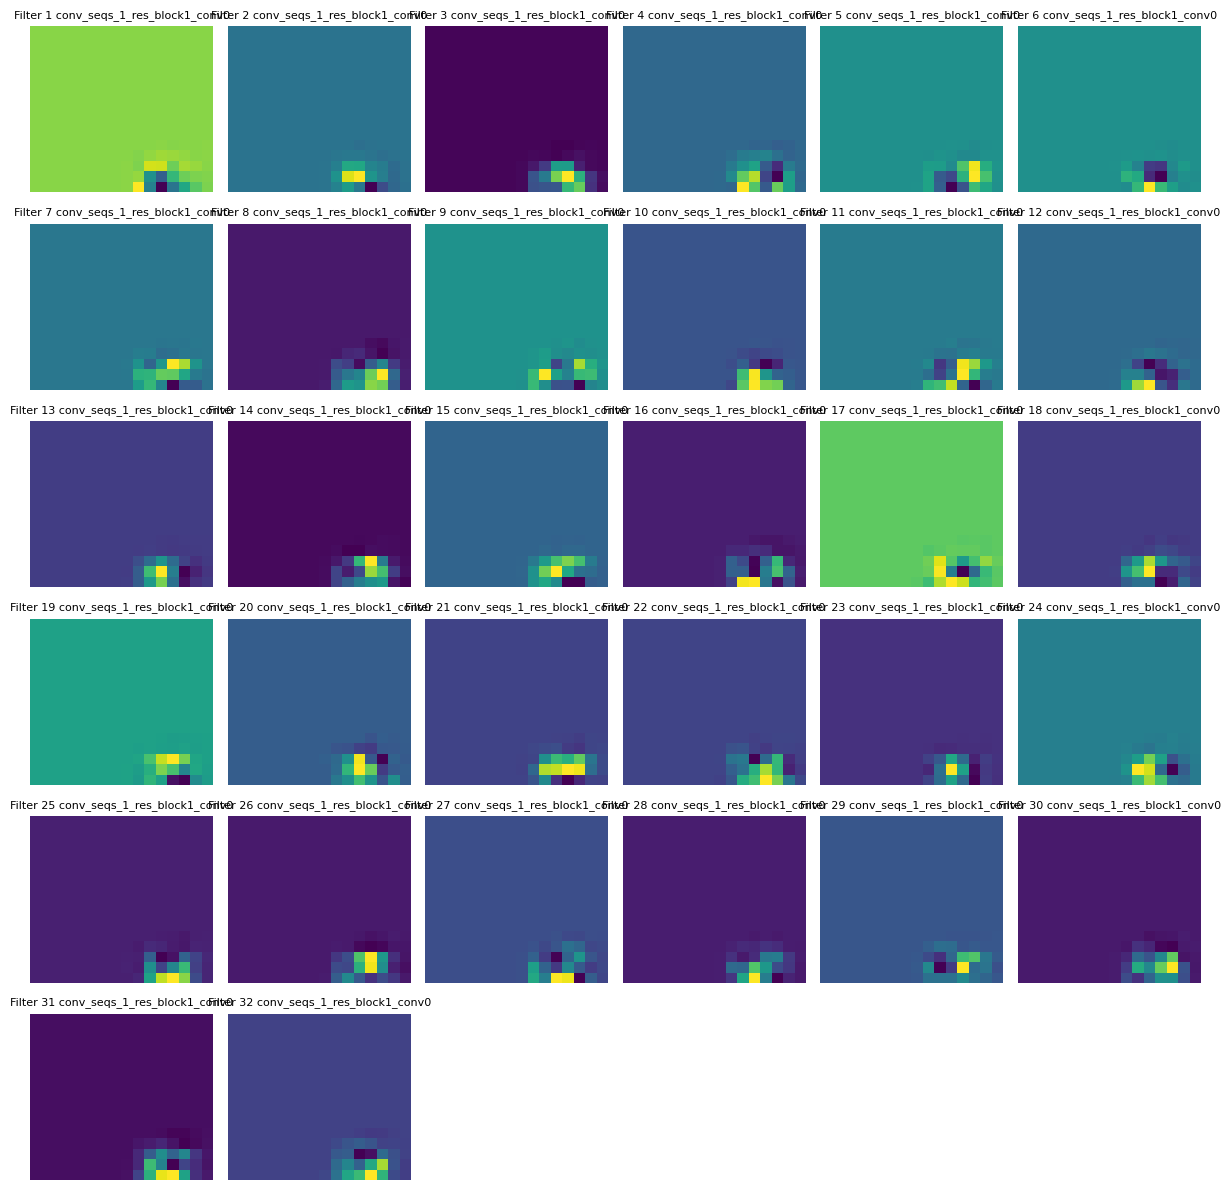

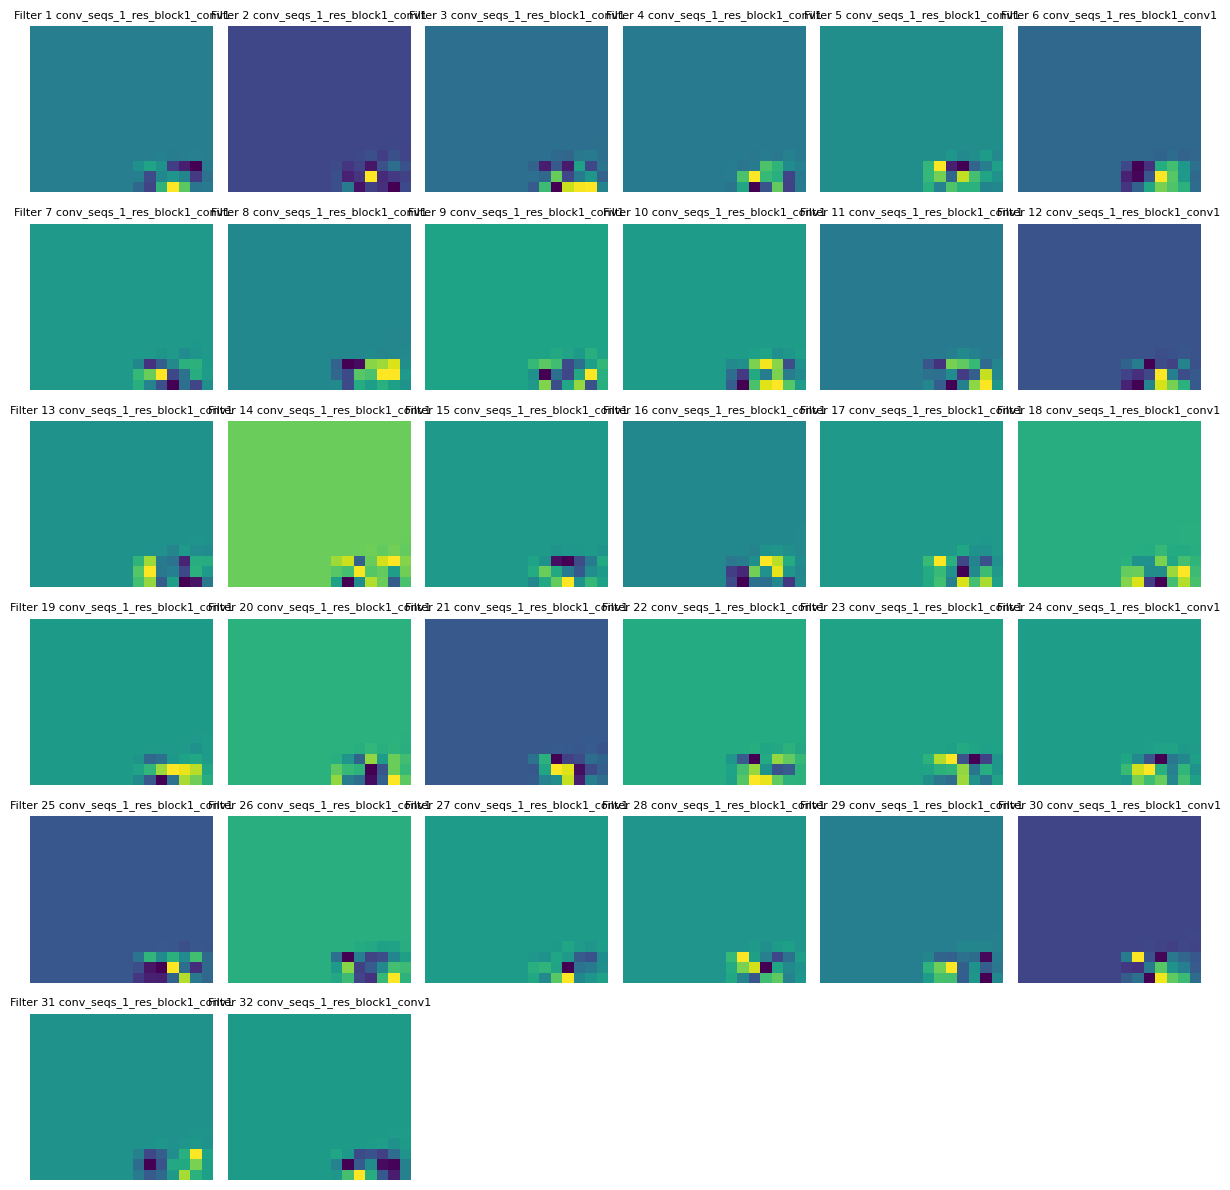

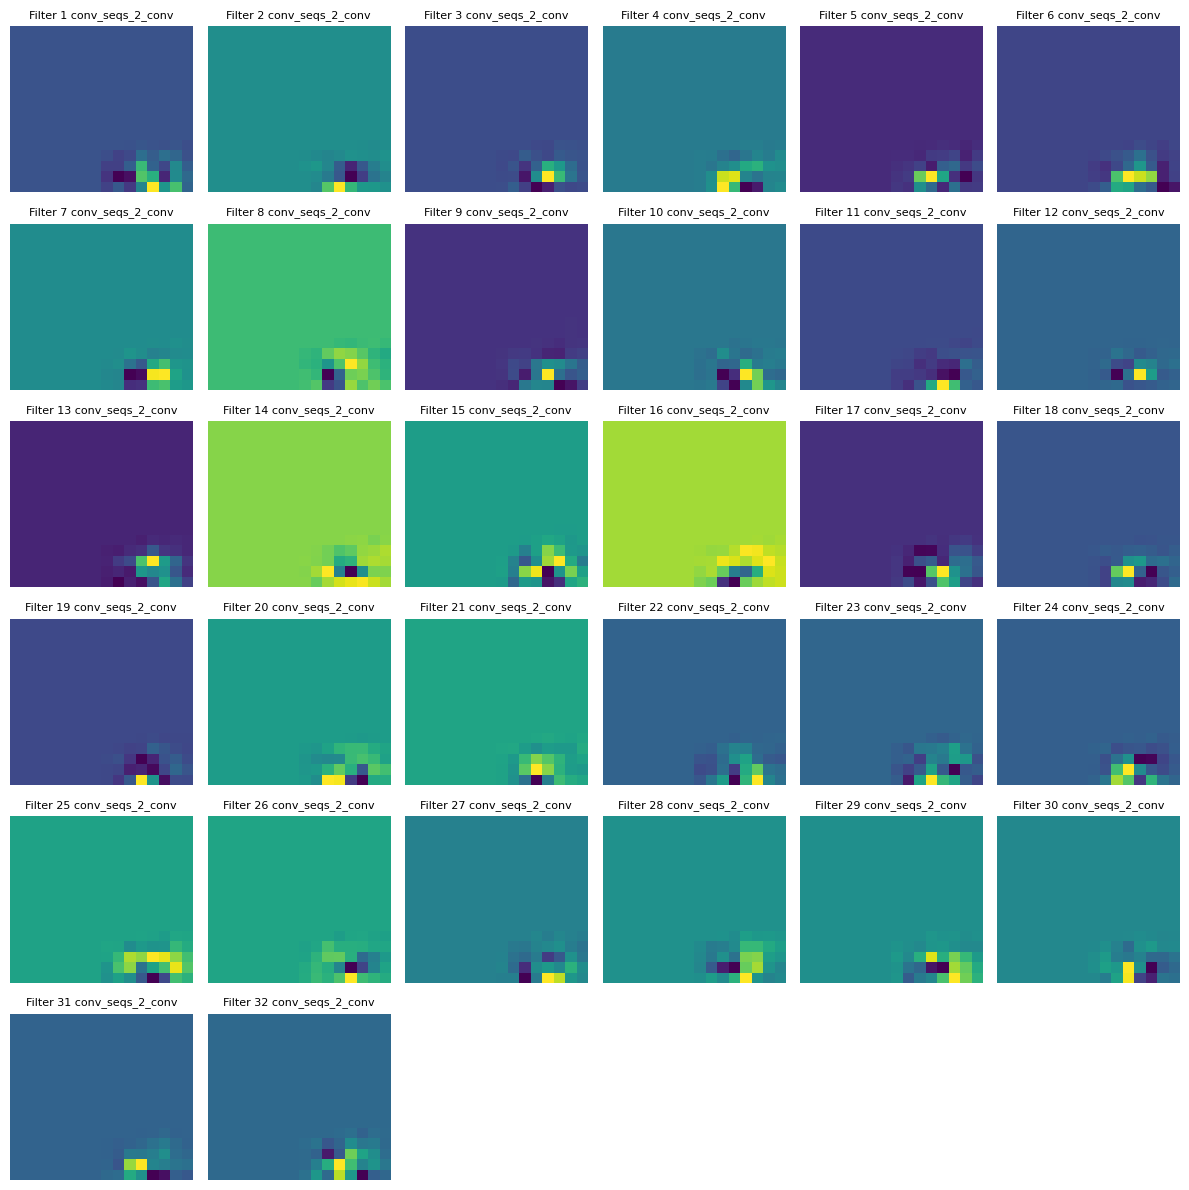

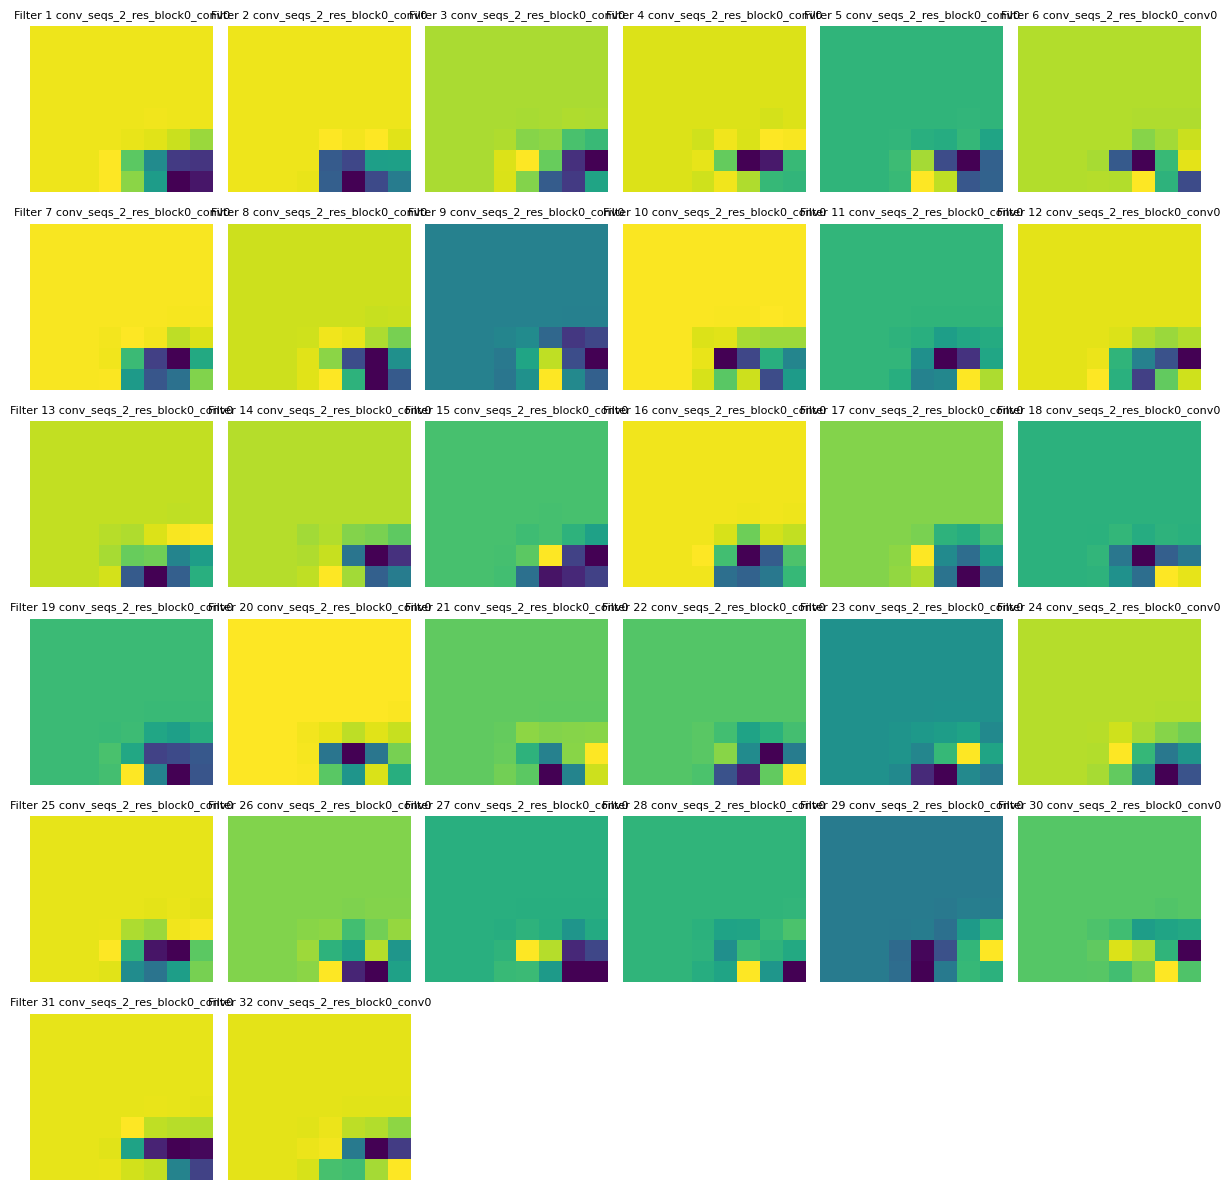

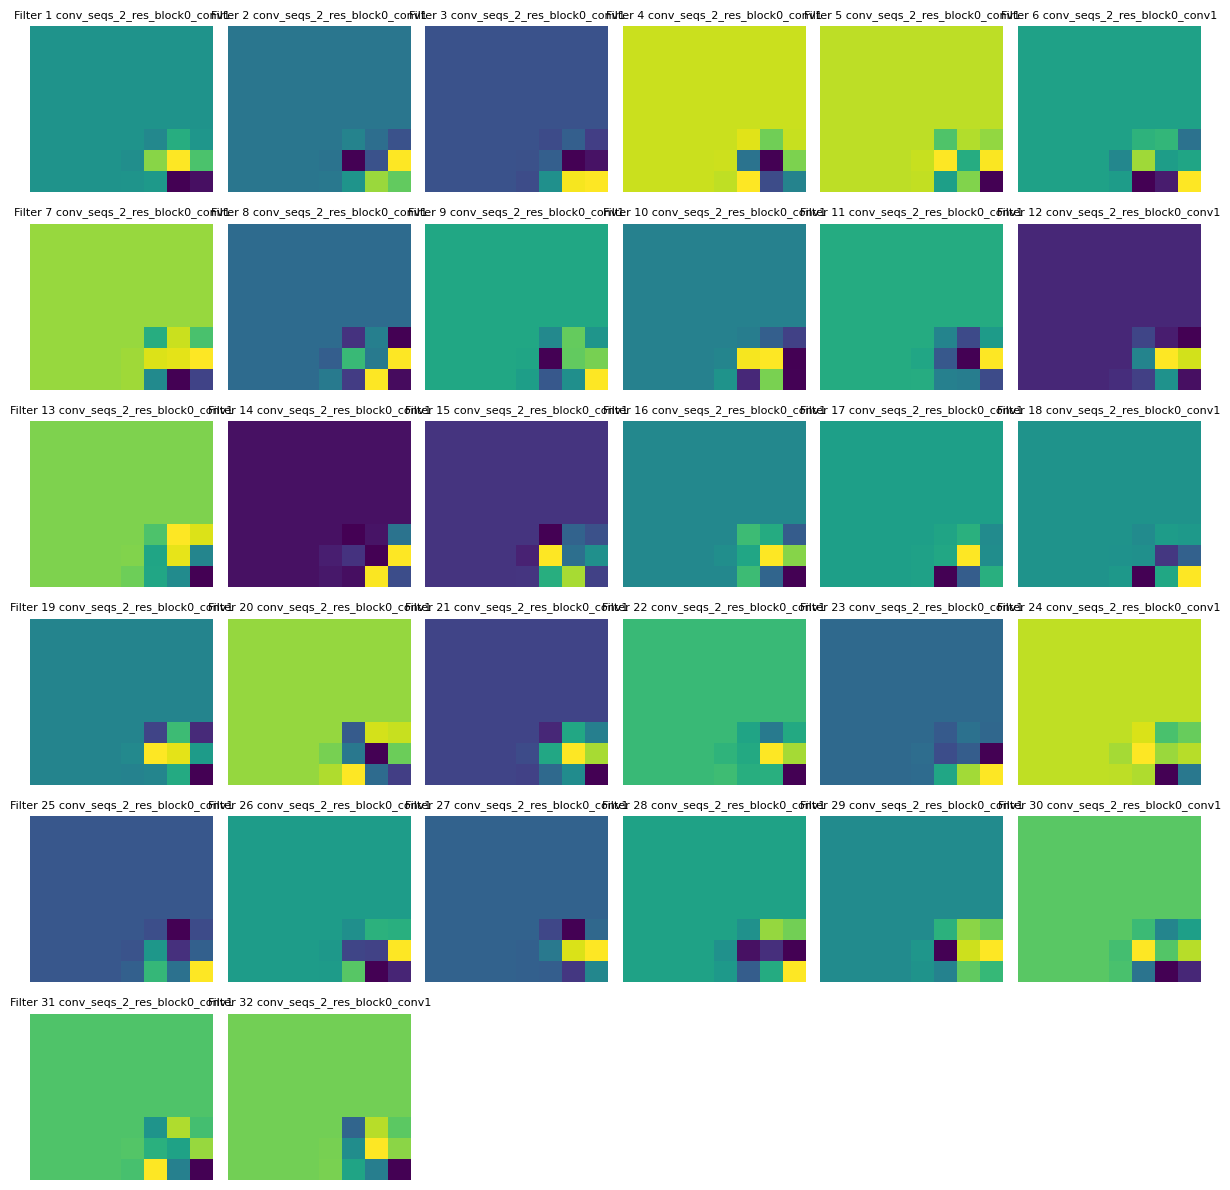

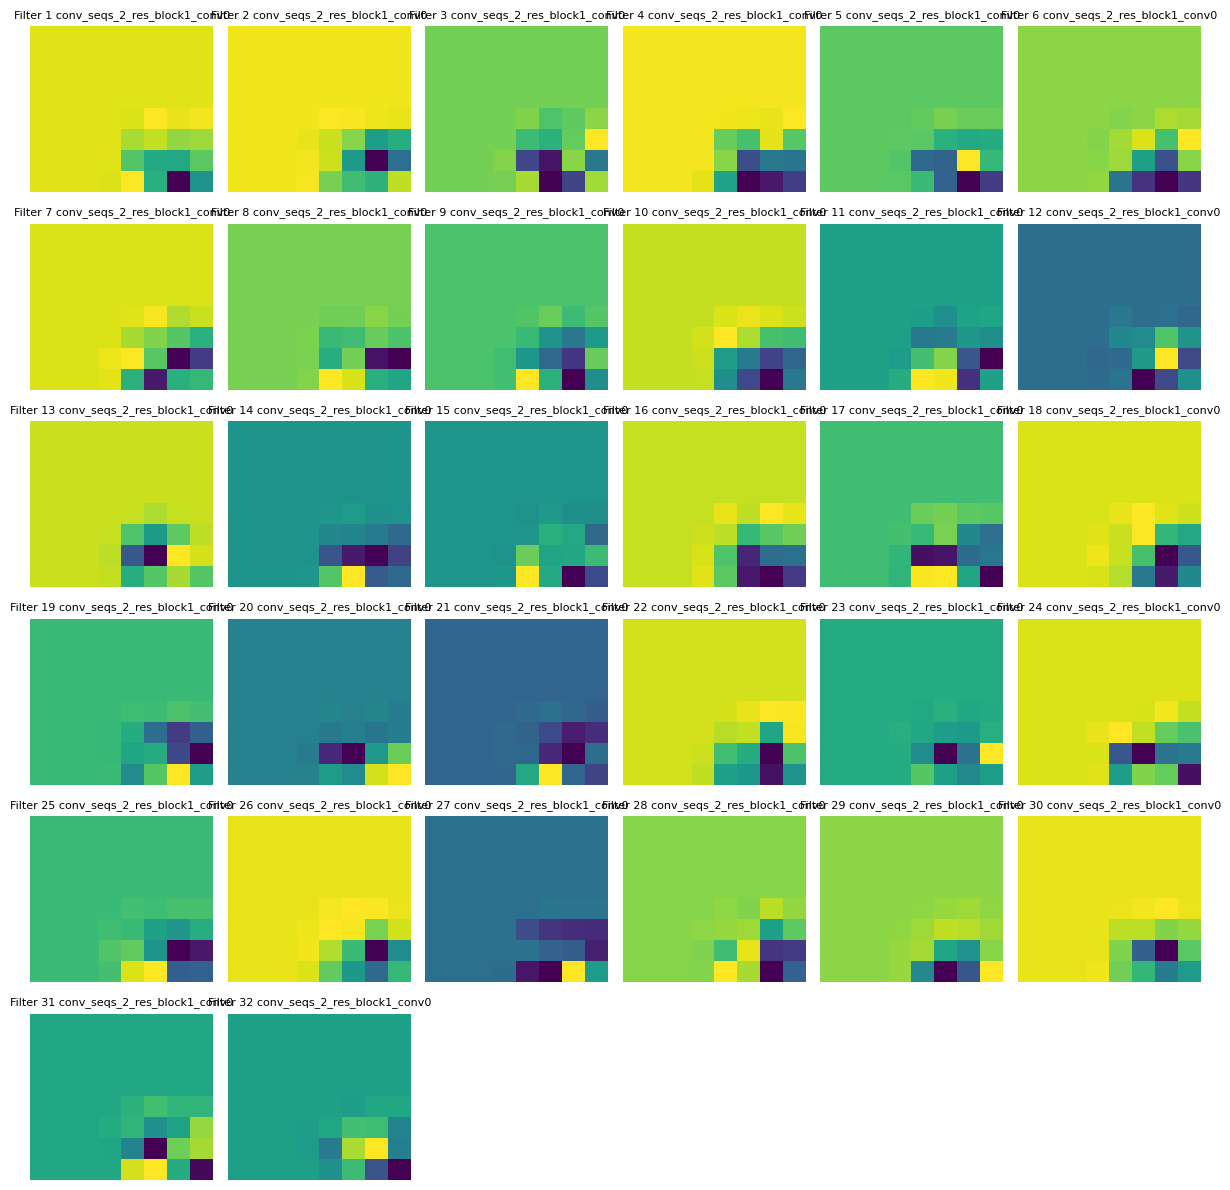

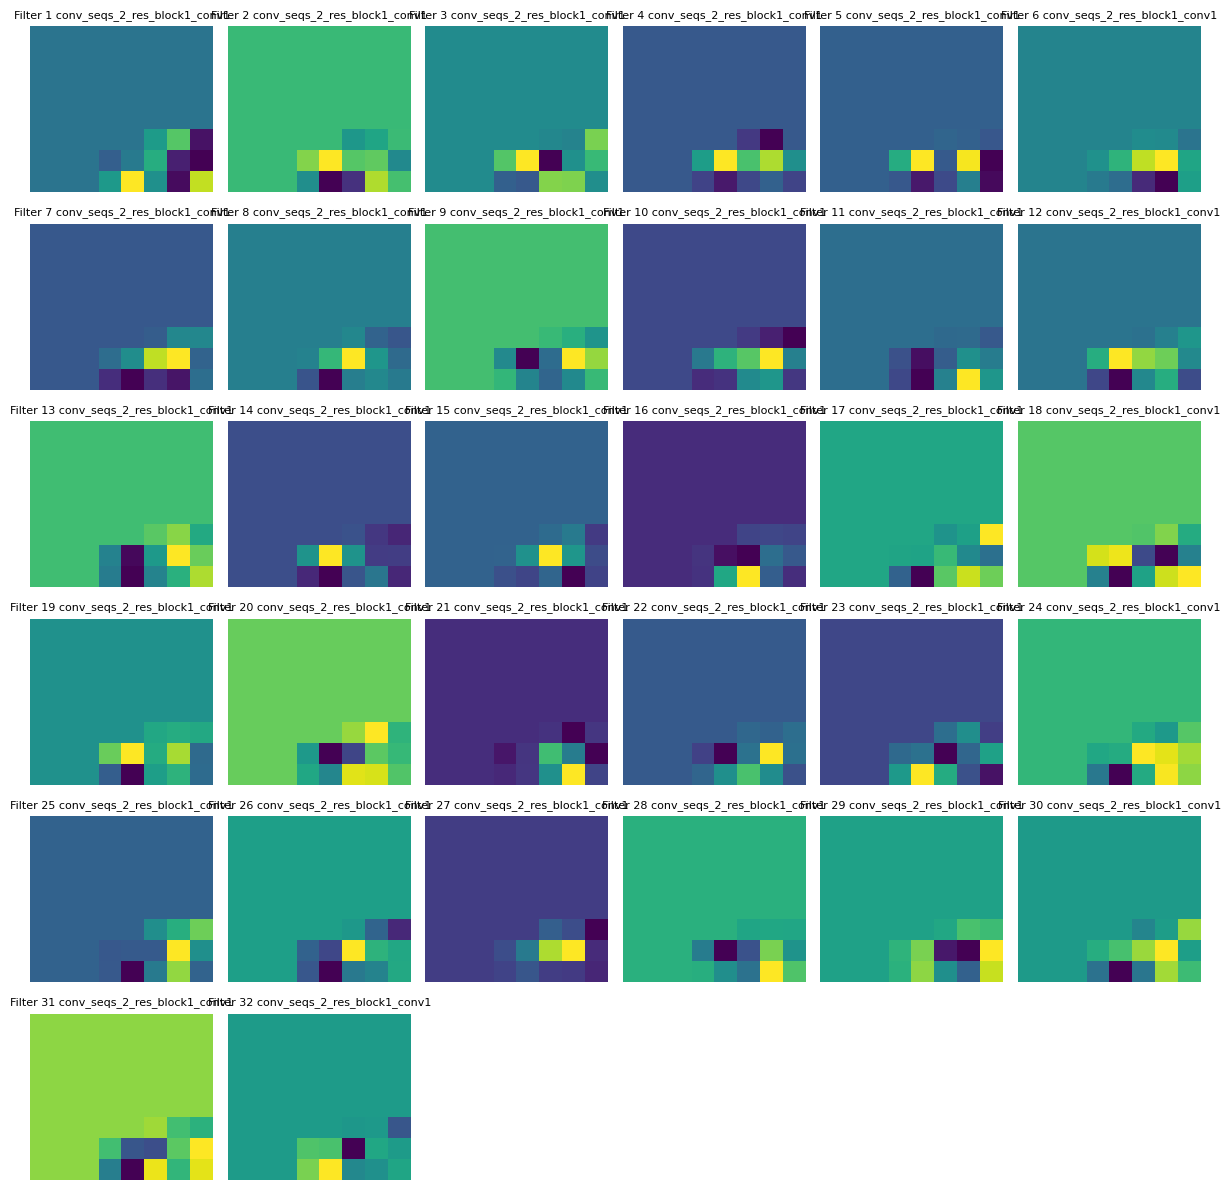

In [ ]:
key_gem_differences = helpers.compute_activation_differences(gem_activations,key_activations)
helpers.plot_activations_for_layers(key_gem_differences, all_layers)


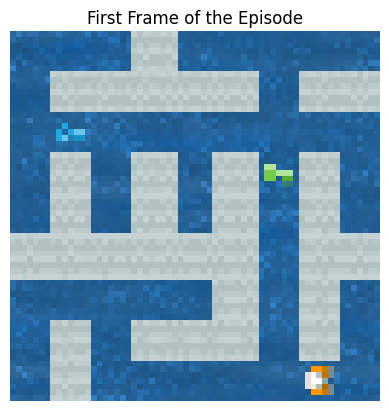

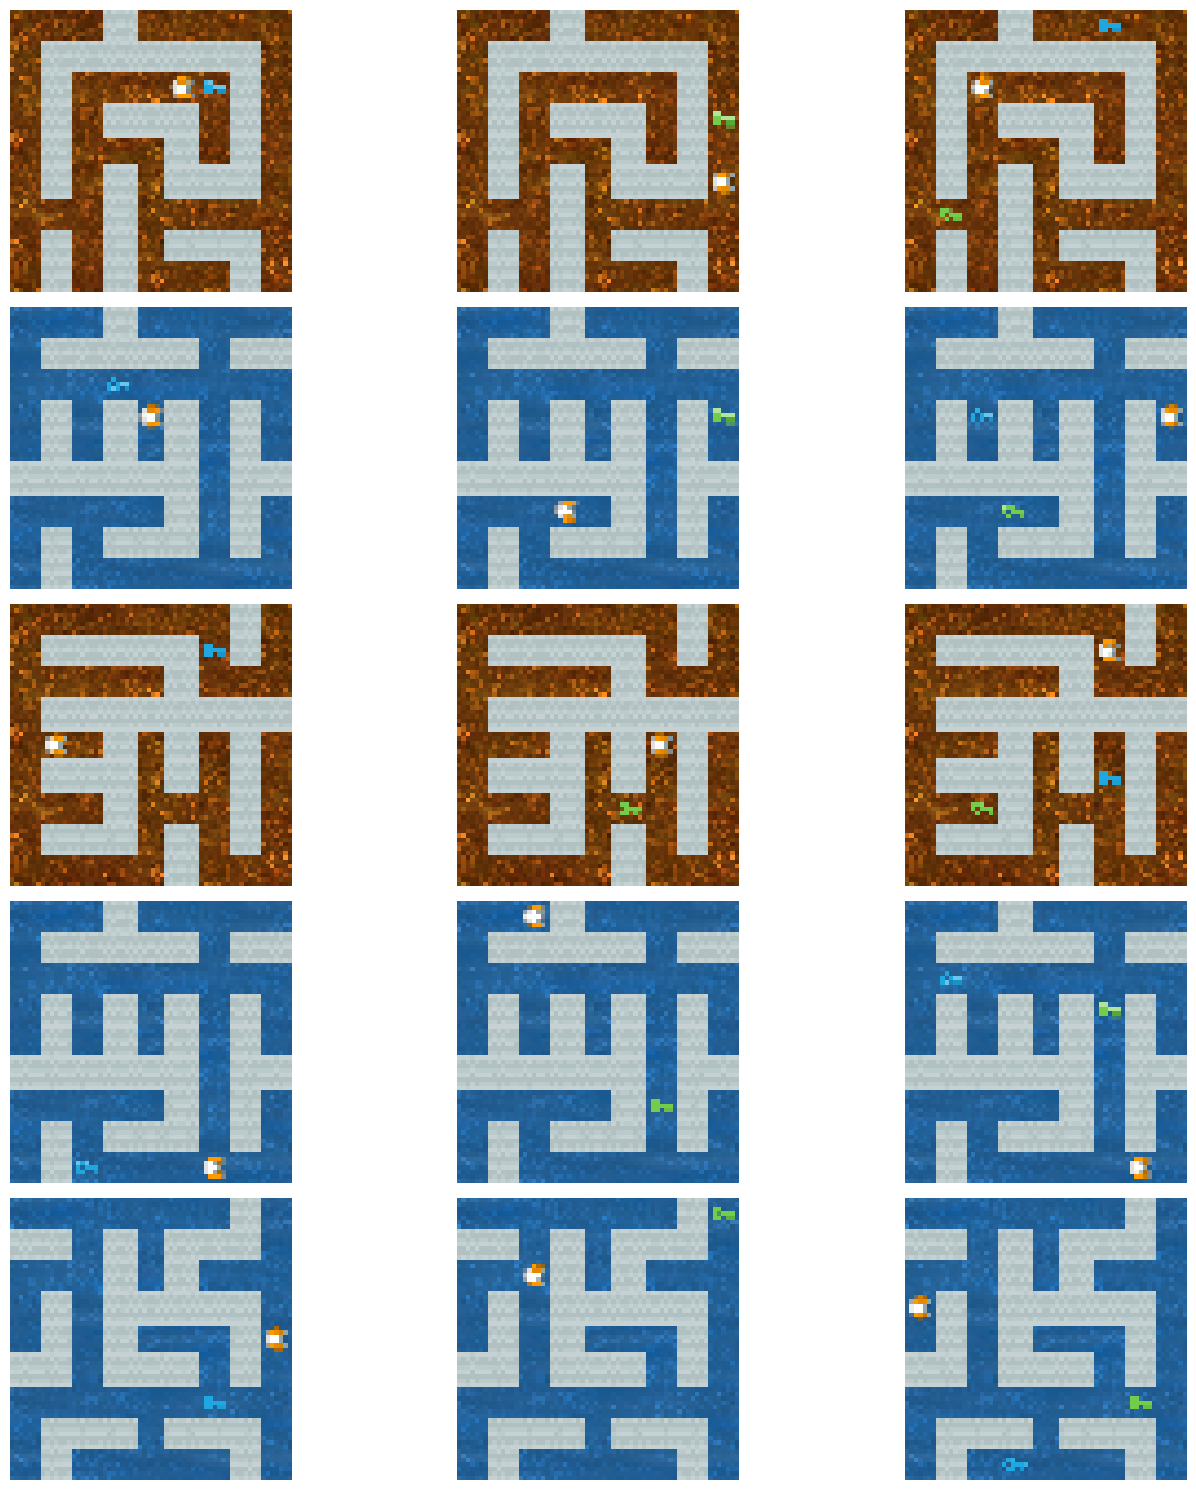

In [ ]:
num_samples = 5
num_levels = 100
key_color_combinations = [['blue'], ['green'], ['blue', 'green']]
observations_list = heist.create_key_states(key_color_combinations, num_samples, num_levels)


plt.imshow(observations_list[3][2].transpose(1, 2, 0))
plt.title("First Frame of the Episode")
plt.axis('off')
plt.show()



import itertools
fig, axs = plt.subplots(5, 3, figsize=(15, 15))  # Adjusted to create a 5x3 grid
for (i, j), obs in zip(itertools.product(range(5), range(3)), itertools.chain.from_iterable(observations_list)):
    axs[i, j].imshow(obs.transpose(1, 2, 0))
    # axs[i, j].set_title(f"Sample {j+1}, Obs {i+1}")
    axs[i, j].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
obs_list = heist.create_gem_states(5)

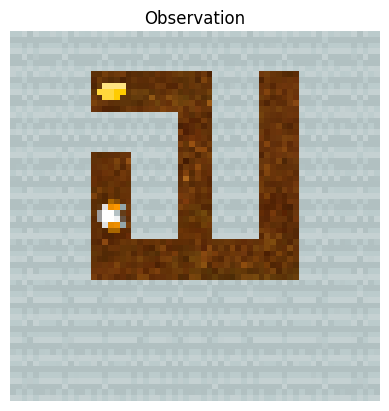

In [ ]:
helpers.plot_single_observation(obs_list[2].transpose(1, 2, 0))

# Train Linear probe

In [153]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

In [10]:
dataset = heist.create_classified_dataset(num_samples_per_category=20)

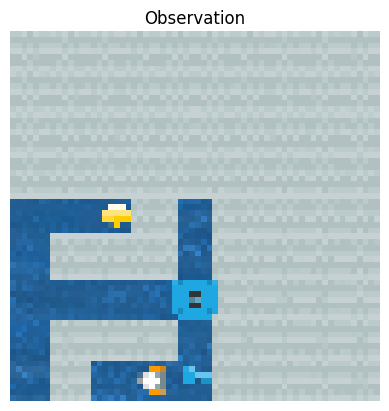

In [11]:
helpers.plot_single_observation(dataset["blue_key"][0])

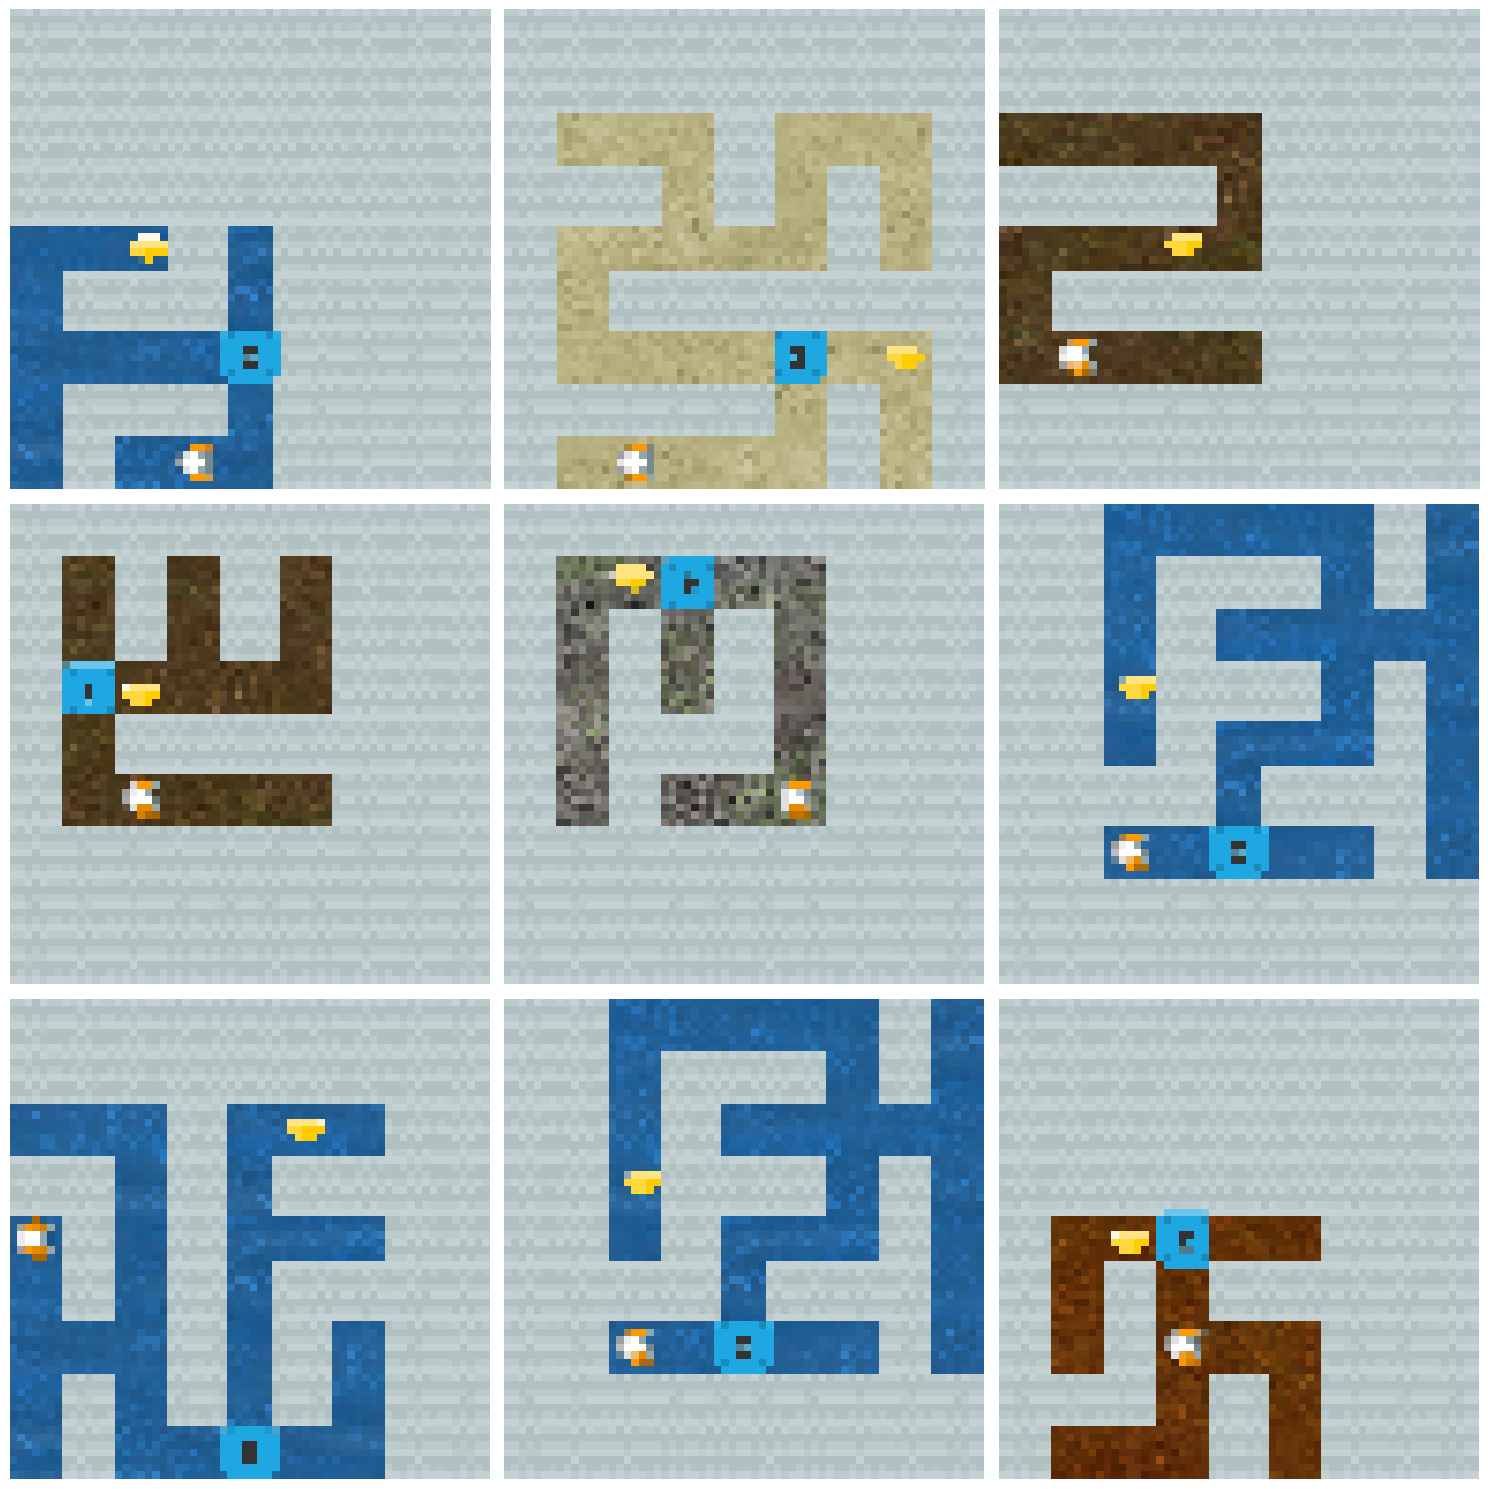

In [16]:
import matplotlib.pyplot as plt
import itertools

# Assuming 'dataset' is your data structure and it contains at least 15 images under the "blue_key" key
images = dataset["blue_lock"]  # Access the list of images
n_samples = 9  # Number of samples to display

# Create a figure with subplots in a 5x3 grid
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

# Iterate over the first 15 images (ensuring there are at least 15)
for idx, img in enumerate(images[:n_samples]):
    i, j = divmod(idx, 3)  # Calculate subplot grid indices
    axs[i, j].imshow(img)  # Display the image on the corresponding subplot
    axs[i, j].axis('off')  # Hide axes

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Show the plot


In [157]:
def create_activation_dataset(dataset, model, layer_paths):
    activation_dataset = {
        "gem": [],      
        "blue_key": [],
        "green_key": [],
        "red_key": [],
        "blue_lock": [],
        "green_lock": [],
        "red_lock": []
    }

    for category in dataset:
        for obs in dataset[category]:
            obs_rgb = helpers.observation_to_rgb(obs)
            model_activations = ModelActivations(model)
            _, activations = model_activations.run_with_cache(obs_rgb, layer_paths)
            model_activations.clear_hooks()


            activation_dataset[category].append(activations)

    return activation_dataset


In [158]:
activation_dataset["blue_key"][9].keys()
        

NameError: name 'activation_dataset' is not defined

In [159]:
# Create classified dataset
# classified_dataset = heist.create_classified_dataset(num_samples_per_category=100, num_levels=1000)

# Load the model
model = helpers.load_model()

# Create activation dataset
activation_dataset = create_activation_dataset(dataset, model, helpers.get_model_layer_names(model))

KeyError: 'top_left'

In [ ]:
torch.equal(torch.tensor(activation_dataset["blue_key"][2]["conv_seqs_0_conv"][0]), torch.tensor((activation_dataset["blue_key"][1]["conv_seqs_0_conv"][0])))

/var/folders/58/f16y6j7x0j5d0vv3pvq80c680000gn/T/ipykernel_98789/1014579437.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.equal(torch.tensor(activation_dataset["blue_key"][2]["conv_seqs_0_conv"][0]), torch.tensor((activation_dataset["blue_key"][1]["conv_seqs_0_conv"][0])))


False

In [ ]:
helpers.rename_paths(layer_names)

['conv_seqs',
 'conv_seqs_0',
 'conv_seqs_0_conv',
 'conv_seqs_0_max_pool2d',
 'conv_seqs_0_res_block0',
 'conv_seqs_0_res_block0_conv0',
 'conv_seqs_0_res_block0_conv1',
 'conv_seqs_0_res_block1',
 'conv_seqs_0_res_block1_conv0',
 'conv_seqs_0_res_block1_conv1',
 'conv_seqs_1',
 'conv_seqs_1_conv',
 'conv_seqs_1_max_pool2d',
 'conv_seqs_1_res_block0',
 'conv_seqs_1_res_block0_conv0',
 'conv_seqs_1_res_block0_conv1',
 'conv_seqs_1_res_block1',
 'conv_seqs_1_res_block1_conv0',
 'conv_seqs_1_res_block1_conv1',
 'conv_seqs_2',
 'conv_seqs_2_conv',
 'conv_seqs_2_max_pool2d',
 'conv_seqs_2_res_block0',
 'conv_seqs_2_res_block0_conv0',
 'conv_seqs_2_res_block0_conv1',
 'conv_seqs_2_res_block1',
 'conv_seqs_2_res_block1_conv0',
 'conv_seqs_2_res_block1_conv1',
 'hidden_fc',
 'logits_fc',
 'value_fc']

In [ ]:
activation_dataset["gem"][0].keys()

dict_keys(['conv_seqs_0_conv', 'conv_seqs_0_max_pool2d', 'conv_seqs_0_res_block0_conv0', 'conv_seqs_0_res_block0_conv1', 'conv_seqs_0_res_block0', 'conv_seqs_0_res_block1_conv0', 'conv_seqs_0_res_block1_conv1', 'conv_seqs_0_res_block1', 'conv_seqs_0', 'conv_seqs_1_conv', 'conv_seqs_1_max_pool2d', 'conv_seqs_1_res_block0_conv0', 'conv_seqs_1_res_block0_conv1', 'conv_seqs_1_res_block0', 'conv_seqs_1_res_block1_conv0', 'conv_seqs_1_res_block1_conv1', 'conv_seqs_1_res_block1', 'conv_seqs_1', 'conv_seqs_2_conv', 'conv_seqs_2_max_pool2d', 'conv_seqs_2_res_block0_conv0', 'conv_seqs_2_res_block0_conv1', 'conv_seqs_2_res_block0', 'conv_seqs_2_res_block1_conv0', 'conv_seqs_2_res_block1_conv1', 'conv_seqs_2_res_block1', 'conv_seqs_2', 'hidden_fc', 'logits_fc', 'value_fc'])

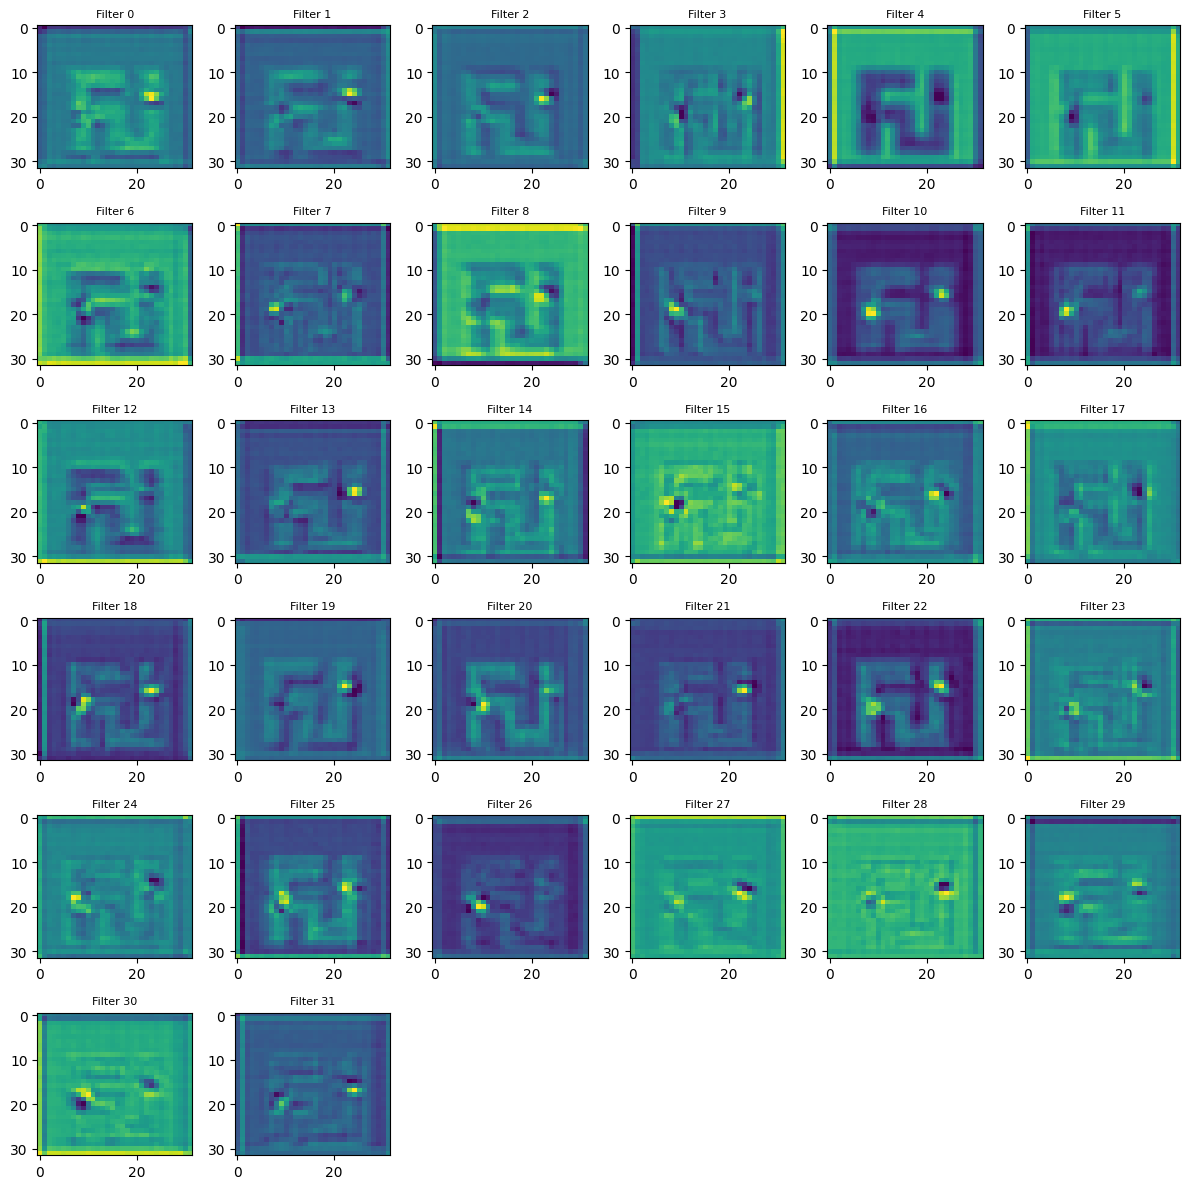

In [ ]:
helpers.plot_layer_activations_dynamic_grid(activation_dataset["gem"][0], "conv_seqs_1_conv")

In [120]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from src.probing import linear_probe, linear_probes
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [119]:
def linear_probe_per_category(
    activation_dataset,
    layer_path,
    model_type="classifier",
    test_size=0.2,
    random_state=None,
    **regression_kwargs,
):
    category_results = {}

    for category in activation_dataset.keys():
        X_category = torch.stack([act[layer_path][0] for act in activation_dataset[category]])
        y_category = torch.ones(len(activation_dataset[category])).long()

        X_rest = torch.cat([torch.stack([act[layer_path][0] for act in activation_dataset[cat]])
                            for cat in activation_dataset.keys() if cat != category])
        y_rest = torch.zeros(len(X_rest)).long()

        X = torch.cat([X_category, X_rest])
        y = torch.cat([y_category, y_rest])

                # Split the data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state
        )

        # Perform linear probing for the specific category
        result = linear_probe(
            X,
            y,
            model_type=model_type,
            test_size=test_size,
            random_state=random_state,
            **regression_kwargs,
        )
        
        category_results[category] = result
                # Evaluate the accuracy on the test set
        y_pred = result["model"].predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        result["test_accuracy"] = accuracy

        category_results[category] = result

    return category_results, result

In [152]:


def linear_probe_per_category_using_probes(
    activation_dataset,
    layer_path,
    model_type="classifier",
    test_size=0.2,
    random_state=None,
    **regression_kwargs,
):
    results = []  # List to store results
    category_names = []  # List to store category names for labeling purposes

    # Function to perform linear probing
    def linear_probes(xys, model_type, test_size, random_state, **kwargs):
        local_results = []
        for (X, y) in xys:
            X_train, X_test, y_train, y_test = train_test_split(X.numpy(), y.numpy(), test_size=test_size, random_state=random_state)
            if model_type == "classifier":
                model = LogisticRegression(**kwargs)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            report = classification_report(y_test, y_pred, output_dict=True)
            local_results.append((accuracy, report))
        return local_results

    # Prepare the data pairs
    for category in activation_dataset.keys():
        X_category = torch.stack([act[layer_path][0] for act in activation_dataset[category]])
        y_category = torch.ones(len(activation_dataset[category])).long()

        X_rest = torch.cat([torch.stack([act[layer_path][0] for act in activation_dataset[cat]])
                            for cat in activation_dataset.keys() if cat != category])
        y_rest = torch.zeros(len(X_rest)).long()

        X = torch.cat([X_category, X_rest])
        y = torch.cat([y_category, y_rest])

        category_names.append(category)
        results.append((X, y))

    # Use linear_probes function to conduct the probing
    probing_results = linear_probes(results, model_type=model_type, test_size=test_size, random_state=random_state, **regression_kwargs)

    # Creating a DataFrame for clearer output
    results_df = pd.DataFrame({
        'category': category_names,
        'test_accuracy': [result[0] for result in probing_results],
        'classification_report': [result[1] for result in probing_results]
    })

    return results_df

# Example usage
# activation_dataset and layer_path need to be defined as per your specific setup
results_dataframe = linear_probe_per_category_using_probes(activation_dataset, 'hidden_fc', model_type='classifier', test_size=0.2, random_state=42)


NameError: name 'activation_dataset' is not defined

In [ ]:
results_dataframe["test_accuracy"]

0    1.000000
1    0.992857
2    1.000000
3    1.000000
4    0.987500
5    1.000000
6    0.983929
Name: test_accuracy, dtype: float64

In [ ]:

single_class_category_results, single_class_result= linear_probe_per_category(activation_dataset, "hidden_fc")

/Users/bensturgeon/Library/Caches/pypoetry/virtualenvs/ai-safety-camp-Y8XZewIj-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bensturgeon/Library/Caches/pypoetry/virtualenvs/ai-safety-camp-Y8XZewIj-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer 

In [ ]:

y_pred = single_class_result["model"].predict(X_test)
y_pred

array([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,

In [126]:


def linear_probe_multiclass(
    activation_dataset,
    layer_path,
    model_type="classifier",
    test_size=0.2,
    random_state=None,
    **regression_kwargs,
):
    X = torch.cat([torch.stack([act[layer_path][0] for act in activation_dataset[category]])
                   for category in activation_dataset.keys()])
    y = torch.cat([torch.full((len(activation_dataset[category]),), i)
                   for i, category in enumerate(activation_dataset.keys())]).long()

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Perform linear probing for multi-class classification
    result = linear_probe(
        X_train,
        y_train,
        model_type=model_type,
        test_size=test_size,
        random_state=random_state,
        **regression_kwargs,
    )

    # Evaluate the accuracy and classification metrics on the test set
    y_pred = result["model"].predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    result["test_accuracy"] = accuracy
    result["classification_report"] = classification_report(y_test, y_pred, target_names=list(activation_dataset.keys()))

    return result


# category_results= linear_probe_multiclass(activation_dataset, "hidden_fc")
# print(category_results["test_accuracy"])
# category_results["conf_matrix"]

In [ ]:
print(category_results["classification_report"])

              precision    recall  f1-score   support

         gem       1.00      1.00      1.00        85
    blue_key       1.00      0.94      0.97        67
   green_key       1.00      1.00      1.00        77
     red_key       1.00      0.94      0.97        87
   blue_lock       0.95      1.00      0.98        83
  green_lock       1.00      1.00      1.00        82
    red_lock       0.94      1.00      0.97        79

    accuracy                           0.98       560
   macro avg       0.98      0.98      0.98       560
weighted avg       0.98      0.98      0.98       560



In [ ]:
X = torch.cat([torch.stack([act["hidden_fc"][0] for act in activation_dataset[category]])
                   for category in activation_dataset.keys()])
y = torch.cat([torch.full((len(activation_dataset[category]),), i)
                   for i, category in enumerate(activation_dataset.keys())]).long()

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=None
    )
y_pred = category_results["model"].predict(X_test)

In [ ]:
y_pred


array([6, 1, 1, 2, 1, 1, 5, 6, 4, 2, 6, 0, 3, 2, 4, 0, 0, 4, 3, 3, 5, 0,
       2, 1, 2, 5, 2, 2, 5, 0, 3, 4, 4, 1, 5, 3, 6, 0, 2, 5, 2, 3, 6, 2,
       4, 3, 4, 1, 5, 0, 6, 4, 0, 0, 4, 3, 3, 3, 5, 5, 4, 5, 2, 5, 6, 1,
       4, 4, 2, 0, 4, 6, 3, 0, 4, 1, 2, 6, 0, 6, 4, 6, 4, 4, 1, 0, 3, 6,
       3, 1, 4, 5, 0, 0, 2, 2, 0, 4, 2, 3, 2, 2, 2, 4, 1, 5, 3, 5, 5, 2,
       3, 2, 1, 6, 4, 6, 3, 4, 6, 6, 6, 6, 2, 3, 3, 5, 5, 6, 2, 2, 4, 4,
       4, 2, 5, 2, 0, 4, 6, 3, 4, 1, 6, 1, 6, 4, 5, 1, 2, 2, 6, 5, 4, 2,
       4, 2, 4, 4, 4, 3, 0, 0, 1, 2, 0, 6, 4, 4, 5, 2, 4, 6, 3, 3, 6, 3,
       4, 2, 5, 6, 1, 0, 2, 6, 0, 6, 6, 4, 5, 4, 6, 4, 0, 3, 3, 4, 0, 4,
       2, 5, 4, 4, 5, 5, 5, 3, 5, 2, 5, 1, 4, 0, 5, 5, 4, 5, 6, 1, 6, 0,
       2, 3, 5, 3, 4, 4, 2, 2, 3, 1, 0, 2, 6, 2, 2, 4, 5, 0, 1, 3, 4, 2,
       2, 1, 2, 3, 6, 1, 4, 2, 2, 4, 3, 2, 1, 6, 5, 3, 4, 4, 4, 0, 5, 4,
       0, 1, 1, 6, 5, 1, 2, 5, 5, 4, 6, 4, 5, 3, 2, 4, 0, 1, 6, 0, 2, 2,
       5, 3, 1, 1, 2, 6, 4, 4, 1, 3, 1, 5, 5, 4, 6,

In [ ]:
category_results["accuracy"]

0.9339285714285714

In [151]:
category_results= linear_probe_multiclass(activation_dataset, "logits_fc")
print("Accuracy:", category_results["test_accuracy"])
helpers.plot_confusion_matrix(category_results["conf_matrix"], activation_dataset)

NameError: name 'activation_dataset' is not defined

In [ ]:
print(category_results["classification_report"])

              precision    recall  f1-score   support

         gem       0.59      0.77      0.67        78
    blue_key       0.42      0.35      0.38        79
   green_key       0.32      0.30      0.31        82
     red_key       0.60      0.43      0.50        86
   blue_lock       0.25      0.25      0.25        75
  green_lock       0.35      0.33      0.34        87
    red_lock       0.52      0.64      0.57        73

    accuracy                           0.44       560
   macro avg       0.43      0.44      0.43       560
weighted avg       0.43      0.44      0.43       560



# Creating a directional dataset

We want to figure out if the logits_fc layer is involved with navigation, how much the hidden_fc layer plays a role in navigation, and if we can separate out the neurons involved with navigation in the hidden_fc layer. If we can determine this last thing then we can potentially control the movement of our player by manipulating the activations of the network.

To begin exploring this we need a dataset that can allow us to isolate these features in the network. Thus the goal is to create categories

In [111]:
num_levels = 5
venv = heist.create_venv(num=1, start_level=random.randint(1000, 10000), num_levels=num_levels)
state = heist.state_from_venv(venv, 0)

full_grid = state.full_grid(with_mouse=False)
entities = state.state_vals["ents"]
legal_mouse_positions = heist.get_legal_mouse_positions(full_grid, entities)

unchanged_obs= venv.reset()


state.remove_all_entities()


state =  heist.set_mouse_to_center(state)

state_bytes = state.state_bytes
if state_bytes is not None:
    venv.env.callmethod("set_state", [state_bytes])
    obs = venv.reset()



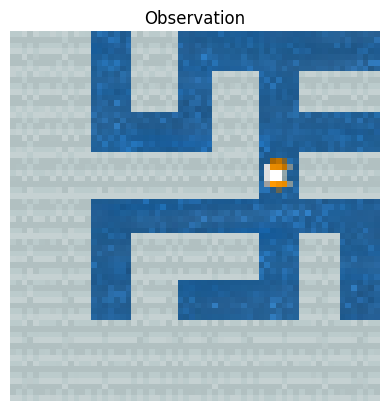

In [112]:
helpers.plot_single_observation(helpers.observation_to_rgb(obs))

In [115]:
dataset = heist.create_direction_dataset()

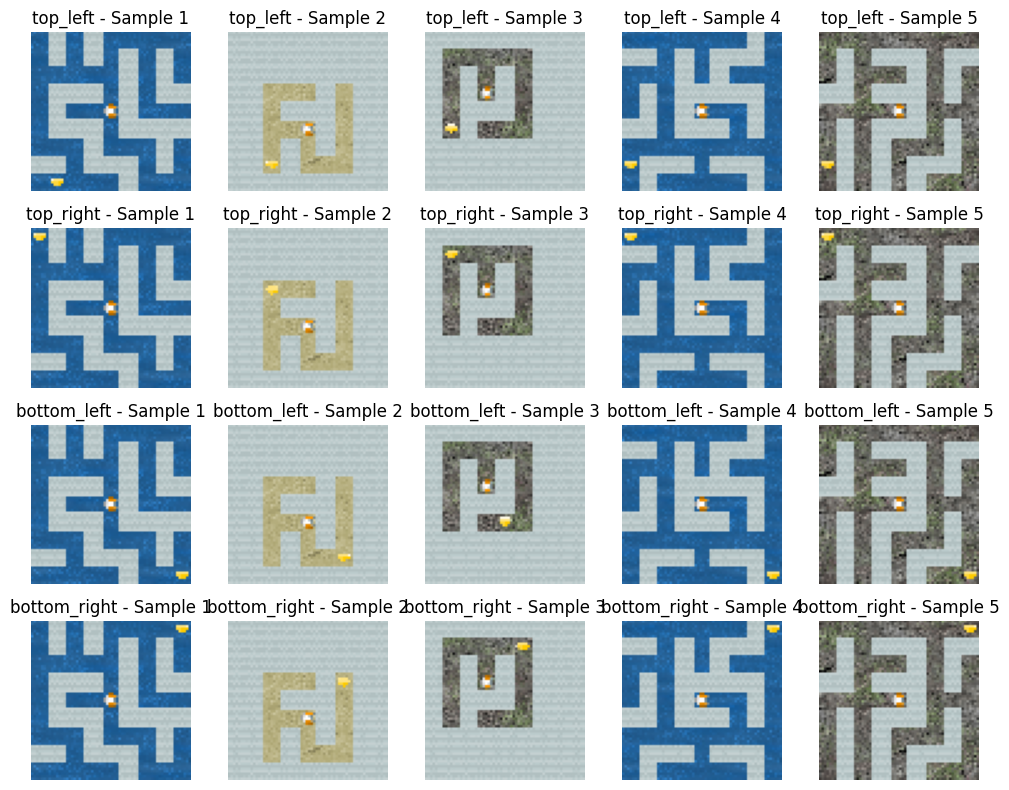

In [116]:
import matplotlib.pyplot as plt

def visualize_dataset(dataset, num_samples_per_category=5):
    categories = list(dataset.keys())
    num_categories = len(categories)

    fig, axes = plt.subplots(num_categories, num_samples_per_category, figsize=(num_samples_per_category * 2, num_categories * 2))

    for i, category in enumerate(categories):
        samples = dataset[category]
        for j, sample in enumerate(samples):
            ax = axes[i, j] if num_categories > 1 else axes[j]
            ax.imshow(sample)
            ax.set_title(f"{category} - Sample {j+1}")
            ax.axis("off")

    plt.tight_layout()
    plt.show()

visualize_dataset(dataset)

In [117]:
dataset = heist.create_direction_dataset(100)


In [121]:
def create_direction_activation_dataset(dataset, model, layer_paths):
    activation_dataset = {
        "top_left": [],
        "top_right": [],
        "bottom_left": [],
        "bottom_right": []
    }

    for category in dataset:
        for obs in dataset[category]:
            obs_rgb = helpers.observation_to_rgb(obs)
            model_activations = ModelActivations(model)
            _, activations = model_activations.run_with_cache(obs_rgb, layer_paths)
            model_activations.clear_hooks()


            activation_dataset[category].append(activations)

    return activation_dataset


In [135]:
model = helpers.load_model()
layer_names = helpers.get_model_layer_names(model)

direction_activation_dataset = create_direction_activation_dataset(dataset, model, layer_names)

In [147]:
direction_activation_dataset.keys()

dict_keys(['top_left', 'top_right', 'bottom_left', 'bottom_right'])

Accuracy: 0.6


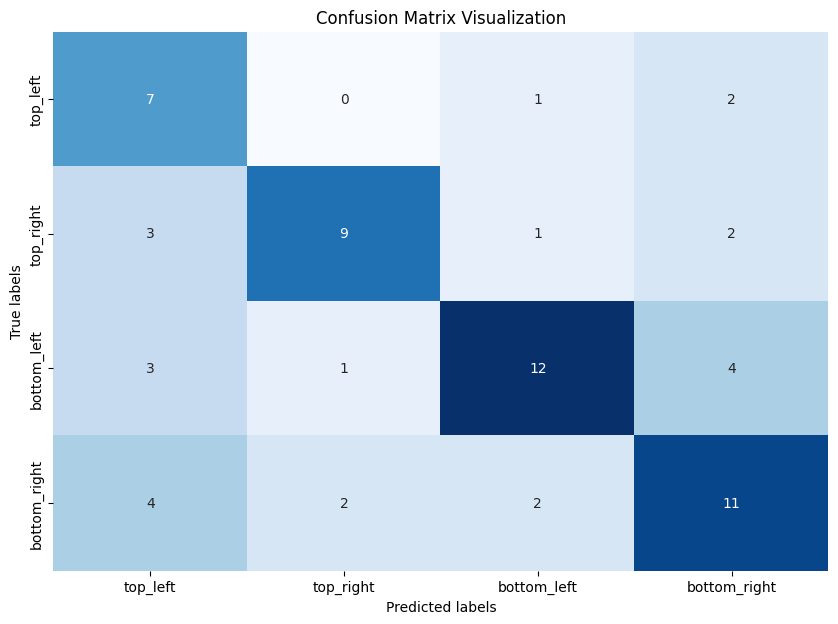

In [149]:
category_results= linear_probe_multiclass(direction_activation_dataset, "logits_fc")
print( "Accuracy:", category_results["test_accuracy"])
helpers.plot_confusion_matrix( category_results["conf_matrix"], direction_activation_dataset)

In [ ]:
print(category_results["classification_report"])

0.95


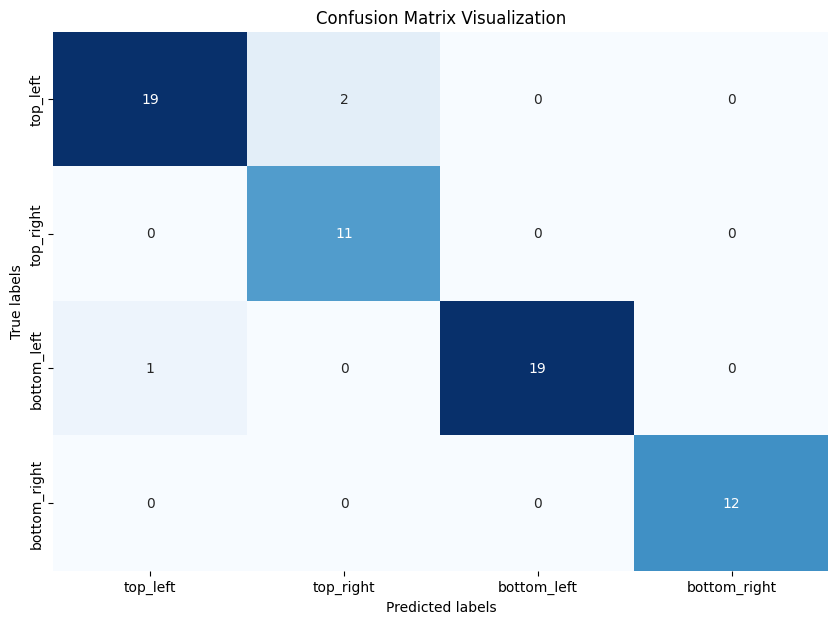

In [150]:
category_results= linear_probe_multiclass(direction_activation_dataset, "hidden_fc")
print(category_results["test_accuracy"])
helpers.plot_confusion_matrix(category_results["conf_matrix"], direction_activation_dataset)